In [2]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix

import joblib
import numpy as np
from pathlib import Path

# pour enlever les warnings
import warnings
warnings.filterwarnings('ignore')

# Import data

In [7]:
# load dataset containing sex and participant id
df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/Final_HCP_database.csv")
df

Unnamed: 0  index  subject_label Release Acquisition  Gender  Age_in_Yrs  \
0             0      0         100206    S900         Q11       0          27   
1             1      1         100610    S900         Q08       0          27   
2             2      2         101006    S500         Q06       1          35   
3             3      4         102008    S500         Q06       0          24   
4             4      7         102513    S900         Q10       0          30   
..          ...    ...            ...     ...         ...     ...         ...   
559         559    662         990366    S900         Q10       0          22   
560         560    663         991267    S500         Q06       0          30   
561         561    664         992673    S900         Q12       1          33   
562         562    665         993675    S900         Q09       1          29   
563         563    666         996782    S900         Q08       1          28   

                     Race            Ethnicity  Handedness  ...  Noise_Comp  \
0                   White  Not Hispanic/Latino          65  ...         6.0   
1                   White  Not Hispanic/Latino          85  ...         2.0   
2    Black or African Am.  Not Hispanic/Latino          90  ...         6.0   
3                   White      Hispanic/Latino          80  ...         6.0   
4                   White  Not Hispanic/Latino          50  ...         5.2   
..                    ...                  ...         ...  ...         ...   
559                 White  Not Hispanic/Latino          95  ...         4.4   
560                 White  Not Hispanic/Latino          75  ...         2.8   
561                 White  Not Hispanic/Latino          70  ...         3.6   
562                 White  Not Hispanic/Latino          85  ...         0.4   
563                 White  Not Hispanic/Latino         100  ...         6.0   

     Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  PainInterf_Tscore  \
0        108.79        97.19                  1.0               49.7   
1        122.25       110.45                  0.0               38.6   
2        122.25       111.41                  0.0               38.6   
3        122.25       110.45                  0.0               50.1   
4        108.79        98.04                  2.0               54.3   
..          ...          ...                  ...                ...   
559      108.79        97.19                  1.0               52.6   
560      122.25       111.41                  1.0               46.6   
561      122.25       111.41                  1.0               38.6   
562      122.25       110.45                  0.0               38.6   
563      108.79        97.19                  0.0               38.6   

     Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  Mars_Final  
0          72.63         72.03            1.84        0.0        1.84  
1          84.84         85.31            1.92        1.0        1.88  
2         123.80        123.31            1.80        0.0        1.80  
3          67.48         65.31            1.80        0.0        1.80  
4          84.07         82.37            1.92        0.0        1.92  
..           ...           ...             ...        ...         ...  
559        93.82         92.63            1.80        0.0        1.80  
560        83.23         81.55            1.84        0.0        1.84  
561       101.63         99.26            1.80        0.0        1.80  
562        84.07         84.25            1.80        1.0        1.76  
563        75.43         73.72            1.84        0.0        1.84  

[564 rows x 389 columns]

In [8]:
print("hommes = ", df["Gender"].value_counts()[0])
print("femmes = ", df["Gender"].value_counts()[1])

hommes =  263
femmes =  301


In [9]:
average_age_men = round(df[df["Gender"]== 0]["Age_in_Yrs"].mean(),1)
average_age_men


27.5

In [10]:
average_age_women = round(df[df["Gender"]== 1]["Age_in_Yrs"].mean(),1)
average_age_women


29.1

In [11]:
# get the faster seed
file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__voxelcorrelations.csv"
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
data = {}

for seed in SEEDS:
    file = file_path.format(seed_name=seed)
    loaded = pd.read_csv(file_path.format(seed_name=seed))
    for subject in df["subject_label"]:
        string = "sub-"+str(subject)
        new  = loaded.loc[loaded["Unnamed: 0"] == string]
        data[(subject, seed)] = new.loc[:, new.columns!='Unnamed: 0'].to_numpy()[0]

In [12]:
df_boot = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/Final_HCP_database.csv")
x_correl = []
for sub in tqdm(df_boot["subject_label"]):
    line_temp = []
    for seed in SEEDS:
        line_temp.append(data[(sub, seed)])
    x_correl.append(np.concatenate(line_temp))
x_correl = np.array(x_correl)


100%|██████████████████████████████████████| 564/564 [00:00<00:00, 88126.79it/s]


# Define function

In [13]:
def regionsOfInterest(accuracy, pvalue, moyenne, rois, label, x_correl):
    pvalue_val = pvalue.reshape(len(rois), 148).T
    pvalue_uncorrected = pvalue_val < 0.05

    data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=rois)
    data_pval = pd.DataFrame(pvalue_val, columns=rois)

    pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)
    
    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)

    # X_std = x_correl.std()
    # weighted_coef = moyenne * X_std
    # label_name = list(label['name']) * len(rois)
    # seed_name = np.repeat(rois, 148)
    
    weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
    weighted_tab['seed'] = seed_name
    weighted_tab['labels'] = label_name
    
    # print the 10 best seed anf their labels
    print(weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10))
    
    
    # weighted_coef[weighted_coef<0.054609] = 0 # maybe changed the 0.054609 for a variable
        
    
    # printing the accuracy and its interval of confidance
    acc_test = np.asarray(accuracy)
    moy = np.mean(acc_test)
    se = np.std(acc_test)
    lower = moy - (1.96 * se)
    upper = moy + (1.96 * se)
    
    print("The mean accuracy : " + str(moy))
    print("The standard deviation of the accuracy : " + str(se))
    print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
    print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
    
    return weighted_tab

In [14]:
def bestRegion(ROIs, data_dict, data_df):
    
    best = ROIs.sort_values(by=['coefficient'], ascending=False).head(10)
    best_roi = []

    for row in best.iterrows():
        best_roi.append([row[1][1], row[1][2], [], []])

    label_female = []
    label_male = []

    for i in range(0,len(data_df["Gender"])):
        if data_df["Gender"][i] == 0:
            label_male.append(data_df["subject_label"][i])

        elif data_df["Gender"][i] == 1:
            label_female.append(data_df["subject_label"][i])
            

    for i in data_dict.keys():
        if label_male.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][2].append(data_dict[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

        elif label_female.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][3].append(data_dict[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

    table_best = pd.DataFrame(columns=["Region", "Men", "Women", "P value"])
    for i in range(0, len(best_roi)):
        best_roi[i][2] = np.asarray(best_roi[i][2]) # male
        best_roi[i][3] = np.asarray(best_roi[i][3]) # female
        plt.boxplot([best_roi[i][2], best_roi[i][3]])
        plt.xticks([1,2], ["male", "female"])
        plt.title(best_roi[i][0]+" "+best_roi[i][1])
        plt.show()
        print(stats.ttest_ind(best_roi[i][2], best_roi[i][3]))
        print("male mean : "+ str(np.mean(best_roi[i][2])))
        print("male std : " + str(np.std(best_roi[i][2])))
        print("female mean : "+ str(np.mean(best_roi[i][3])))
        print("female std : " + str(np.std(best_roi[i][3])))
        table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],
                                        'Men' : np.mean(best_roi[i][2]), 
                                        'Women' : np.mean(best_roi[i][3]), 
                                        'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}, ignore_index=True)
        
    print(table_best)

In [15]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    
    See also nltools summarized_bootstrap function: https://nltools.org/_modules/nltools/stats.html
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [16]:
def compute_results(results_path):
    results = joblib.load(results_path)

    coefs = []
    for result in results:
        coefs.append(result["model"].coef_[0])

    coefs = np.array(coefs)

    data_results = pd.DataFrame.from_dict(results)
    moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)
    return moyenne, scoresZ, pvalue_bonf, data_results

## Define data path to each model results

In [59]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_2024" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results_2024" / "LinearSVC" / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results_2024" / "LinearSVC" / "seed-aMTG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results_2024" / "LinearSVC" / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results_2024" / "LinearSVC" / "seed-opIFG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results_2024" / "LinearSVC" / "seed-pITG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results_2024" / "LinearSVC" / "seed-pITG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results_2024" / "LinearSVC" / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results_2024" / "LinearSVC" / "seed-planumtemp_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_left = study_dir / "results_2024" / "LinearSVC" / "seed-left_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_right = study_dir / "results_2024" / "LinearSVC" / "seed-right_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"


# Best region with grey matter corrected

In [18]:
# fetching label from destrieux atlas minus two labels not used
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
label = atlas_dest["labels"].drop([0,42,117]) # correction for the destrieux atlas labels
label = label.reset_index()

In [46]:
data_results

len_X_train  len_X_test                 score  \
0             361          91  [0.8198198198198199]   
1             361          91  [0.8421171171171172]   
2             361          91  [0.7898648648648648]   
3             361          91  [0.8393393393393394]   
4             361          91  [0.8560060060060062]   
...           ...         ...                   ...   
9995          361          91  [0.8253753753753754]   
9996          361          91   [0.819894894894895]   
9997          361          91  [0.8503753753753754]   
9998          361          91  [0.8256006006006006]   
9999          361          91  [0.8228978978978979]   

                                       confusion_matrix  \
0     predicted class  Femme  Homme
actual class    ...   
1     predicted class  Femme  Homme
actual class    ...   
2     predicted class  Femme  Homme
actual class    ...   
3     predicted class  Femme  Homme
actual class    ...   
4     predicted class  Femme  Homme
actual class    ...   
...                                                 ...   
9995  predicted class  Femme  Homme
actual class    ...   
9996  predicted class  Femme  Homme
actual class    ...   
9997  predicted class  Femme  Homme
actual class    ...   
9998  predicted class  Femme  Homme
actual class    ...   
9999  predicted class  Femme  Homme
actual class    ...   

                            confusion_matrix_validation  acc_test  acc_train  \
0     predicted class  Femme  Homme
actual class    ...  0.769231   0.919668   
1     predicted class  Femme  Homme
actual class    ...  0.857143   0.927978   
2     predicted class  Femme  Homme
actual class    ...  0.824176   0.914127   
3     predicted class  Femme  Homme
actual class    ...  0.802198   0.947368   
4     predicted class  Femme  Homme
actual class    ...  0.802198   0.927978   
...                                                 ...       ...        ...   
9995  predicted class  Femme  Homme
actual class    ...  0.857143   0.914127   
9996  predicted class  Femme  Homme
actual class    ...  0.857143   0.922438   
9997  predicted class  Femme  Homme
actual class    ...  0.835165   0.936288   
9998  predicted class  Femme  Homme
actual class    ...  0.890110   0.941828   
9999  predicted class  Femme  Homme
actual class    ...  0.824176   0.939058   

      acc_validation                                  model  
0           0.669643  LinearSVC(dual=False, max_iter=10000)  
1           0.696429  LinearSVC(dual=False, max_iter=10000)  
2           0.696429  LinearSVC(dual=False, max_iter=10000)  
3           0.696429  LinearSVC(dual=False, max_iter=10000)  
4           0.660714  LinearSVC(dual=False, max_iter=10000)  
...              ...                                    ...  
9995        0.678571  LinearSVC(dual=False, max_iter=10000)  
9996        0.678571  LinearSVC(dual=False, max_iter=10000)  
9997        0.633929  LinearSVC(dual=False, max_iter=10000)  
9998        0.642857  LinearSVC(dual=False, max_iter=10000)  
9999        0.678571  LinearSVC(dual=False, max_iter=10000)  

[10000 rows x 9 columns]

## Best regions all seed

      coefficient          seed                       labels
98       0.080936       opIFG_L       R G_pariet_inf-Angular
1079     0.061961        pITG_R                L S_calcarine
55       0.061655       opIFG_L  L S_intrapariet_and_P_trans
53       0.059059       opIFG_L                L S_front_sup
379      0.057851        aMTG_L      R G_cingul-Post-ventral
301      0.055354        aMTG_L         L G_and_S_cingul-Ant
504      0.053628        pITG_L  L S_oc-temp_med_and_Lingual
305      0.053026        aMTG_L      L G_cingul-Post-ventral
189      0.052916  planumtemp_L             L Pole_occipital
1013     0.051722        aMTG_R                R S_front_inf
The mean accuracy : 0.9062513274336282
The standard deviation of the accuracy : 0.02943331307469047
The lower boundry of the confidance interval of the accuracy : 0.8485620338072349
The upper boundry of the confidance interval of the accuracy : 0.9639406210600215


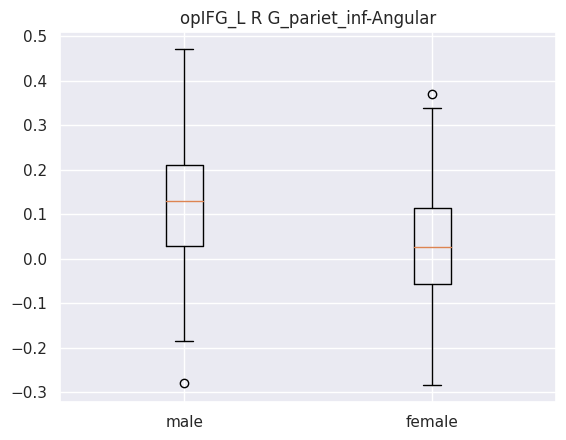

Ttest_indResult(statistic=7.716695110055561, pvalue=5.480751648776057e-14)
male mean : 0.11766997985152092
male std : 0.13076288558639354
female mean : 0.03601953544850498
female std : 0.12000095132461792


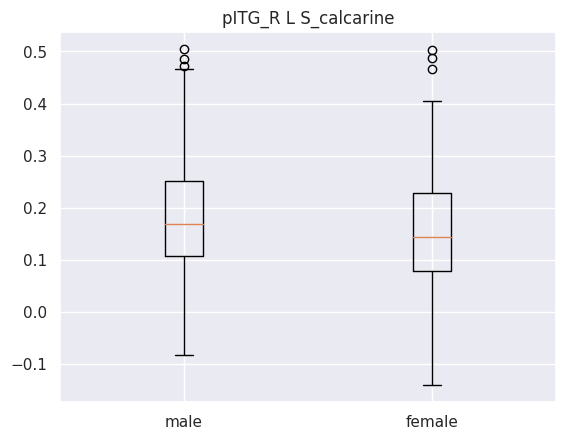

Ttest_indResult(statistic=3.2351347094550422, pvalue=0.0012873143650390924)
male mean : 0.18480961091102663
male std : 0.10817911899491708
female mean : 0.1554359898385382
female std : 0.10667308658653767


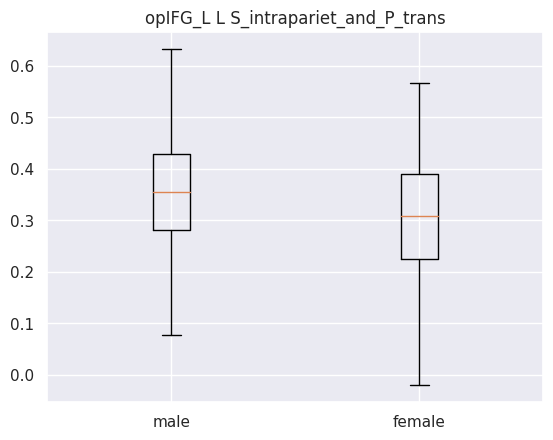

Ttest_indResult(statistic=5.055350828931209, pvalue=5.821781911163281e-07)
male mean : 0.35213074777946773
male std : 0.10658887449917556
female mean : 0.3031099729109635
female std : 0.12130464463020163


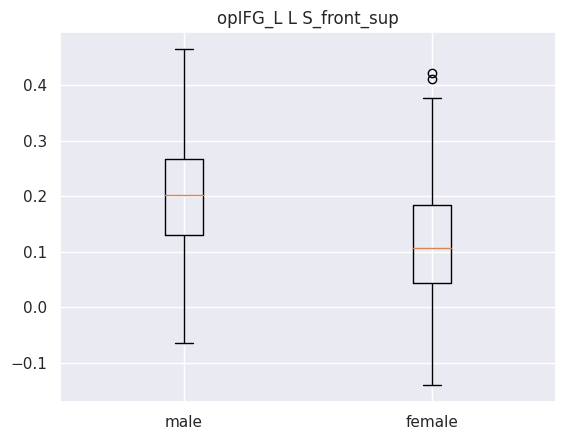

Ttest_indResult(statistic=10.006029115486237, pvalue=8.422510097736992e-22)
male mean : 0.1996858131581749
male std : 0.10098467263884126
female mean : 0.11606861896099667
female std : 0.09690605329034335


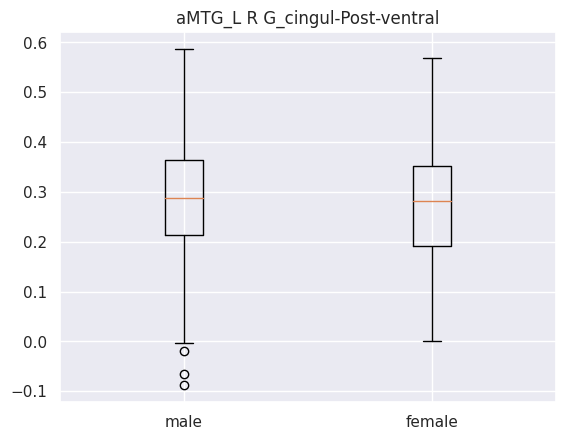

Ttest_indResult(statistic=0.6388341521167346, pvalue=0.5231910904943788)
male mean : 0.2817180546878327
male std : 0.1142358661162035
female mean : 0.27555022588073086
female std : 0.11413329475603474


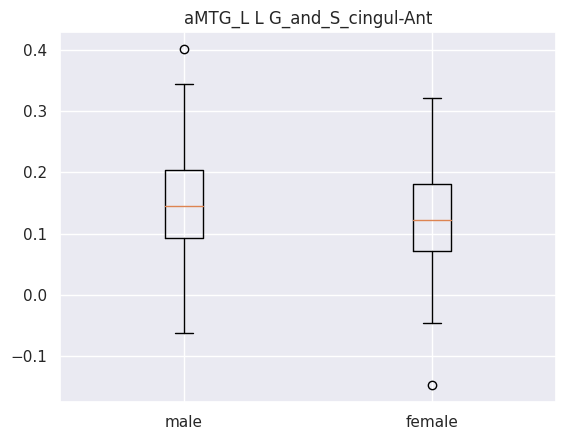

Ttest_indResult(statistic=3.7303929972815153, pvalue=0.0002105917212726882)
male mean : 0.15045088956692015
male std : 0.0832245566464698
female mean : 0.1251106278551495
female std : 0.07772302305402938


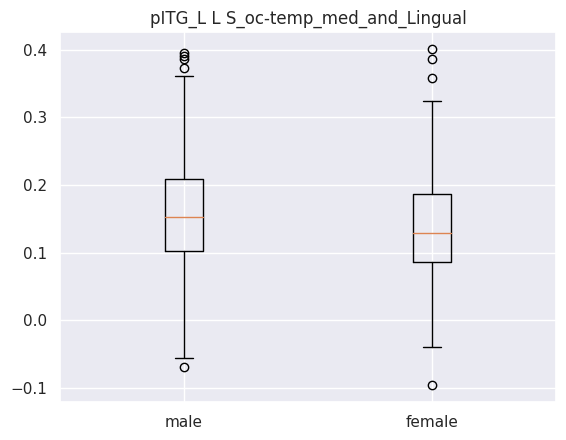

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
male std : 0.08334523805349907
female mean : 0.13959590949933556
female std : 0.07802101521527612


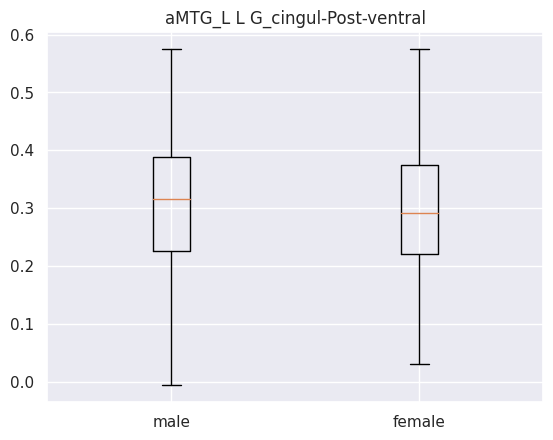

Ttest_indResult(statistic=1.3702197065710244, pvalue=0.17116542321143072)
male mean : 0.3069893446501901
male std : 0.11217529835047435
female mean : 0.29388020735880394
female std : 0.1139849037228173


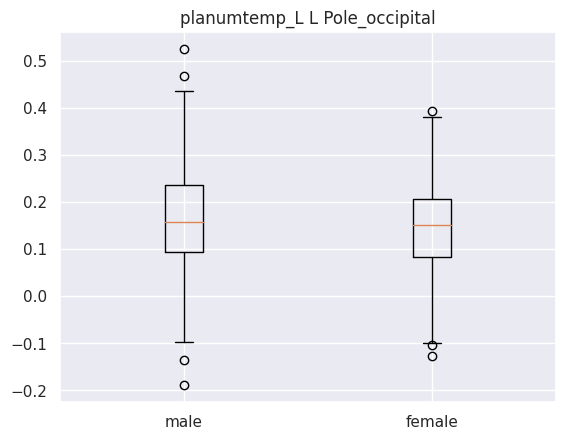

Ttest_indResult(statistic=2.486200541931443, pvalue=0.013200894125973316)
male mean : 0.16626784924790874
male std : 0.11264322709736568
female mean : 0.14439602449857145
female std : 0.09589248593995307


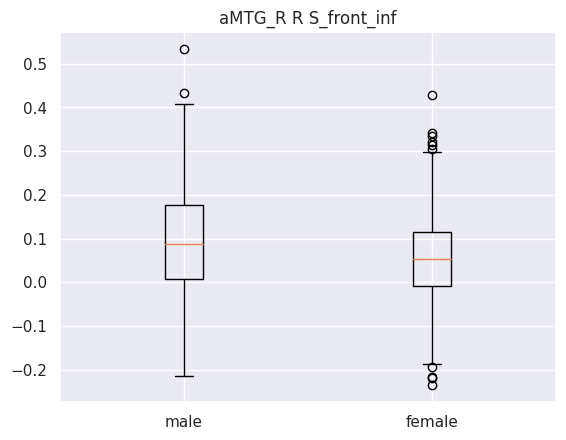

Ttest_indResult(statistic=4.148252422200393, pvalue=3.868639529214971e-05)
male mean : 0.09520096379193917
male std : 0.11824387845447384
female mean : 0.055367278695980064
female std : 0.10930840275035555
                                  Region       Men     Women       P value
0       opIFG_L - R G_pariet_inf-Angular  0.117670  0.036020  5.480752e-14
1                 pITG_R - L S_calcarine  0.184810  0.155436  1.287314e-03
2  opIFG_L - L S_intrapariet_and_P_trans  0.352131  0.303110  5.821782e-07
3                opIFG_L - L S_front_sup  0.199686  0.116069  8.422510e-22
4       aMTG_L - R G_cingul-Post-ventral  0.281718  0.275550  5.231911e-01
5          aMTG_L - L G_and_S_cingul-Ant  0.150451  0.125111  2.105917e-04
6   pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  2.643129e-03
7       aMTG_L - L G_cingul-Post-ventral  0.306989  0.293880  1.711654e-01
8        planumtemp_L - L Pole_occipital  0.166268  0.144396  1.320089e-02
9                 aMTG_R - R S_front_inf  0.

In [60]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions for aMTG_L

     coefficient    seed                       labels
22      0.251448  aMTG_L      L G_oc-temp_med-Parahip
98      0.235516  aMTG_L       R G_pariet_inf-Angular
104     0.216673  aMTG_L                   R G_rectus
64      0.198969  aMTG_L        L S_parieto_occipital
53      0.187694  aMTG_L                L S_front_sup
131     0.179025  aMTG_L   R S_oc_sup_and_transversal
55      0.177971  aMTG_L  L S_intrapariet_and_P_trans
29      0.154544  aMTG_L                L G_precuneus
87      0.154097  aMTG_L       R G_front_inf-Triangul
103     0.137369  aMTG_L                R G_precuneus
The mean accuracy : 0.8101433628318584
The standard deviation of the accuracy : 0.03814689567474887
The lower boundry of the confidance interval of the accuracy : 0.7353754473093506
The upper boundry of the confidance interval of the accuracy : 0.8849112783543662


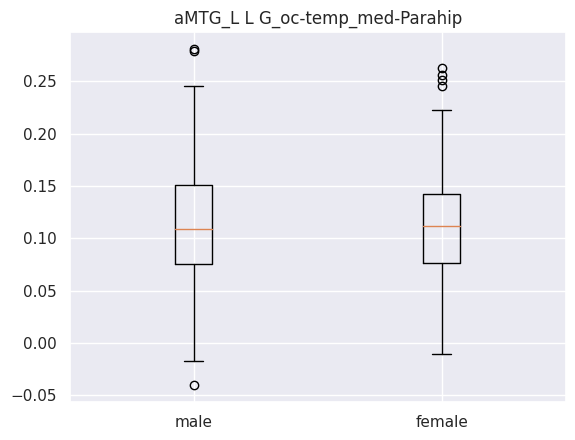

Ttest_indResult(statistic=1.1334696103846564, pvalue=0.25750038435672185)
male mean : 0.11530491022243346
male std : 0.05322901814260232
female mean : 0.11041756162126246
female std : 0.048956437497619715


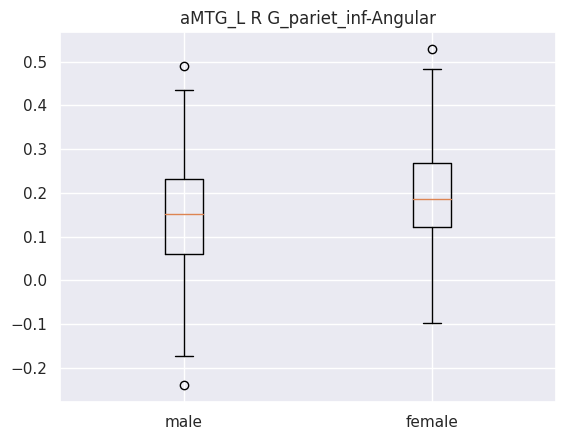

Ttest_indResult(statistic=-4.609075888150725, pvalue=5.010077069107832e-06)
male mean : 0.1466265599053232
male std : 0.12723212732120814
female mean : 0.1927383331056479
female std : 0.109937688897089


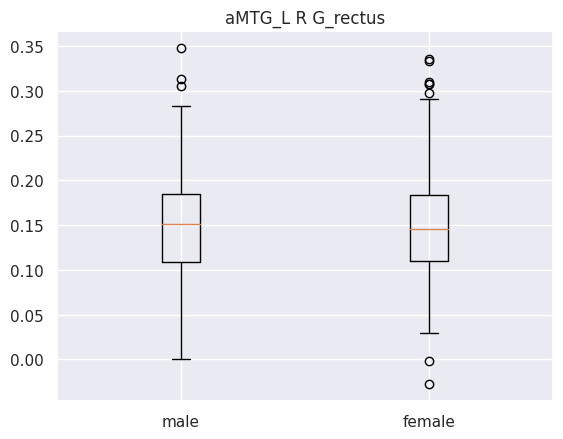

Ttest_indResult(statistic=-0.050680278730783346, pvalue=0.9595982987735558)
male mean : 0.14921290738174903
male std : 0.05910948627590685
female mean : 0.14947103351827243
female std : 0.061200009471971246


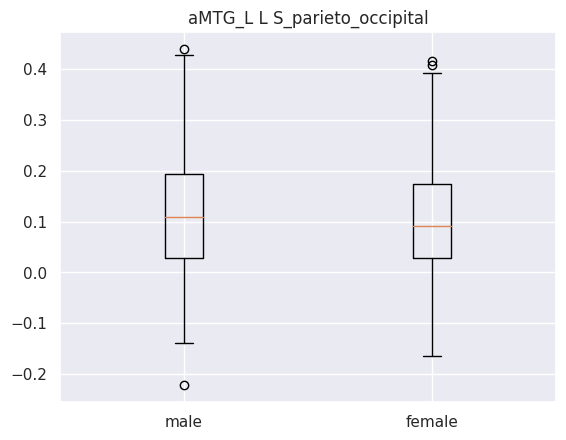

Ttest_indResult(statistic=0.8844937044320892, pvalue=0.3768080010830589)
male mean : 0.11133875940456274
male std : 0.11414917252822208
female mean : 0.10330131695813953
female std : 0.1012672300745512


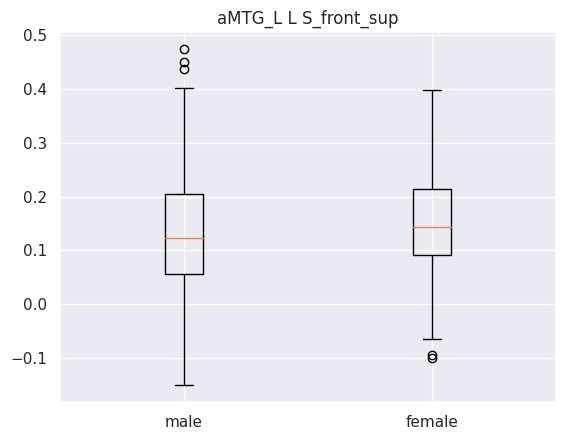

Ttest_indResult(statistic=-1.4354160996967782, pvalue=0.15172486392697015)
male mean : 0.13497622929505704
male std : 0.11129746737694128
female mean : 0.14753736321687708
female std : 0.0961519746523398


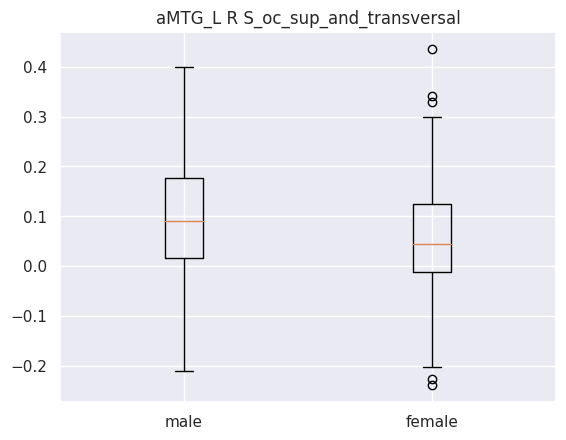

Ttest_indResult(statistic=4.340453076267227, pvalue=1.686421726368641e-05)
male mean : 0.09461966041634981
male std : 0.1152752884396305
female mean : 0.054491475181651164
female std : 0.10386960568631878


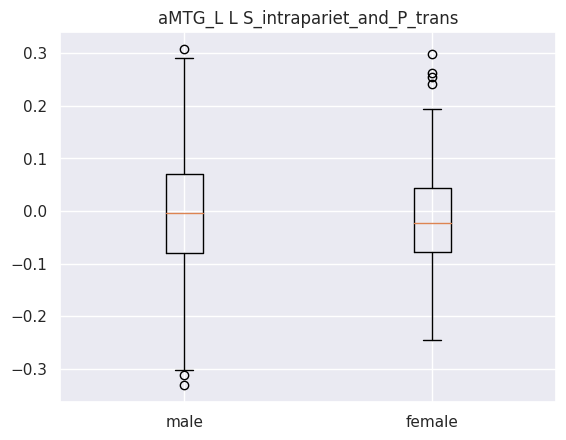

Ttest_indResult(statistic=0.9647641183387371, pvalue=0.3350779189775276)
male mean : -0.004121455086692014
male std : 0.11166920373773248
female mean : -0.012516677279534883
female std : 0.09459673974350062


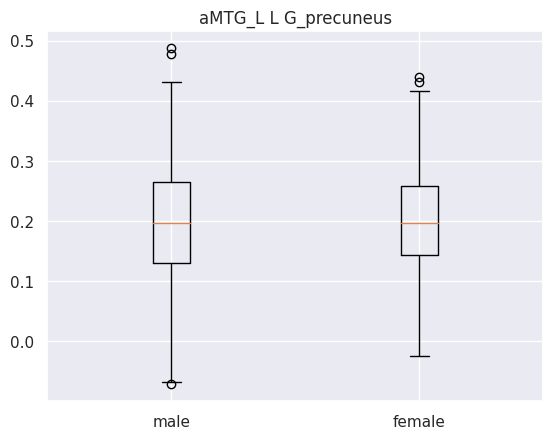

Ttest_indResult(statistic=0.34352085134667926, pvalue=0.7313351295320519)
male mean : 0.2003016257026616
male std : 0.10076302077787475
female mean : 0.1975837047968771
female std : 0.08679728049955084


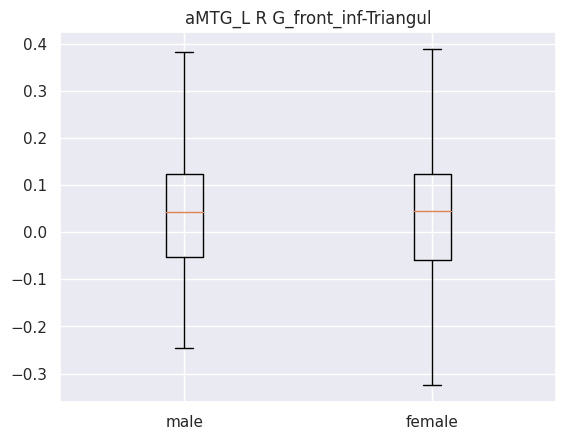

Ttest_indResult(statistic=0.12631199818411354, pvalue=0.8995301343742685)
male mean : 0.04378524430243346
male std : 0.13158479648887714
female mean : 0.042384303678737544
female std : 0.1308012611400562


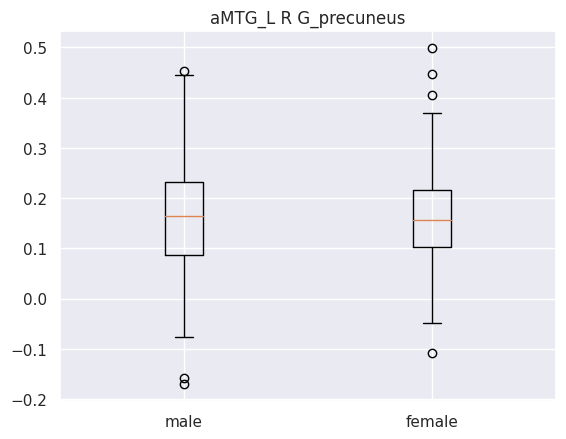

Ttest_indResult(statistic=-0.3353892597148926, pvalue=0.7374566259309934)
male mean : 0.15796897781863115
male std : 0.10510874270635935
female mean : 0.16072608648106312
female std : 0.08976109747415041
                                 Region       Men     Women   P value
0      aMTG_L - L G_oc-temp_med-Parahip  0.115305  0.110418  0.257500
1       aMTG_L - R G_pariet_inf-Angular  0.146627  0.192738  0.000005
2                   aMTG_L - R G_rectus  0.149213  0.149471  0.959598
3        aMTG_L - L S_parieto_occipital  0.111339  0.103301  0.376808
4                aMTG_L - L S_front_sup  0.134976  0.147537  0.151725
5   aMTG_L - R S_oc_sup_and_transversal  0.094620  0.054491  0.000017
6  aMTG_L - L S_intrapariet_and_P_trans -0.004121 -0.012517  0.335078
7                aMTG_L - L G_precuneus  0.200302  0.197584  0.731335
8       aMTG_L - R G_front_inf-Triangul  0.043785  0.042384  0.899530
9                aMTG_L - R G_precuneus  0.157969  0.160726  0.737457


In [61]:
rois = ["aMTG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions aMTG_R

     coefficient    seed                       labels
22      0.244687  aMTG_R      L G_oc-temp_med-Parahip
90      0.223095  aMTG_R    R G_Ins_lg_and_S_cent_ins
98      0.192974  aMTG_R       R G_pariet_inf-Angular
104     0.180849  aMTG_R                   R G_rectus
66      0.164490  aMTG_R              L S_postcentral
75      0.163681  aMTG_R      R G_and_S_occipital_inf
55      0.163259  aMTG_R  L S_intrapariet_and_P_trans
108     0.152673  aMTG_R      R G_temp_sup-Plan_polar
4       0.142937  aMTG_R   L G_and_S_transv_frontopol
135     0.142490  aMTG_R          R S_orbital_lateral
The mean accuracy : 0.8038442477876107
The standard deviation of the accuracy : 0.039244147490102514
The lower boundry of the confidance interval of the accuracy : 0.7269257187070097
The upper boundry of the confidance interval of the accuracy : 0.8807627768682116


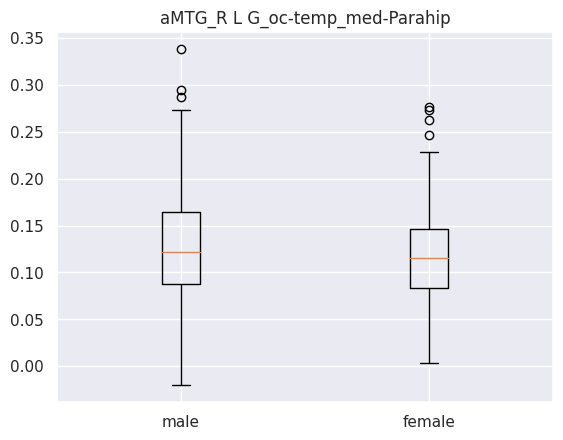

Ttest_indResult(statistic=2.0619605458315986, pvalue=0.039670656140978776)
male mean : 0.1272253816121673
male std : 0.05639247240973288
female mean : 0.11806232951096346
female std : 0.04895538358491254


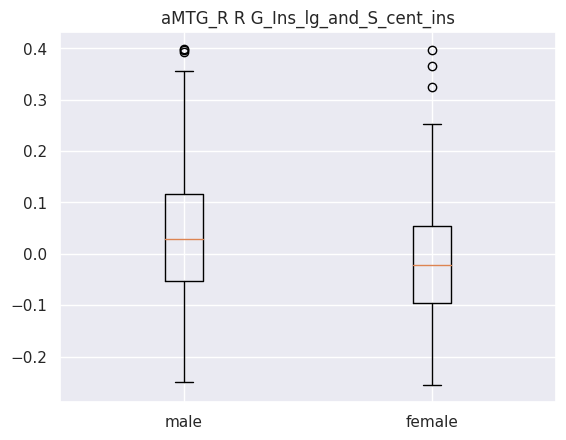

Ttest_indResult(statistic=4.892230628154193, pvalue=1.3038463843832238e-06)
male mean : 0.03623579969863118
male std : 0.1252291741990028
female mean : -0.012065202055481731
female std : 0.1088246644922351


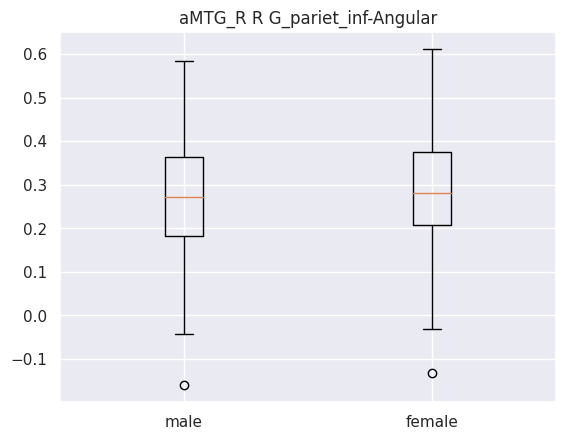

Ttest_indResult(statistic=-1.3474458962609632, pvalue=0.17837963763879625)
male mean : 0.2745868511307985
male std : 0.12784455793647628
female mean : 0.2885656095314618
female std : 0.1180010594320334


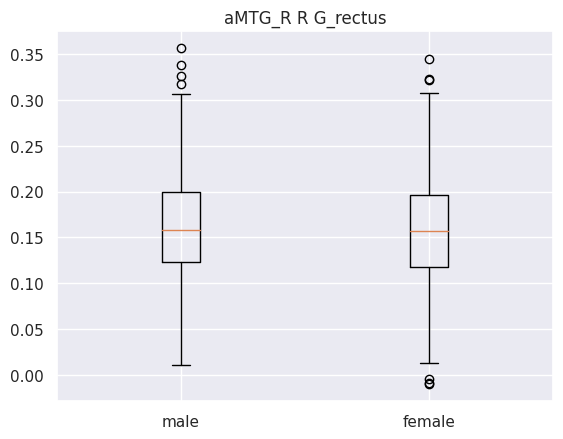

Ttest_indResult(statistic=0.25672681729231484, pvalue=0.7974836233347031)
male mean : 0.1602442236539924
male std : 0.062175408547676864
female mean : 0.1588885866717608
female std : 0.06268623105683578


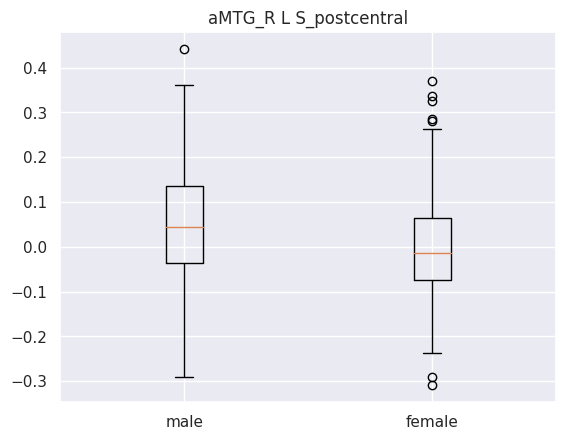

Ttest_indResult(statistic=4.256925055374874, pvalue=2.4287280099892244e-05)
male mean : 0.04534421238403042
male std : 0.1320116871677358
female mean : 0.000728705031428572
female std : 0.11644638587728438


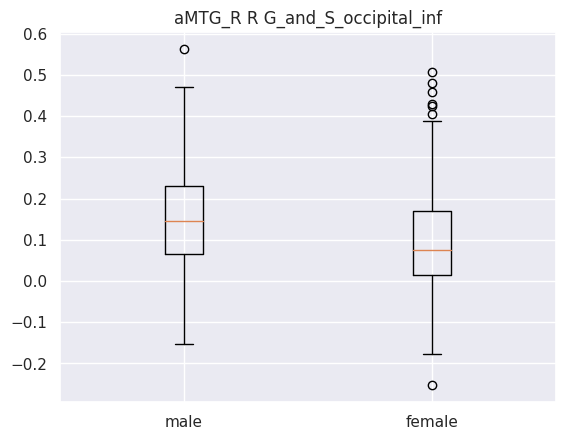

Ttest_indResult(statistic=5.746838754084861, pvalue=1.4919371944492937e-08)
male mean : 0.1548778395163498
male std : 0.12383961806520402
female mean : 0.09606502119933555
female std : 0.11852064008245364


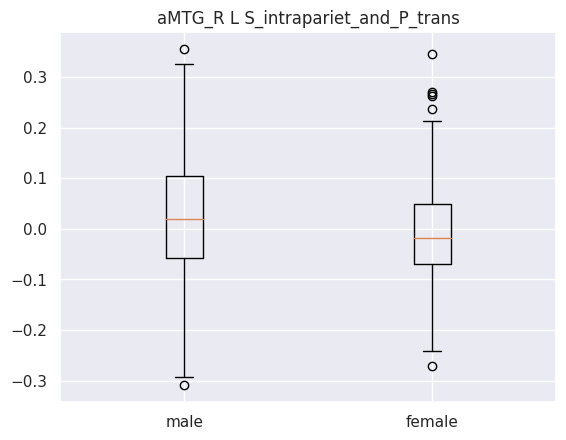

Ttest_indResult(statistic=3.0510209113028184, pvalue=0.0023882691927384963)
male mean : 0.018445383925361214
male std : 0.11377089527880688
female mean : -0.008577846181096346
female std : 0.09617201070855781


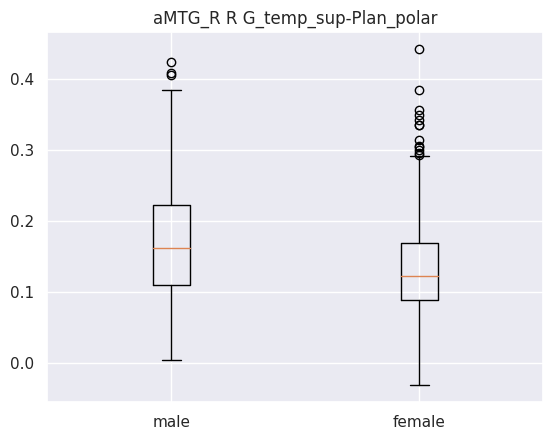

Ttest_indResult(statistic=5.308541697972609, pvalue=1.593449987883036e-07)
male mean : 0.17148337507528516
male std : 0.08089641360793041
female mean : 0.136273162079402
female std : 0.07623102186843383


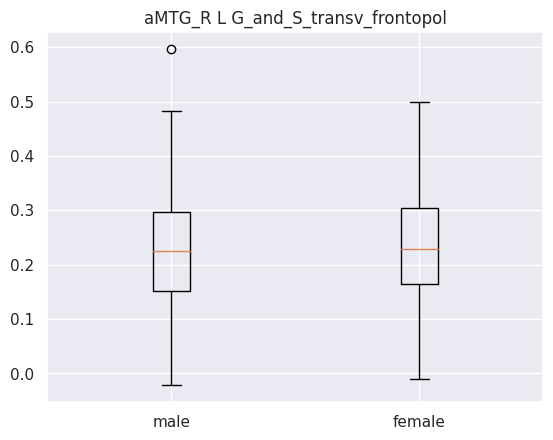

Ttest_indResult(statistic=-0.2621748360542157, pvalue=0.793282720636715)
male mean : 0.22834782620342206
male std : 0.10640876530077442
female mean : 0.23062295921428572
female std : 0.09920670714718044


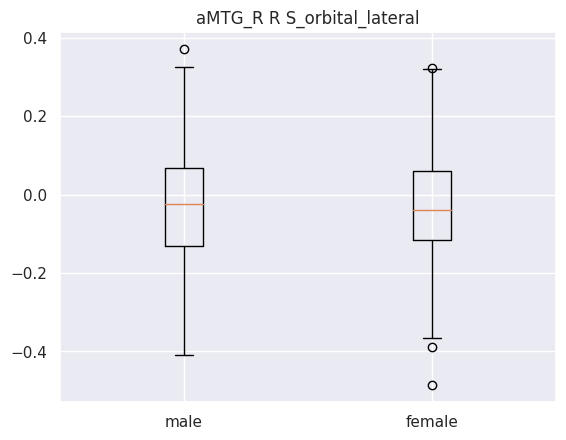

Ttest_indResult(statistic=0.3799477655046024, pvalue=0.7041277300292638)
male mean : -0.02739585445323194
male std : 0.13897809835212688
female mean : -0.0318923487744186
female std : 0.1408101730772882
                                 Region       Men     Women       P value
0      aMTG_R - L G_oc-temp_med-Parahip  0.127225  0.118062  3.967066e-02
1    aMTG_R - R G_Ins_lg_and_S_cent_ins  0.036236 -0.012065  1.303846e-06
2       aMTG_R - R G_pariet_inf-Angular  0.274587  0.288566  1.783796e-01
3                   aMTG_R - R G_rectus  0.160244  0.158889  7.974836e-01
4              aMTG_R - L S_postcentral  0.045344  0.000729  2.428728e-05
5      aMTG_R - R G_and_S_occipital_inf  0.154878  0.096065  1.491937e-08
6  aMTG_R - L S_intrapariet_and_P_trans  0.018445 -0.008578  2.388269e-03
7      aMTG_R - R G_temp_sup-Plan_polar  0.171483  0.136273  1.593450e-07
8   aMTG_R - L G_and_S_transv_frontopol  0.228348  0.230623  7.932827e-01
9          aMTG_R - R S_orbital_lateral -0.027396 -0.0318

In [62]:
rois = ["aMTG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions opIFG_L

     coefficient     seed                       labels
20      0.189302  opIFG_L      L G_oc-temp_lat-fusifor
47      0.182472  opIFG_L      L S_circular_insula_inf
72      0.177692  opIFG_L             L S_temporal_sup
60      0.171919  opIFG_L  L S_oc-temp_med_and_Lingual
91      0.170919  opIFG_L            R G_insular_short
144     0.170130  opIFG_L              R S_subparietal
40      0.164383  opIFG_L               L Lat_Fis-post
1       0.151775  opIFG_L      L G_and_S_occipital_inf
89      0.148907  opIFG_L                R G_front_sup
64      0.134829  opIFG_L        L S_parieto_occipital
The mean accuracy : 0.8340097345132743
The standard deviation of the accuracy : 0.036209078636102635
The lower boundry of the confidance interval of the accuracy : 0.7630399403865131
The upper boundry of the confidance interval of the accuracy : 0.9049795286400355


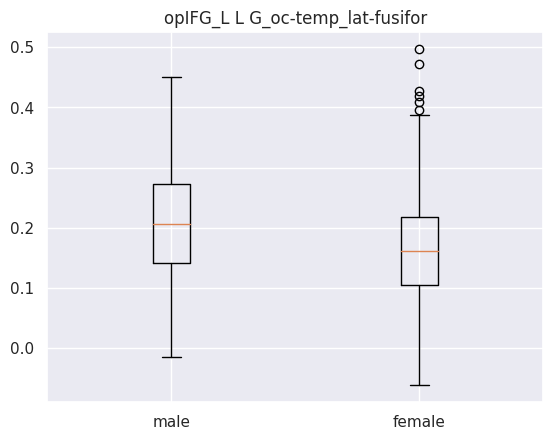

Ttest_indResult(statistic=5.698927511987025, pvalue=1.9476660856975242e-08)
male mean : 0.21165041260456274
male std : 0.09558055806544623
female mean : 0.1668287685760797
female std : 0.09071059585266414


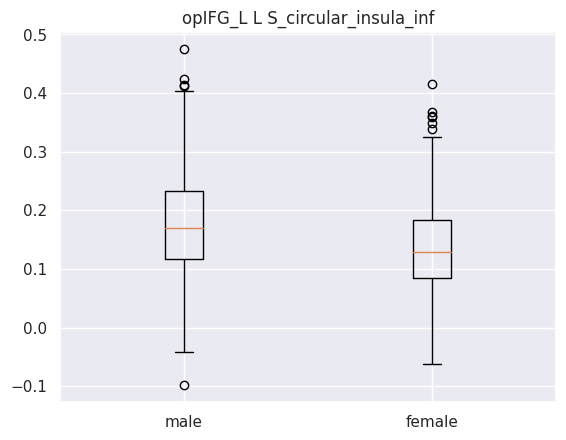

Ttest_indResult(statistic=5.793990901906812, pvalue=1.1455922176287184e-08)
male mean : 0.17968730860456272
male std : 0.08982294121388894
female mean : 0.13831419359568106
female std : 0.07945500381706048


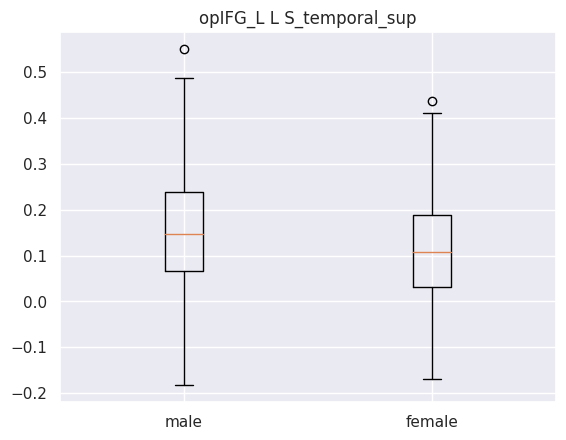

Ttest_indResult(statistic=4.104919666823164, pvalue=4.644482275203613e-05)
male mean : 0.15756035950874525
male std : 0.12779665808907587
female mean : 0.11516167434405318
female std : 0.116995762417676


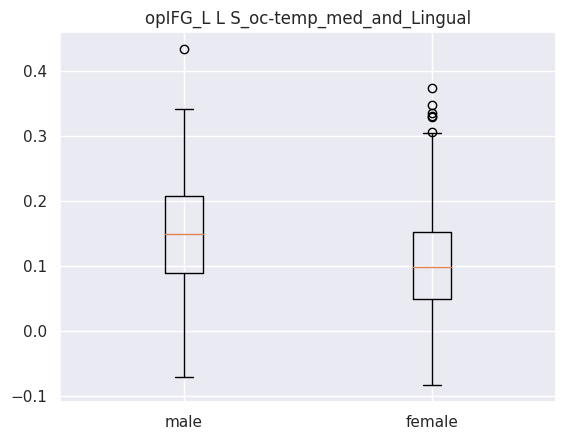

Ttest_indResult(statistic=5.979839353972038, pvalue=3.974325533230207e-09)
male mean : 0.1488611000961977
male std : 0.08275130578679875
female mean : 0.10701805680602991
female std : 0.0827545429881859


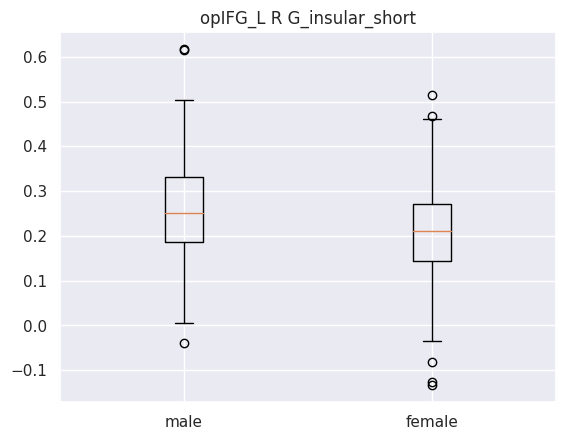

Ttest_indResult(statistic=5.4808703280162065, pvalue=6.398857490240382e-08)
male mean : 0.25729847525475286
male std : 0.10255773714008104
female mean : 0.20946871466478406
female std : 0.10376640995486473


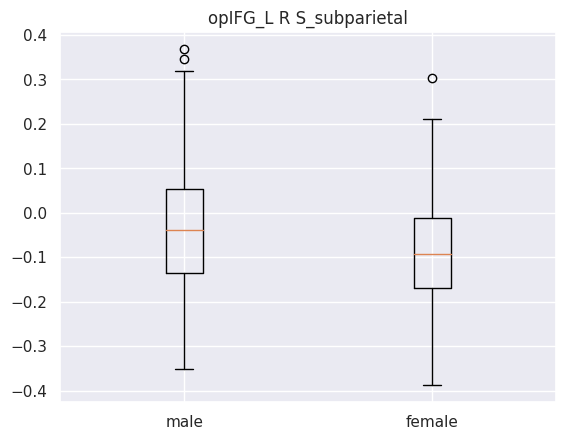

Ttest_indResult(statistic=4.627538320714266, pvalue=4.59863706792552e-06)
male mean : -0.0332647789439924
male std : 0.13808114412316164
female mean : -0.08209271020398672
female std : 0.11188499200043661


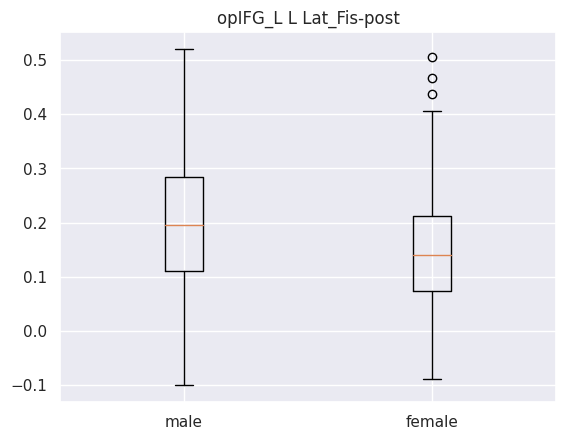

Ttest_indResult(statistic=5.935387024296681, pvalue=5.1325420089517246e-09)
male mean : 0.2050836814703422
male std : 0.11767179108479932
female mean : 0.15007587232843853
female std : 0.10203339475287607


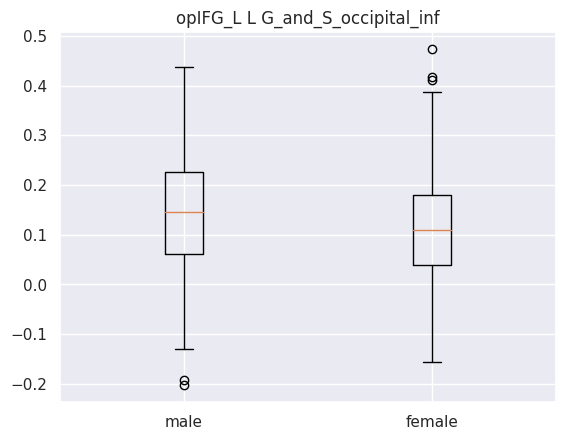

Ttest_indResult(statistic=3.3566638640413826, pvalue=0.000842207438429869)
male mean : 0.14831989778022814
male std : 0.12463081174073931
female mean : 0.11545700281893687
female std : 0.10745927496138906


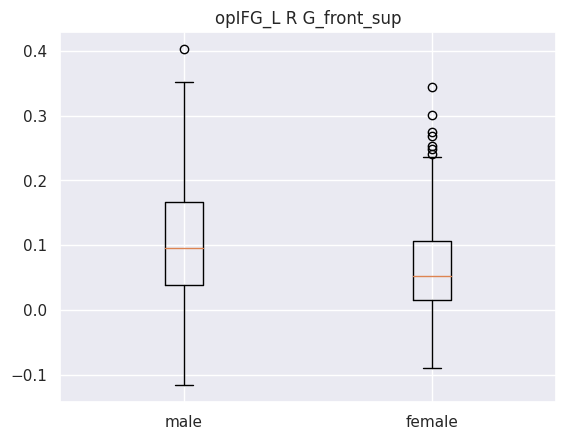

Ttest_indResult(statistic=5.683026273047372, pvalue=2.126943803812892e-08)
male mean : 0.1052475728106464
male std : 0.08960183901383532
female mean : 0.06627460454425249
female std : 0.07286902176856629


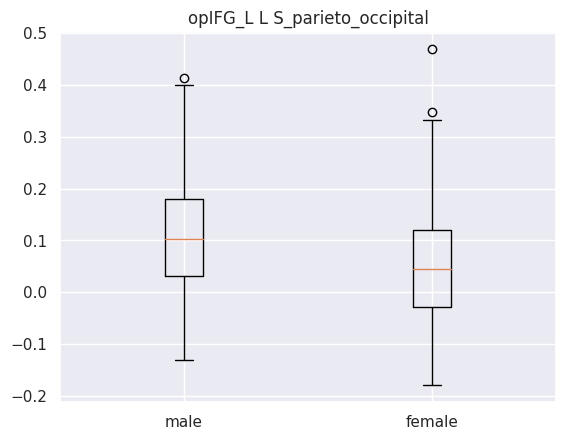

Ttest_indResult(statistic=6.503523668812626, pvalue=1.7355351061785972e-10)
male mean : 0.10978782784771862
male std : 0.10910224511601631
female mean : 0.05152286066817276
female std : 0.10312061557532284
                                  Region       Men     Women       P value
0      opIFG_L - L G_oc-temp_lat-fusifor  0.211650  0.166829  1.947666e-08
1      opIFG_L - L S_circular_insula_inf  0.179687  0.138314  1.145592e-08
2             opIFG_L - L S_temporal_sup  0.157560  0.115162  4.644482e-05
3  opIFG_L - L S_oc-temp_med_and_Lingual  0.148861  0.107018  3.974326e-09
4            opIFG_L - R G_insular_short  0.257298  0.209469  6.398857e-08
5              opIFG_L - R S_subparietal -0.033265 -0.082093  4.598637e-06
6               opIFG_L - L Lat_Fis-post  0.205084  0.150076  5.132542e-09
7      opIFG_L - L G_and_S_occipital_inf  0.148320  0.115457  8.422074e-04
8                opIFG_L - R G_front_sup  0.105248  0.066275  2.126944e-08
9        opIFG_L - L S_parieto_occipital  0.

In [63]:
rois = ["opIFG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions opIFG_R

     coefficient     seed                       labels
47      0.257032  opIFG_R      L S_circular_insula_inf
60      0.207552  opIFG_R  L S_oc-temp_med_and_Lingual
121     0.205102  opIFG_R      R S_circular_insula_inf
91      0.191789  opIFG_R            R G_insular_short
89      0.177847  opIFG_R                R G_front_sup
15      0.173893  opIFG_R                L G_front_sup
80      0.169734  opIFG_R     R G_and_S_cingul-Mid-Ant
125     0.165114  opIFG_R                R S_front_inf
108     0.164153  opIFG_R      R G_temp_sup-Plan_polar
41      0.157768  opIFG_R             L Pole_occipital
The mean accuracy : 0.8159159292035398
The standard deviation of the accuracy : 0.03799449876918694
The lower boundry of the confidance interval of the accuracy : 0.7414467116159335
The upper boundry of the confidance interval of the accuracy : 0.8903851467911462


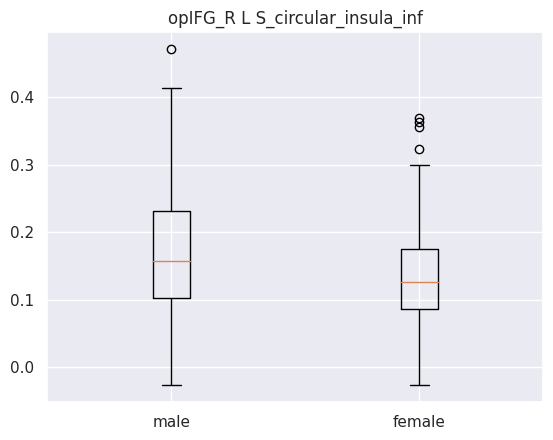

Ttest_indResult(statistic=4.729506412940881, pvalue=2.84980032551188e-06)
male mean : 0.16831194070988592
male std : 0.08857256780970121
female mean : 0.13581089123421927
female std : 0.07430472106915549


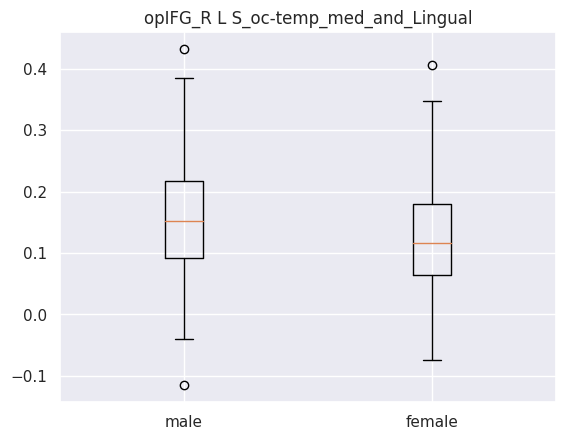

Ttest_indResult(statistic=4.683575774370304, pvalue=3.539150807108733e-06)
male mean : 0.15626952140722436
male std : 0.09076863914735202
female mean : 0.12206103295259137
female std : 0.08235156931391527


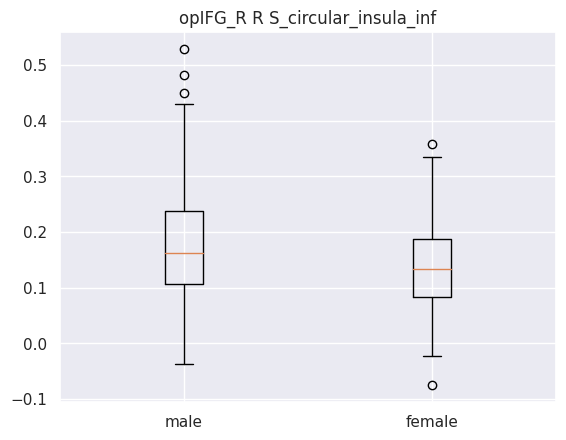

Ttest_indResult(statistic=4.942755677875544, pvalue=1.0181350777303932e-06)
male mean : 0.17446574005114068
male std : 0.09230872687485497
female mean : 0.1389954879870432
female std : 0.07778669492425484


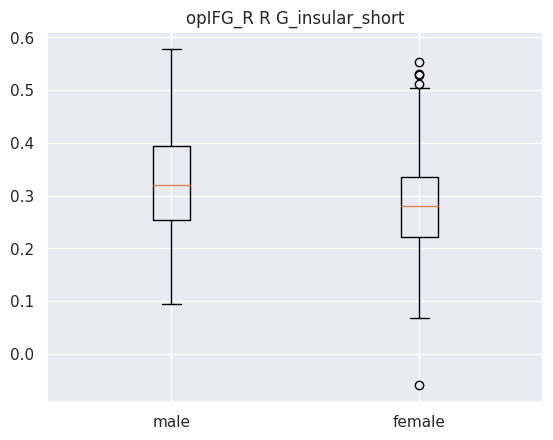

Ttest_indResult(statistic=4.755239251404364, pvalue=2.5221004207170377e-06)
male mean : 0.3230140808745247
male std : 0.09676265794418758
female mean : 0.28459807252159475
female std : 0.09446074604336126


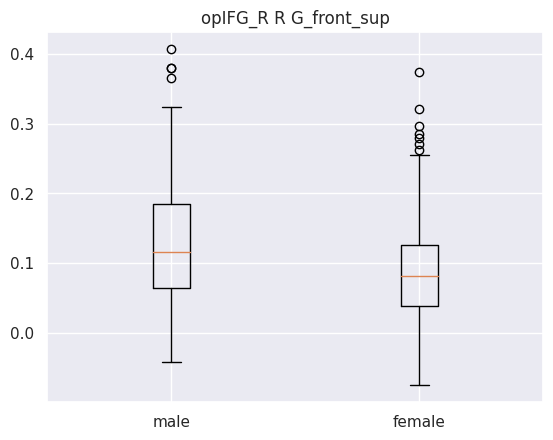

Ttest_indResult(statistic=5.745692358467039, pvalue=1.501515937789587e-08)
male mean : 0.1265730028612167
male std : 0.08260435605801614
female mean : 0.08889572881594685
female std : 0.07284917853618297


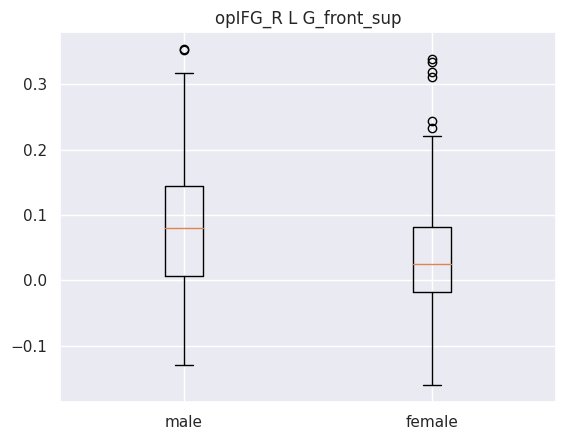

Ttest_indResult(statistic=5.840874265006819, pvalue=8.794027366847957e-09)
male mean : 0.07910377020205323
male std : 0.091464100075273
female mean : 0.03652195184581396
female std : 0.08135719231531187


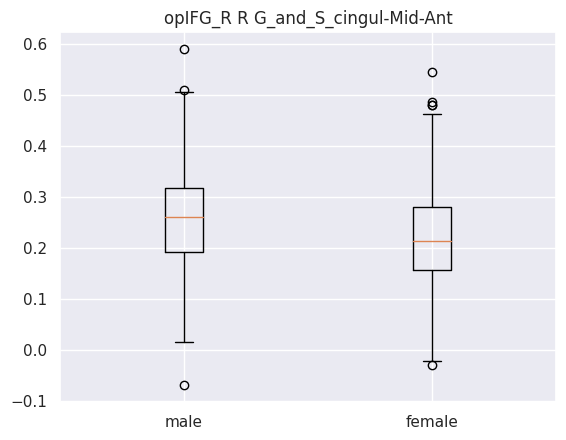

Ttest_indResult(statistic=4.315955845337449, pvalue=1.878004856996765e-05)
male mean : 0.2591957626121673
male std : 0.10347717348701288
female mean : 0.22244813224916943
female std : 0.09819716159475382


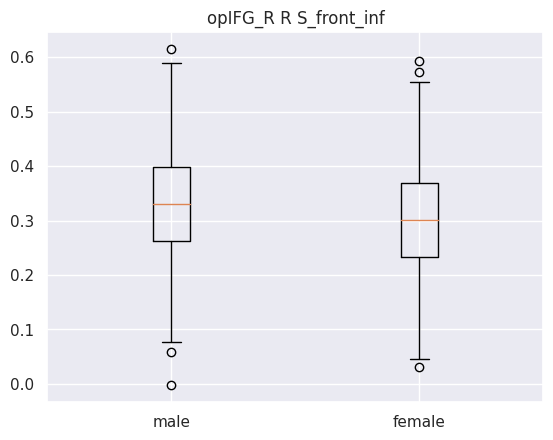

Ttest_indResult(statistic=3.5795531005665557, pvalue=0.0003739476663251471)
male mean : 0.33087263080000007
male std : 0.09831999322618676
female mean : 0.29969864851495015
female std : 0.10691152795323068


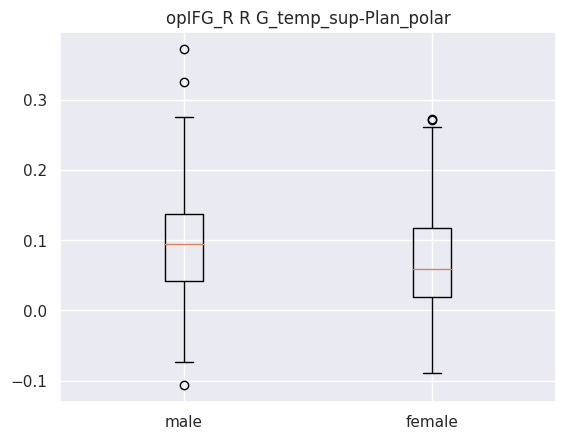

Ttest_indResult(statistic=3.998178487567644, pvalue=7.235199191609884e-05)
male mean : 0.09452694148326996
male std : 0.07617182305141224
female mean : 0.07004874881162791
female std : 0.06894506297581188


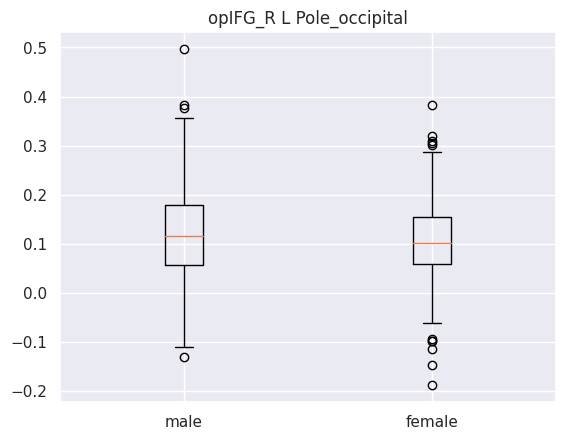

Ttest_indResult(statistic=2.2602421008901716, pvalue=0.0241880831961621)
male mean : 0.12250584151026614
male std : 0.0975005774677038
female mean : 0.10541738842285715
female std : 0.08169249239746618
                                  Region       Men     Women       P value
0      opIFG_R - L S_circular_insula_inf  0.168312  0.135811  2.849800e-06
1  opIFG_R - L S_oc-temp_med_and_Lingual  0.156270  0.122061  3.539151e-06
2      opIFG_R - R S_circular_insula_inf  0.174466  0.138995  1.018135e-06
3            opIFG_R - R G_insular_short  0.323014  0.284598  2.522100e-06
4                opIFG_R - R G_front_sup  0.126573  0.088896  1.501516e-08
5                opIFG_R - L G_front_sup  0.079104  0.036522  8.794027e-09
6     opIFG_R - R G_and_S_cingul-Mid-Ant  0.259196  0.222448  1.878005e-05
7                opIFG_R - R S_front_inf  0.330873  0.299699  3.739477e-04
8      opIFG_R - R G_temp_sup-Plan_polar  0.094527  0.070049  7.235199e-05
9             opIFG_R - L Pole_occipital  0.1225

In [64]:
rois = ["opIFG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions pITG_L

     coefficient    seed                       labels
47      0.240166  pITG_L      L S_circular_insula_inf
26      0.238076  pITG_L             L G_parietal_sup
9       0.203500  pITG_L      L G_cingul-Post-ventral
20      0.200224  pITG_L      L G_oc-temp_lat-fusifor
55      0.181368  pITG_L  L S_intrapariet_and_P_trans
83      0.172106  pITG_L      R G_cingul-Post-ventral
75      0.167198  pITG_L      R G_and_S_occipital_inf
125     0.164939  pITG_L                R S_front_inf
60      0.154554  pITG_L  L S_oc-temp_med_and_Lingual
86      0.153020  pITG_L        R G_front_inf-Orbital
The mean accuracy : 0.8111796460176992
The standard deviation of the accuracy : 0.03836824951793555
The lower boundry of the confidance interval of the accuracy : 0.7359778769625456
The upper boundry of the confidance interval of the accuracy : 0.8863814150728528


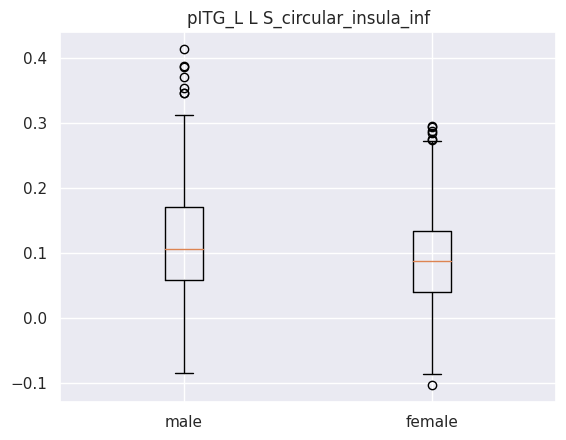

Ttest_indResult(statistic=3.7195183926587134, pvalue=0.00021963865781551026)
male mean : 0.1174053472373384
male std : 0.08606189513888665
female mean : 0.09239644204584717
female std : 0.07332099633027676


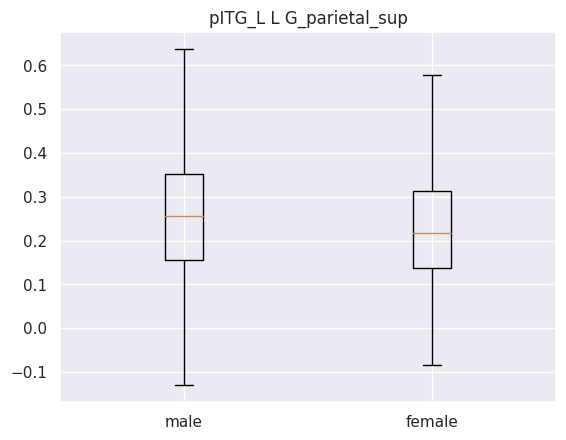

Ttest_indResult(statistic=2.0348237485458296, pvalue=0.04233743219572547)
male mean : 0.25056911626197714
male std : 0.14008685738222976
female mean : 0.22777261343820598
female std : 0.1254813999066985


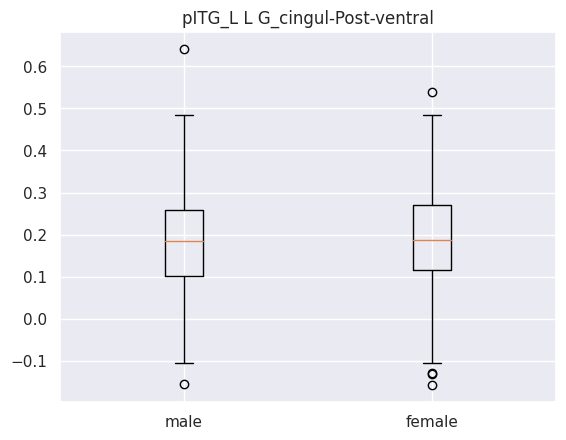

Ttest_indResult(statistic=-0.6639053665916427, pvalue=0.5070231460745944)
male mean : 0.18444210613802278
male std : 0.11264807940923946
female mean : 0.19087066787209303
female std : 0.11611943916831628


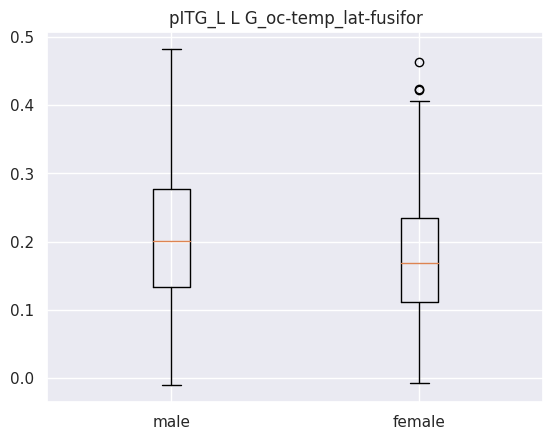

Ttest_indResult(statistic=3.2436073154022718, pvalue=0.001250320411852697)
male mean : 0.2056987803380228
male std : 0.0949520263388171
female mean : 0.18023744266279068
female std : 0.09094138289806177


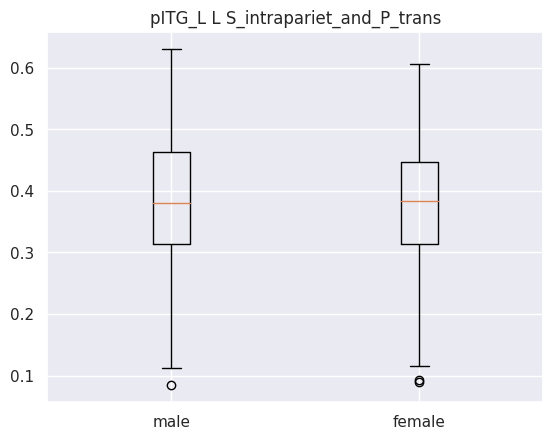

Ttest_indResult(statistic=0.27040597084376106, pvalue=0.7869472193855935)
male mean : 0.38125740577946765
male std : 0.107535777846271
female mean : 0.37889768367441856
female std : 0.0992636491621393


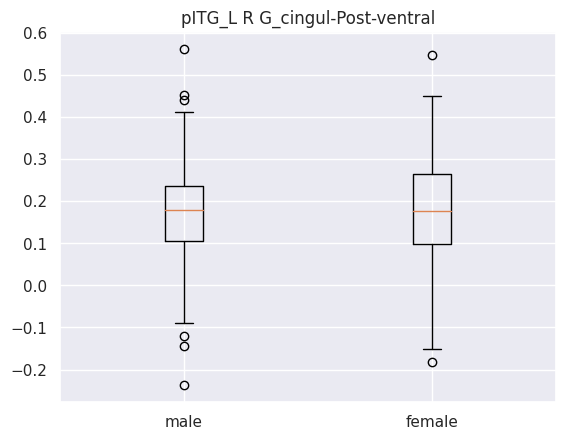

Ttest_indResult(statistic=-0.7087886870276421, pvalue=0.47874952082168243)
male mean : 0.17141985658456652
male std : 0.11182081650600385
female mean : 0.17828767616757477
female std : 0.11695861702316826


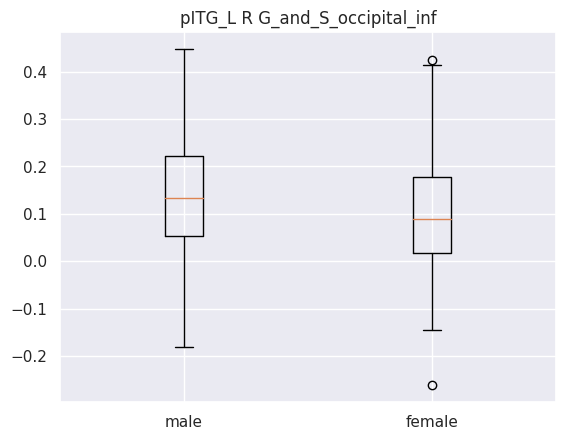

Ttest_indResult(statistic=3.1426765548050595, pvalue=0.0017623399666327859)
male mean : 0.13541462136387833
male std : 0.12025345869257073
female mean : 0.10348527198348836
female std : 0.12006823679231758


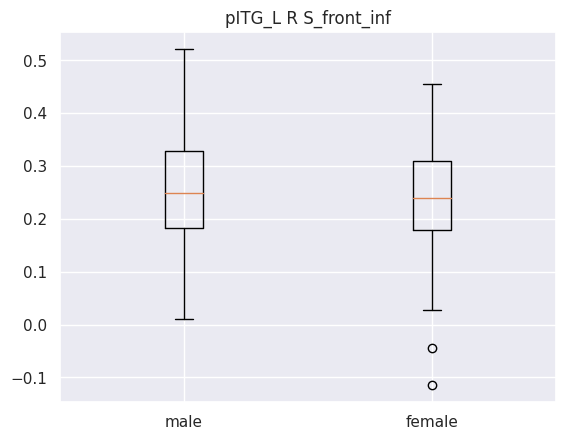

Ttest_indResult(statistic=2.0737617244228934, pvalue=0.0385563187021098)
male mean : 0.25845339727756655
male std : 0.09789218472922548
female mean : 0.24180414809966774
female std : 0.09229872422717747


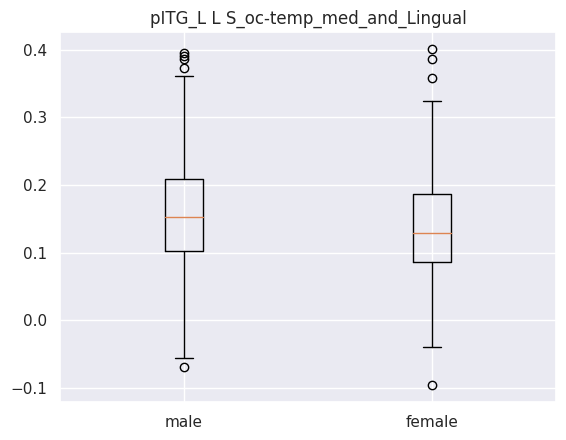

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
male std : 0.08334523805349907
female mean : 0.13959590949933556
female std : 0.07802101521527612


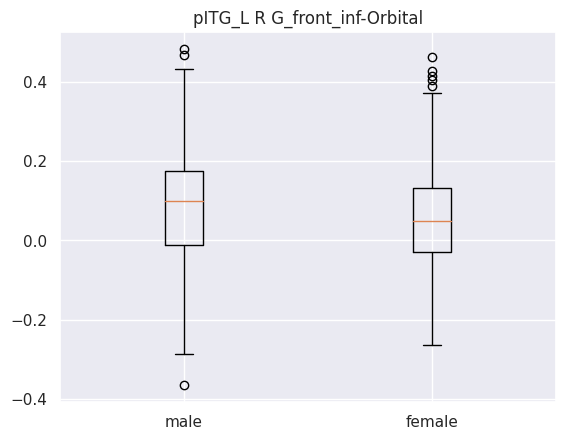

Ttest_indResult(statistic=2.4606260312415023, pvalue=0.014169135796902566)
male mean : 0.08827093163688214
male std : 0.14230262222275855
female mean : 0.05931472846877077
female std : 0.13637430223397143
                                 Region       Men     Women   P value
0      pITG_L - L S_circular_insula_inf  0.117405  0.092396  0.000220
1             pITG_L - L G_parietal_sup  0.250569  0.227773  0.042337
2      pITG_L - L G_cingul-Post-ventral  0.184442  0.190871  0.507023
3      pITG_L - L G_oc-temp_lat-fusifor  0.205699  0.180237  0.001250
4  pITG_L - L S_intrapariet_and_P_trans  0.381257  0.378898  0.786947
5      pITG_L - R G_cingul-Post-ventral  0.171420  0.178288  0.478750
6      pITG_L - R G_and_S_occipital_inf  0.135415  0.103485  0.001762
7                pITG_L - R S_front_inf  0.258453  0.241804  0.038556
8  pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  0.002643
9        pITG_L - R G_front_inf-Orbital  0.088271  0.059315  0.014169


In [65]:
rois = ["pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions pITG_R

     coefficient    seed                   labels
20      0.268079  pITG_R  L G_oc-temp_lat-fusifor
72      0.258256  pITG_R         L S_temporal_sup
83      0.229686  pITG_R  R G_cingul-Post-ventral
47      0.206474  pITG_R  L S_circular_insula_inf
84      0.189709  pITG_R               R G_cuneus
108     0.172699  pITG_R  R G_temp_sup-Plan_polar
125     0.172169  pITG_R            R S_front_inf
106     0.160596  pITG_R  R G_temp_sup-G_T_transv
91      0.157899  pITG_R        R G_insular_short
144     0.157739  pITG_R          R S_subparietal
The mean accuracy : 0.8024017699115045
The standard deviation of the accuracy : 0.038776032628394415
The lower boundry of the confidance interval of the accuracy : 0.7264007459598514
The upper boundry of the confidance interval of the accuracy : 0.8784027938631576


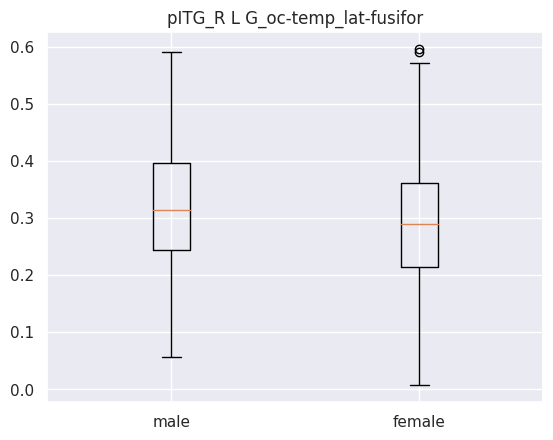

Ttest_indResult(statistic=2.810268986820924, pvalue=0.0051225200608808474)
male mean : 0.31478116888212926
male std : 0.11000102327816882
female mean : 0.2893303569966777
female std : 0.10450615876501394


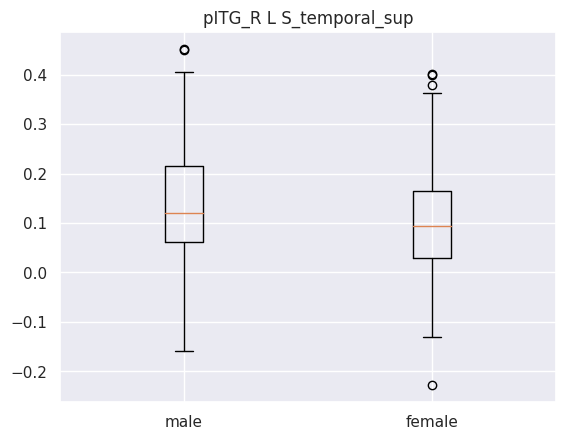

Ttest_indResult(statistic=4.196741356631083, pvalue=3.1469933747888905e-05)
male mean : 0.13739067075551334
male std : 0.11150382462376025
female mean : 0.09954083086165548
female std : 0.10224021375654369


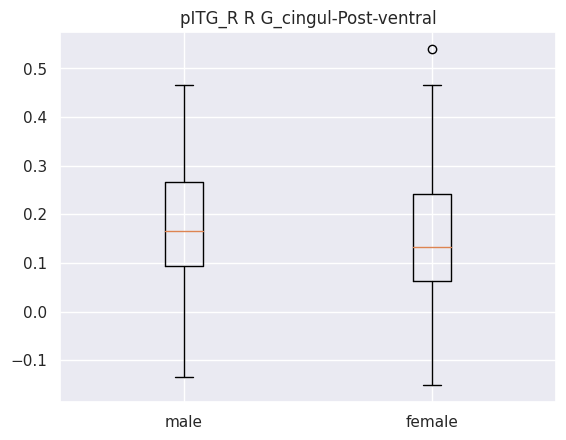

Ttest_indResult(statistic=2.256297345157703, pvalue=0.024435481782569664)
male mean : 0.1744766429752852
male std : 0.12132968449125979
female mean : 0.15124980597607973
female std : 0.12210294696125819


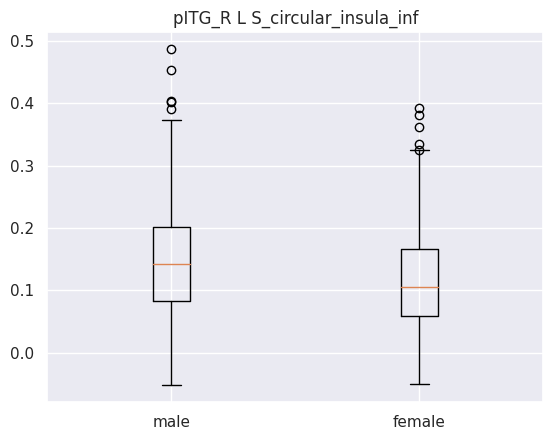

Ttest_indResult(statistic=4.781913144179267, pvalue=2.220814202786064e-06)
male mean : 0.15037180967528518
male std : 0.09196590825401321
female mean : 0.1155669789617608
female std : 0.08058036286207322


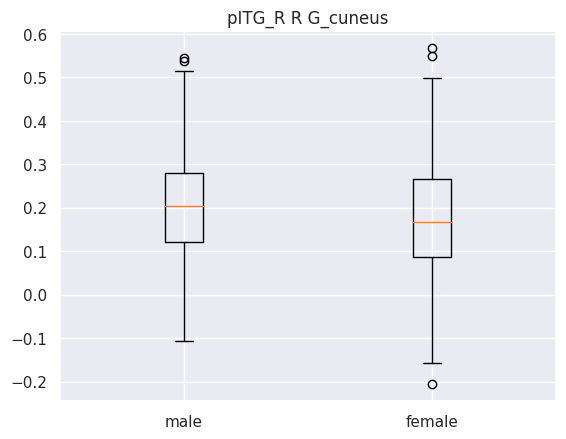

Ttest_indResult(statistic=2.741944633725931, pvalue=0.006302259674511262)
male mean : 0.20491106910646387
male std : 0.1253061895987554
female mean : 0.17536686928538206
female std : 0.12925281281347495


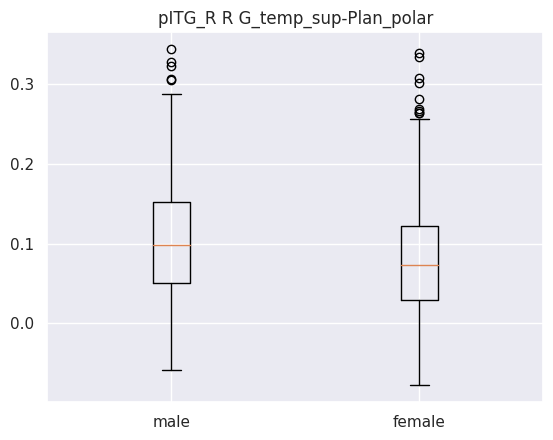

Ttest_indResult(statistic=3.829041740563084, pvalue=0.00014311201699602173)
male mean : 0.10721168719125476
male std : 0.07701199955956235
female mean : 0.08294021107918272
female std : 0.07312878001906238


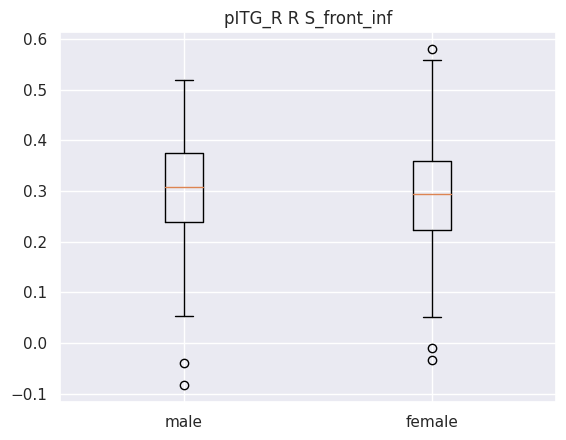

Ttest_indResult(statistic=1.6379189328233394, pvalue=0.10199833222671245)
male mean : 0.3043051077718631
male std : 0.0983610871491745
female mean : 0.29073446122923585
female std : 0.09765466159601431


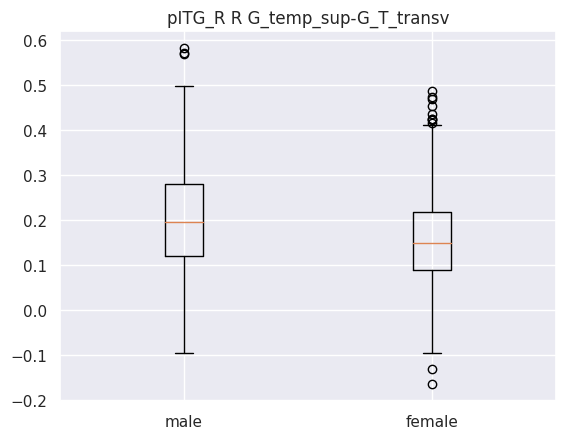

Ttest_indResult(statistic=4.858246945744738, pvalue=1.5379842834630926e-06)
male mean : 0.20724551101216732
male std : 0.12132483078283902
female mean : 0.16001330873255815
female std : 0.10912756866493428


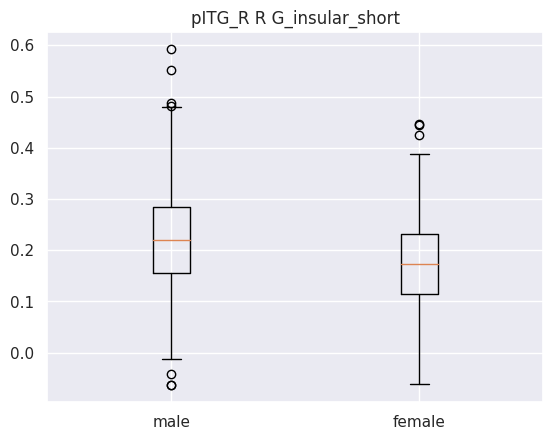

Ttest_indResult(statistic=5.697103263903745, pvalue=1.9674615344309902e-08)
male mean : 0.2223536750768061
male std : 0.10572708474473759
female mean : 0.1753717551358804
female std : 0.08975183305485177


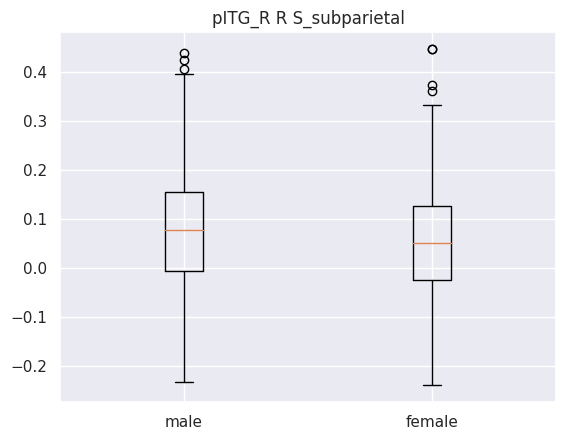

Ttest_indResult(statistic=2.373555580211466, pvalue=0.01795294789038577)
male mean : 0.08108263206159695
male std : 0.1272016237473174
female mean : 0.05675384893664452
female std : 0.11573903683180534
                             Region       Men     Women       P value
0  pITG_R - L G_oc-temp_lat-fusifor  0.314781  0.289330  5.122520e-03
1         pITG_R - L S_temporal_sup  0.137391  0.099541  3.146993e-05
2  pITG_R - R G_cingul-Post-ventral  0.174477  0.151250  2.443548e-02
3  pITG_R - L S_circular_insula_inf  0.150372  0.115567  2.220814e-06
4               pITG_R - R G_cuneus  0.204911  0.175367  6.302260e-03
5  pITG_R - R G_temp_sup-Plan_polar  0.107212  0.082940  1.431120e-04
6            pITG_R - R S_front_inf  0.304305  0.290734  1.019983e-01
7  pITG_R - R G_temp_sup-G_T_transv  0.207246  0.160013  1.537984e-06
8        pITG_R - R G_insular_short  0.222354  0.175372  1.967462e-08
9          pITG_R - R S_subparietal  0.081083  0.056754  1.795295e-02


In [34]:
rois = ["pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions planumtemp_L

     coefficient          seed                       labels
60      0.318987  planumtemp_L  L S_oc-temp_med_and_Lingual
20      0.221324  planumtemp_L      L G_oc-temp_lat-fusifor
108     0.205293  planumtemp_L      R G_temp_sup-Plan_polar
15      0.204476  planumtemp_L                L G_front_sup
94      0.177732  planumtemp_L      R G_oc-temp_lat-fusifor
43      0.171312  planumtemp_L                L S_calcarine
99      0.168395  planumtemp_L      R G_pariet_inf-Supramar
89      0.163267  planumtemp_L                R G_front_sup
88      0.162727  planumtemp_L             R G_front_middle
30      0.156225  planumtemp_L                   L G_rectus
The mean accuracy : 0.8016619469026549
The standard deviation of the accuracy : 0.03884471028280589
The lower boundry of the confidance interval of the accuracy : 0.7255263147483554
The upper boundry of the confidance interval of the accuracy : 0.8777975790569544


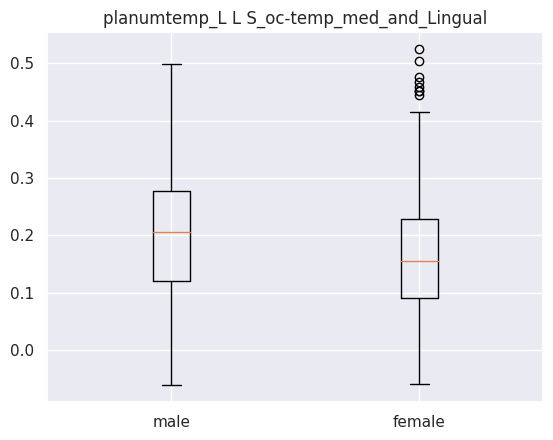

Ttest_indResult(statistic=3.5535200840172108, pvalue=0.0004120710964530877)
male mean : 0.20138468446653993
male std : 0.10697193315909369
female mean : 0.1691071645282392
female std : 0.10781293661679399


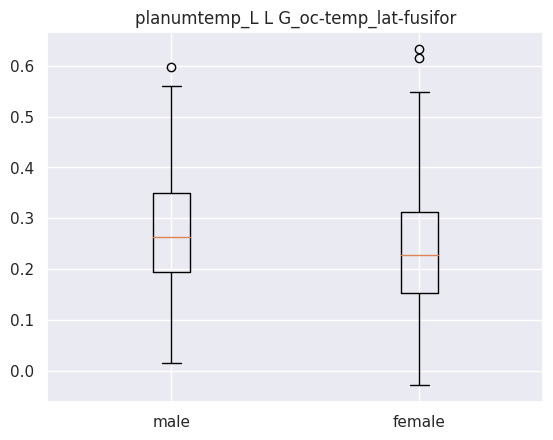

Ttest_indResult(statistic=3.8640363181268467, pvalue=0.00012453051309743143)
male mean : 0.273934721608365
male std : 0.11618899538515358
female mean : 0.23664216192325582
female std : 0.11231573519663951


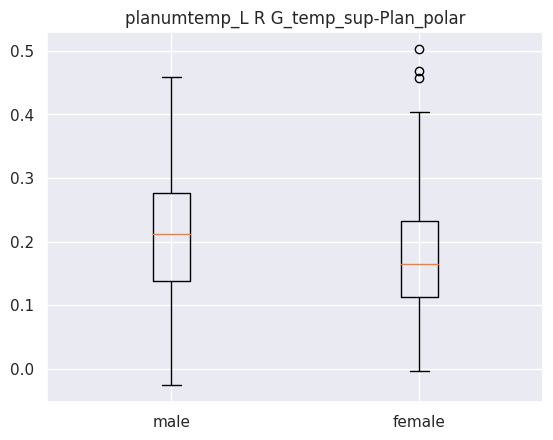

Ttest_indResult(statistic=4.754095906522838, pvalue=2.535856882720888e-06)
male mean : 0.2124789285969582
male std : 0.09186190010679225
female mean : 0.1759663873843854
female std : 0.08991669369361606


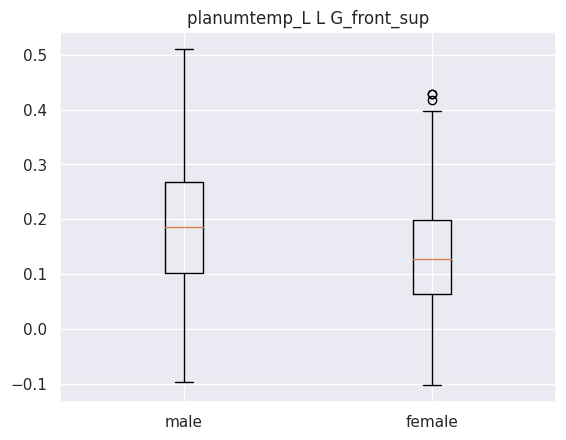

Ttest_indResult(statistic=5.407175582759948, pvalue=9.480994088922564e-08)
male mean : 0.1847222246946768
male std : 0.10853704509636099
female mean : 0.1378197862071096
female std : 0.0970820399251973


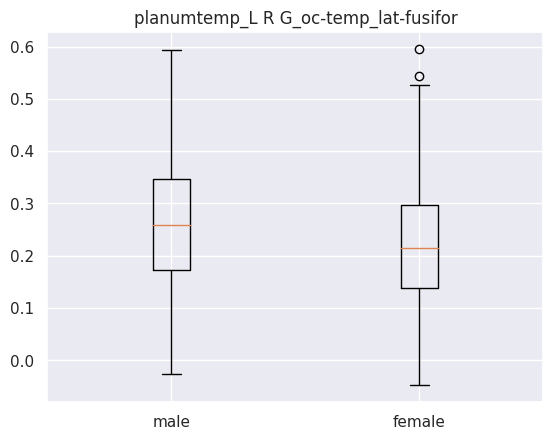

Ttest_indResult(statistic=3.691296784762628, pvalue=0.00024485362854647204)
male mean : 0.26207624817110264
male std : 0.11851119925720778
female mean : 0.22636467401827245
female std : 0.1107105284122811


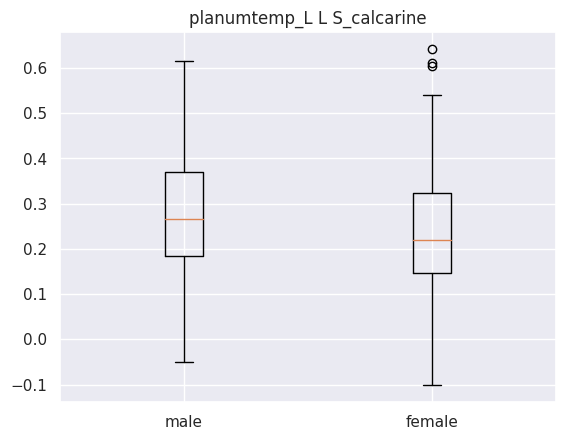

Ttest_indResult(statistic=3.141316233107298, pvalue=0.001770403211946406)
male mean : 0.274296150904943
male std : 0.1280515167012644
female mean : 0.2400809567398671
female std : 0.12947348397677685


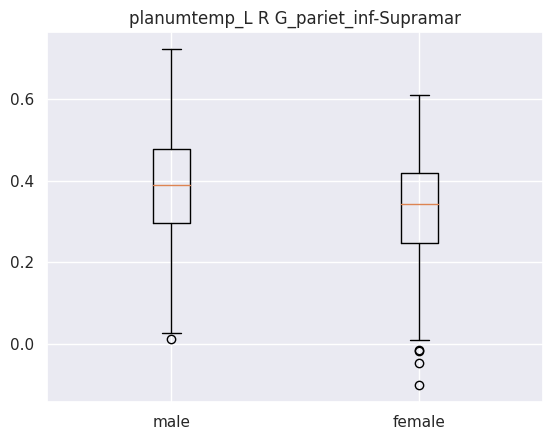

Ttest_indResult(statistic=4.712576838267088, pvalue=3.0873356981406085e-06)
male mean : 0.38310964460076047
male std : 0.13313561747450714
female mean : 0.3312813015614618
female std : 0.12732063243807878


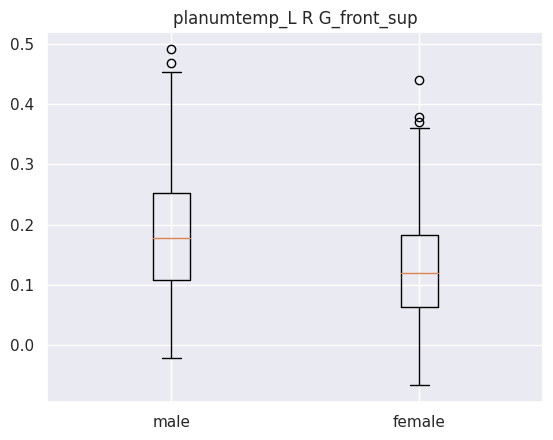

Ttest_indResult(statistic=7.005723286524496, pvalue=7.053092520728604e-12)
male mean : 0.1842207737676046
male std : 0.09752786905164766
female mean : 0.12974268123255814
female std : 0.08681164436850244


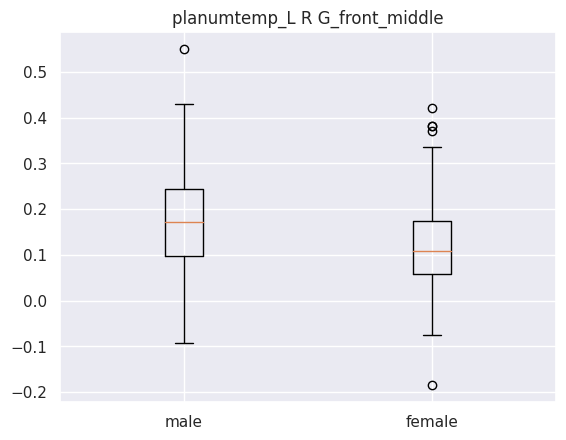

Ttest_indResult(statistic=7.083051952003173, pvalue=4.234418336006045e-12)
male mean : 0.17561467015703422
male std : 0.10099648809567767
female mean : 0.11818345196269103
female std : 0.09119635254658147


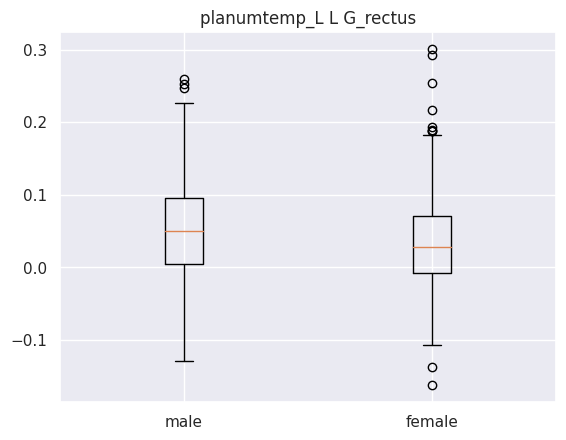

Ttest_indResult(statistic=2.7512545363189393, pvalue=0.006128244861950536)
male mean : 0.05109769466604562
male std : 0.07154061416307267
female mean : 0.035068776211362125
female std : 0.06650833816517755
                                       Region       Men     Women  \
0  planumtemp_L - L S_oc-temp_med_and_Lingual  0.201385  0.169107   
1      planumtemp_L - L G_oc-temp_lat-fusifor  0.273935  0.236642   
2      planumtemp_L - R G_temp_sup-Plan_polar  0.212479  0.175966   
3                planumtemp_L - L G_front_sup  0.184722  0.137820   
4      planumtemp_L - R G_oc-temp_lat-fusifor  0.262076  0.226365   
5                planumtemp_L - L S_calcarine  0.274296  0.240081   
6      planumtemp_L - R G_pariet_inf-Supramar  0.383110  0.331281   
7                planumtemp_L - R G_front_sup  0.184221  0.129743   
8             planumtemp_L - R G_front_middle  0.175615  0.118183   
9                   planumtemp_L - L G_rectus  0.051098  0.035069   

        P value  
0  4.120711e-04 

In [35]:
rois = ["planumtemp_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions planumtemp_R

     coefficient          seed                       labels
47      0.258000  planumtemp_R      L S_circular_insula_inf
108     0.250284  planumtemp_R      R G_temp_sup-Plan_polar
60      0.236093  planumtemp_R  L S_oc-temp_med_and_Lingual
43      0.220355  planumtemp_R                L S_calcarine
15      0.206736  planumtemp_R                L G_front_sup
72      0.192519  planumtemp_R             L S_temporal_sup
121     0.173699  planumtemp_R      R S_circular_insula_inf
139     0.170760  planumtemp_R             R S_pericallosal
58      0.151122  planumtemp_R            L S_occipital_ant
20      0.148373  planumtemp_R      L G_oc-temp_lat-fusifor
The mean accuracy : 0.7947115044247788
The standard deviation of the accuracy : 0.03976175647254694
The lower boundry of the confidance interval of the accuracy : 0.7167784617385868
The upper boundry of the confidance interval of the accuracy : 0.8726445471109707


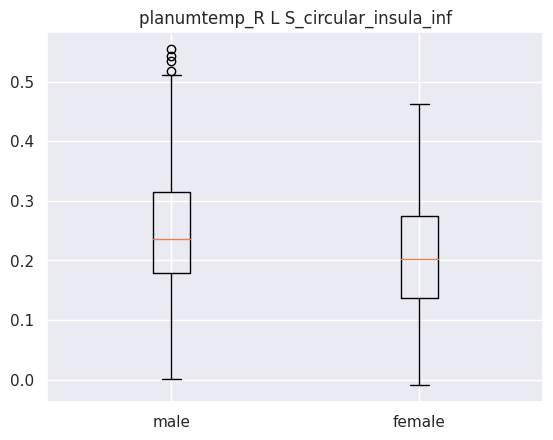

Ttest_indResult(statistic=4.754592848867569, pvalue=2.5298689374709147e-06)
male mean : 0.24664524678136882
male std : 0.09996404948497183
female mean : 0.20796517266445183
female std : 0.09280734872241128


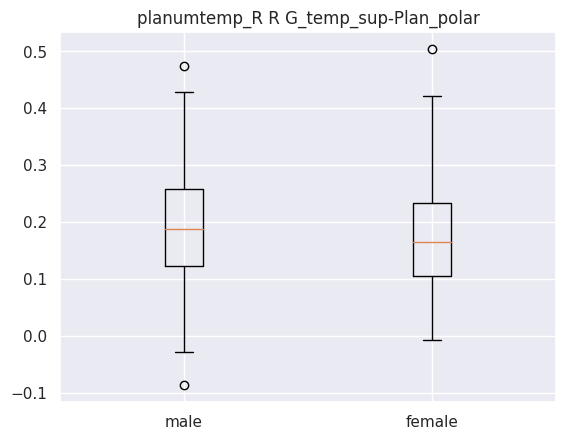

Ttest_indResult(statistic=2.321906417293724, pvalue=0.02059447944633167)
male mean : 0.19231692340304182
male std : 0.09008408764482337
female mean : 0.17497604091495014
female std : 0.08675608750582152


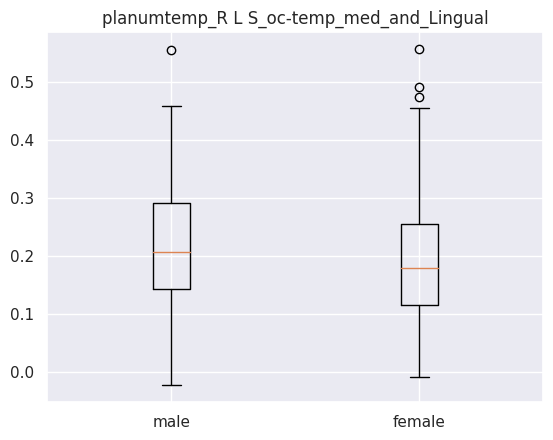

Ttest_indResult(statistic=2.8830998134021852, pvalue=0.004088548964724054)
male mean : 0.21623359568707226
male std : 0.10598136025556922
female mean : 0.1909124683142857
female std : 0.10198184189373703


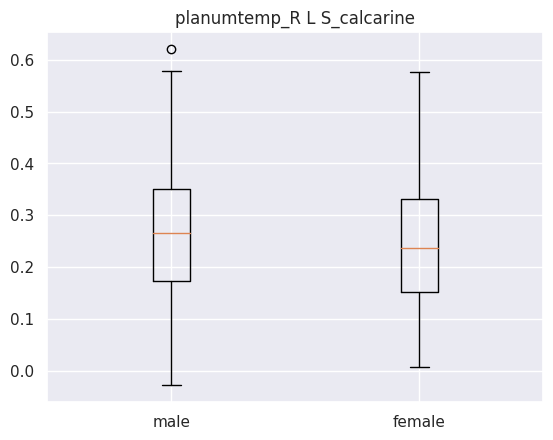

Ttest_indResult(statistic=2.002991768199032, pvalue=0.045657919237324006)
male mean : 0.26823541858505706
male std : 0.12784499132396293
female mean : 0.24731367291561462
female std : 0.11963048968200794


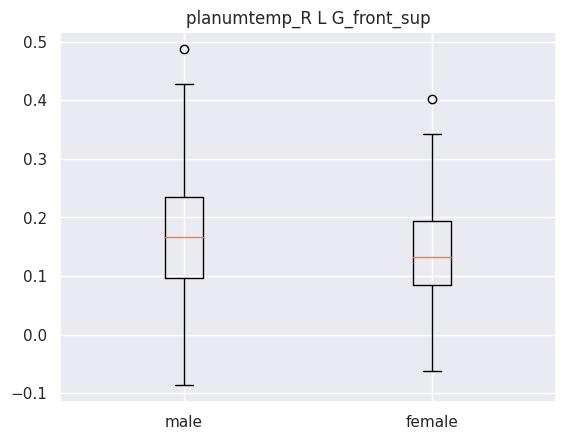

Ttest_indResult(statistic=3.245882136071958, pvalue=0.0012405568276112682)
male mean : 0.16498520389163499
male std : 0.09957579450944844
female mean : 0.1399915779053156
female std : 0.08291453993537845


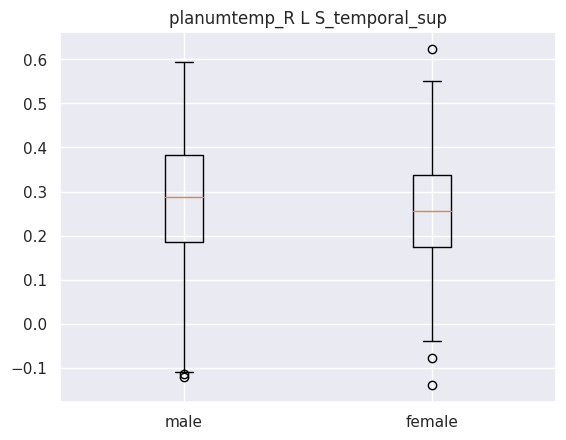

Ttest_indResult(statistic=1.9939713075469714, pvalue=0.04663794806816013)
male mean : 0.27949129047262355
male std : 0.13856078867444266
female mean : 0.2574814225966777
female std : 0.1231077975974857


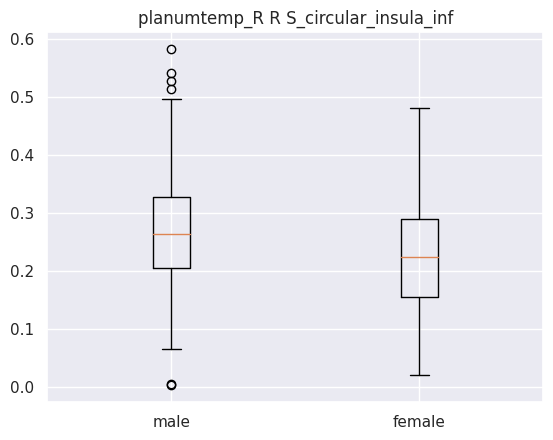

Ttest_indResult(statistic=4.926397277096471, pvalue=1.103284155465702e-06)
male mean : 0.2661869187410647
male std : 0.09527302507599171
female mean : 0.22700655812956813
female std : 0.09298067524697533


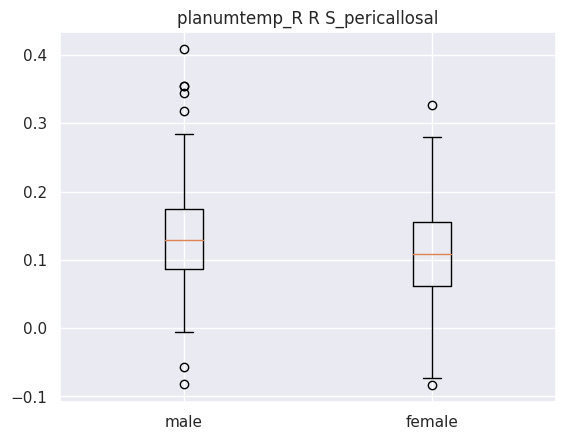

Ttest_indResult(statistic=4.21027853272709, pvalue=2.969654392292594e-05)
male mean : 0.13301439208163496
male std : 0.07336478835843015
female mean : 0.1079359846166113
female std : 0.06778752300317713


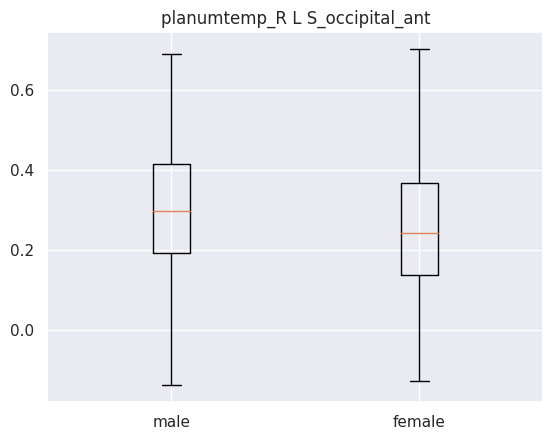

Ttest_indResult(statistic=3.428455086580389, pvalue=0.000651502448703635)
male mean : 0.2995649025620913
male std : 0.16165035751789086
female mean : 0.25357602423322256
female std : 0.1559564399420219


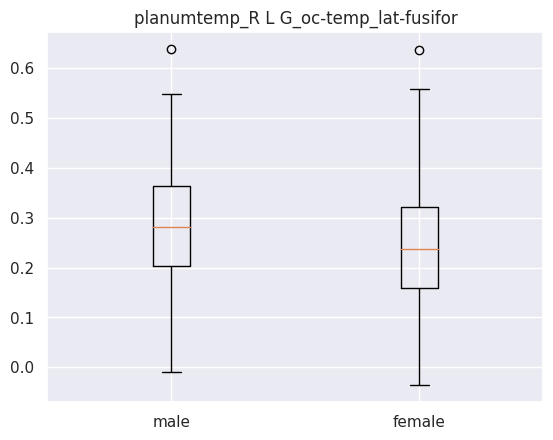

Ttest_indResult(statistic=4.153958282783595, pvalue=3.77618536555217e-05)
male mean : 0.28594790805589354
male std : 0.11929345196444417
female mean : 0.24477274405647842
female std : 0.11538894637809151
                                       Region       Men     Women   P value
0      planumtemp_R - L S_circular_insula_inf  0.246645  0.207965  0.000003
1      planumtemp_R - R G_temp_sup-Plan_polar  0.192317  0.174976  0.020594
2  planumtemp_R - L S_oc-temp_med_and_Lingual  0.216234  0.190912  0.004089
3                planumtemp_R - L S_calcarine  0.268235  0.247314  0.045658
4                planumtemp_R - L G_front_sup  0.164985  0.139992  0.001241
5             planumtemp_R - L S_temporal_sup  0.279491  0.257481  0.046638
6      planumtemp_R - R S_circular_insula_inf  0.266187  0.227007  0.000001
7             planumtemp_R - R S_pericallosal  0.133014  0.107936  0.000030
8            planumtemp_R - L S_occipital_ant  0.299565  0.253576  0.000652
9      planumtemp_R - L G_oc-temp_la

In [36]:
rois = ["planumtemp_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions for all left seeds

     coefficient     seed                       labels
98      0.129544  opIFG_L       R G_pariet_inf-Angular
55      0.113597  opIFG_L  L S_intrapariet_and_P_trans
322     0.113110   aMTG_L             L G_parietal_sup
53      0.111013  opIFG_L                L S_front_sup
504     0.102529   pITG_L  L S_oc-temp_med_and_Lingual
66      0.092603  opIFG_L              L S_postcentral
460     0.092465   pITG_L    L G_Ins_lg_and_S_cent_ins
135     0.091490  opIFG_L          R S_orbital_lateral
421     0.082751   aMTG_L                R S_front_inf
351     0.082314   aMTG_L  L S_intrapariet_and_P_trans
The mean accuracy : 0.9100008849557522
The standard deviation of the accuracy : 0.02859329420494401
The lower boundry of the confidance interval of the accuracy : 0.8539580283140619
The upper boundry of the confidance interval of the accuracy : 0.9660437415974424


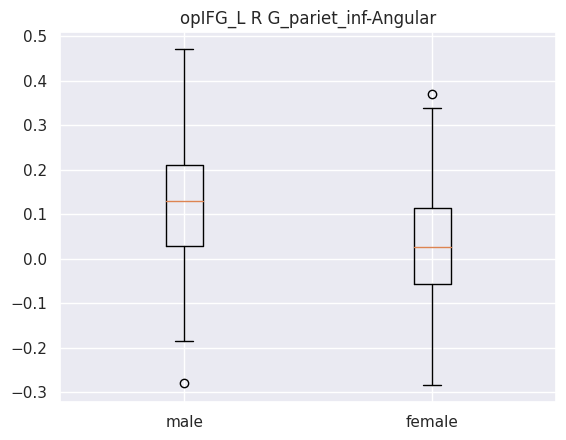

Ttest_indResult(statistic=7.716695110055561, pvalue=5.480751648776057e-14)
male mean : 0.11766997985152092
female mean : 0.03601953544850498


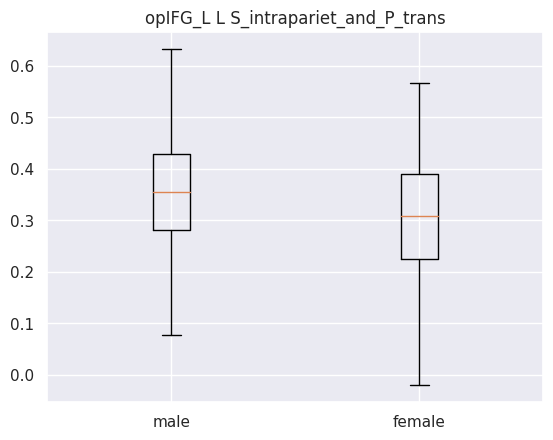

Ttest_indResult(statistic=5.055350828931209, pvalue=5.821781911163281e-07)
male mean : 0.35213074777946773
female mean : 0.3031099729109635


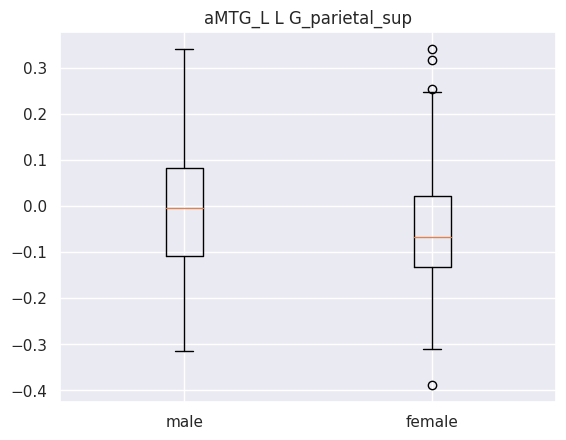

Ttest_indResult(statistic=4.059890719730225, pvalue=5.606265792321045e-05)
male mean : -0.006850357185019011
female mean : -0.05038483464086378


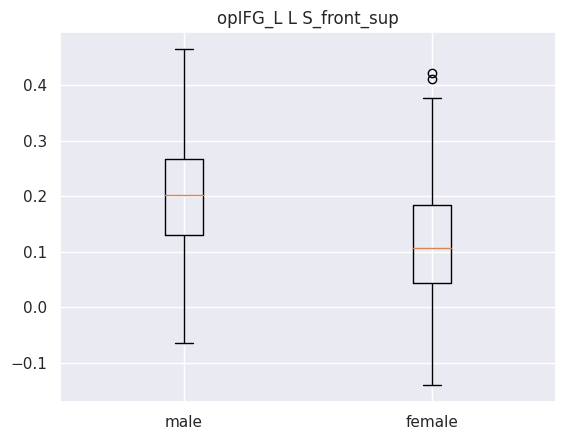

Ttest_indResult(statistic=10.006029115486237, pvalue=8.422510097736992e-22)
male mean : 0.1996858131581749
female mean : 0.11606861896099667


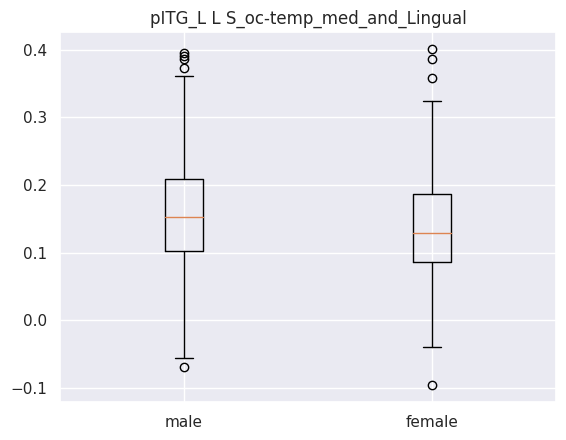

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
female mean : 0.13959590949933556


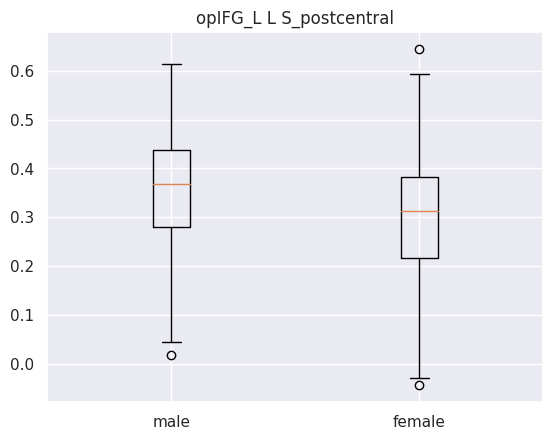

Ttest_indResult(statistic=6.164168782870945, pvalue=1.3532257302585482e-09)
male mean : 0.36117898896577944
female mean : 0.29792533494119594


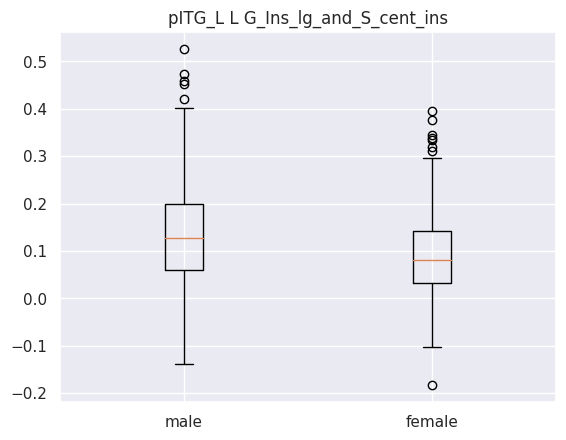

Ttest_indResult(statistic=5.375595899137657, pvalue=1.1205421040305568e-07)
male mean : 0.13588157877680607
female mean : 0.09083962553239203


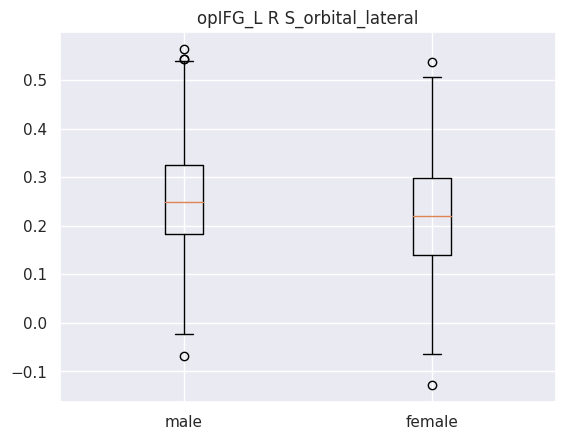

Ttest_indResult(statistic=3.4854763518784595, pvalue=0.0005296037092508647)
male mean : 0.2535425955125475
female mean : 0.2189224686335548


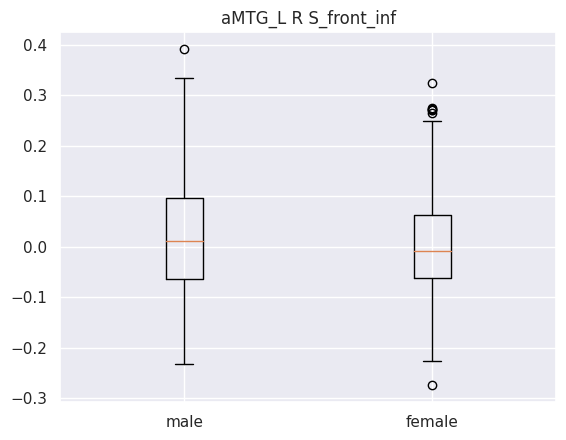

Ttest_indResult(statistic=1.520196297164563, pvalue=0.12902402830858953)
male mean : 0.01492980324942966
female mean : 0.0012906573921926926


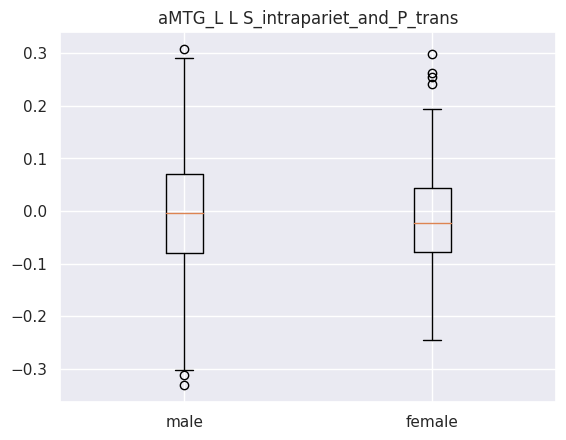

Ttest_indResult(statistic=0.9647641183387371, pvalue=0.3350779189775276)
male mean : -0.004121455086692014
female mean : -0.012516677279534883
                                  Region       Men     Women       P value
0       opIFG_L - R G_pariet_inf-Angular  0.117670  0.036020  5.480752e-14
1  opIFG_L - L S_intrapariet_and_P_trans  0.352131  0.303110  5.821782e-07
2              aMTG_L - L G_parietal_sup -0.006850 -0.050385  5.606266e-05
3                opIFG_L - L S_front_sup  0.199686  0.116069  8.422510e-22
4   pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  2.643129e-03
5              opIFG_L - L S_postcentral  0.361179  0.297925  1.353226e-09
6     pITG_L - L G_Ins_lg_and_S_cent_ins  0.135882  0.090840  1.120542e-07
7          opIFG_L - R S_orbital_lateral  0.253543  0.218922  5.296037e-04
8                 aMTG_L - R S_front_inf  0.014930  0.001291  1.290240e-01
9   aMTG_L - L S_intrapariet_and_P_trans -0.004121 -0.012517  3.350779e-01


In [154]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_left)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions of all right seeds

     coefficient          seed                       labels
487     0.118662        pITG_R                L S_calcarine
504     0.105718        pITG_R  L S_oc-temp_med_and_Lingual
90      0.102234       opIFG_R    R G_Ins_lg_and_S_cent_ins
66      0.101487       opIFG_R              L S_postcentral
22      0.101259       opIFG_R      L G_oc-temp_med-Parahip
421     0.101095        aMTG_R                R S_front_inf
231     0.100313  planumtemp_R      R G_cingul-Post-ventral
459     0.100124        pITG_R                L G_front_sup
440     0.099942        aMTG_R              R S_subparietal
343     0.098722        aMTG_R      L S_circular_insula_inf
The mean accuracy : 0.8987194690265485
The standard deviation of the accuracy : 0.030543593531264734
The lower boundry of the confidance interval of the accuracy : 0.8388540257052697
The upper boundry of the confidance interval of the accuracy : 0.9585849123478274


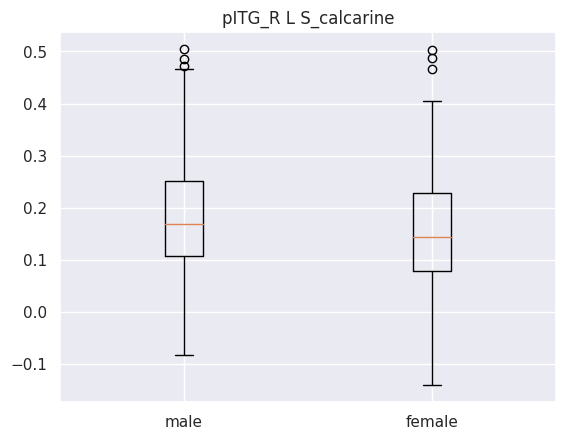

Ttest_indResult(statistic=3.2351347094550422, pvalue=0.0012873143650390924)
male mean : 0.18480961091102663
female mean : 0.1554359898385382


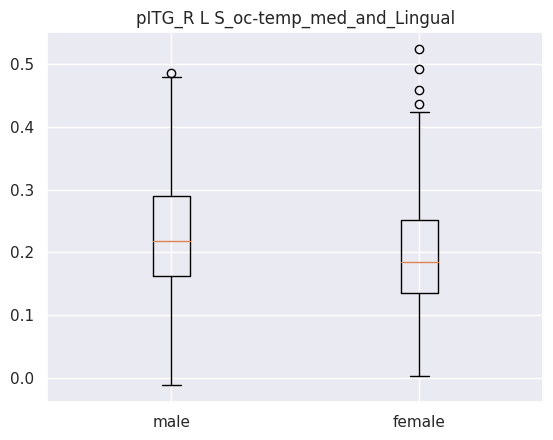

Ttest_indResult(statistic=3.658497216134596, pvalue=0.00027757468582203013)
male mean : 0.2244769810418251
female mean : 0.19555248922657806


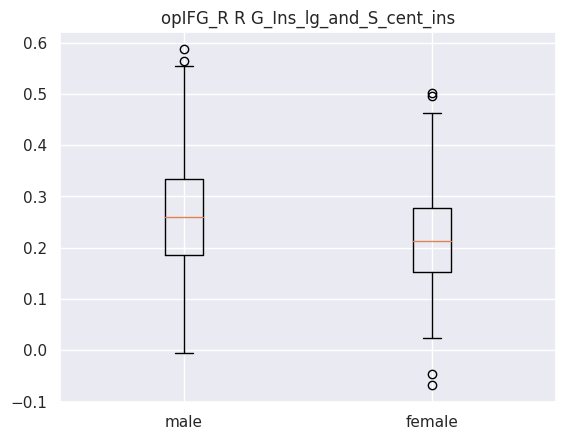

Ttest_indResult(statistic=5.071136490485997, pvalue=5.378396910376465e-07)
male mean : 0.26213691595703426
female mean : 0.21789970354485053


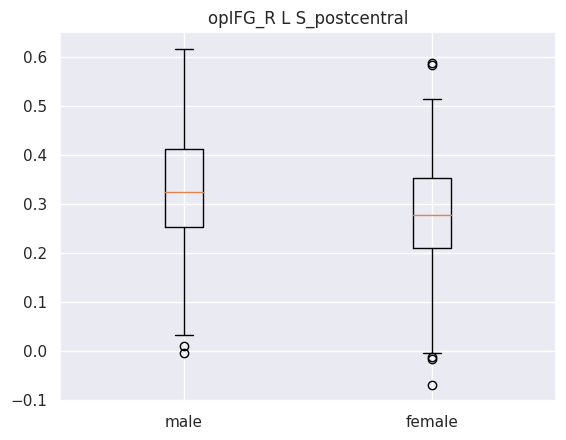

Ttest_indResult(statistic=5.271054566169988, pvalue=1.9369475536514105e-07)
male mean : 0.32780815557186316
female mean : 0.27874649102691035


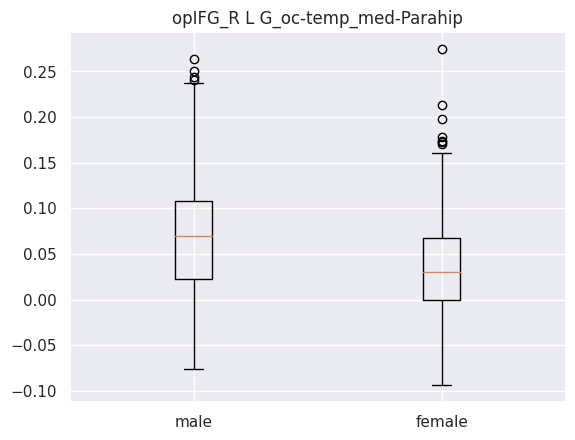

Ttest_indResult(statistic=6.251330329526955, pvalue=8.05447977290333e-10)
male mean : 0.06960421543711026
female mean : 0.0386048876523588


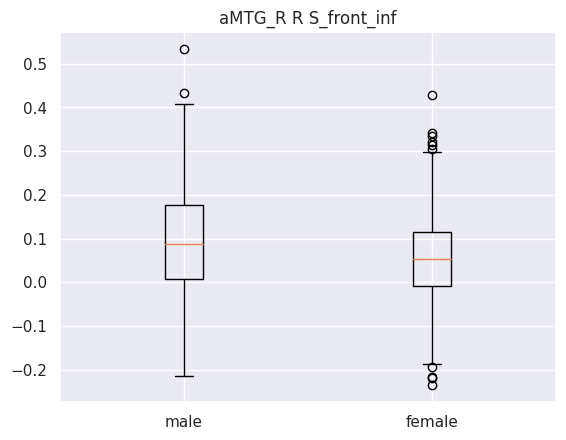

Ttest_indResult(statistic=4.148252422200393, pvalue=3.868639529214971e-05)
male mean : 0.09520096379193917
female mean : 0.055367278695980064


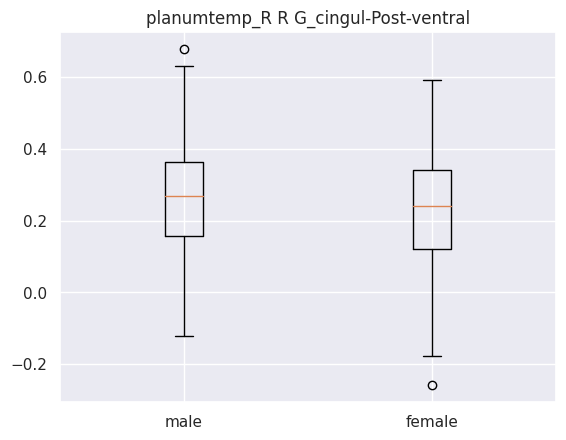

Ttest_indResult(statistic=2.475346691636639, pvalue=0.013604413951231341)
male mean : 0.26356463188897344
female mean : 0.23156667134385378


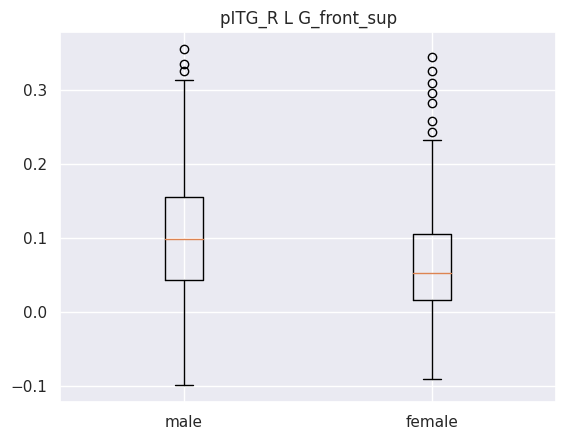

Ttest_indResult(statistic=5.343650897512694, pvalue=1.3257979942942627e-07)
male mean : 0.10204701447452472
female mean : 0.06652489050332226


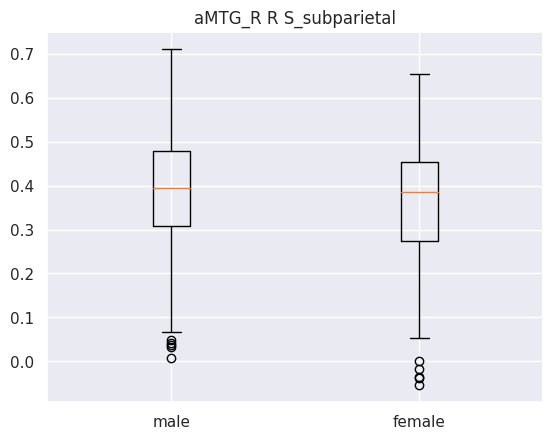

Ttest_indResult(statistic=1.8896304959307062, pvalue=0.059321818335763714)
male mean : 0.3831714017832699
female mean : 0.36253010012717607


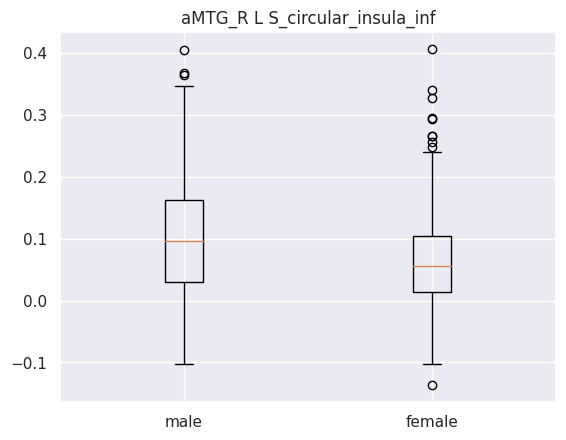

Ttest_indResult(statistic=5.519848416328338, pvalue=5.188050187200102e-08)
male mean : 0.10639979831471483
female mean : 0.06546545337565116
                                   Region       Men     Women       P value
0                  pITG_R - L S_calcarine  0.184810  0.155436  1.287314e-03
1    pITG_R - L S_oc-temp_med_and_Lingual  0.224477  0.195552  2.775747e-04
2     opIFG_R - R G_Ins_lg_and_S_cent_ins  0.262137  0.217900  5.378397e-07
3               opIFG_R - L S_postcentral  0.327808  0.278746  1.936948e-07
4       opIFG_R - L G_oc-temp_med-Parahip  0.069604  0.038605  8.054480e-10
5                  aMTG_R - R S_front_inf  0.095201  0.055367  3.868640e-05
6  planumtemp_R - R G_cingul-Post-ventral  0.263565  0.231567  1.360441e-02
7                  pITG_R - L G_front_sup  0.102047  0.066525  1.325798e-07
8                aMTG_R - R S_subparietal  0.383171  0.362530  5.932182e-02
9        aMTG_R - L S_circular_insula_inf  0.106400  0.065465  5.188050e-08


In [155]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_right)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

# Noise testing

In [156]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_2024" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)

In [157]:
model_test = data_results["model"][random.randint(0, 10000)]
gender_test = np.asarray(df_boot["Gender"])
score, perm_score, p_val = permutation_test_score(model_test, x_correl, gender_test)

In [158]:
acc_iter = []
model_test = data_results["model"][random.randint(0, 10000)]
for i in range(0, 10000):
    gender_test = np.asarray(df_boot["Gender"])
    np.random.shuffle(gender_test)
    acc_rand = model_test.score(x_correl, gender_test)
    acc_iter.append(acc_rand)
    
acc_iter = np.asarray(acc_iter)

In [159]:
gender_test = np.asarray(df_boot["Gender"])
x_correl.size

667776

(0.4, 1.0)

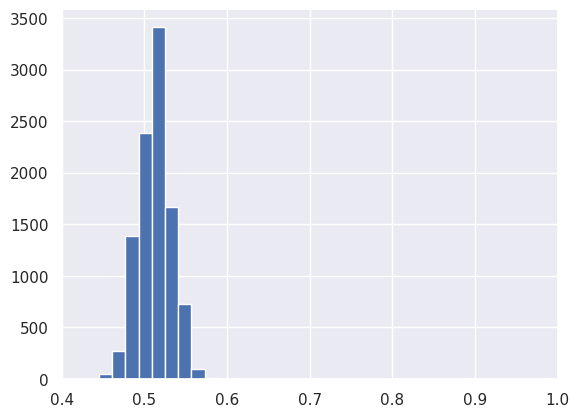

In [160]:
plt.hist(acc_iter)
plt.xlim([0.4, 1])

In [161]:
# accuracy should be around 0.50 (50%) if not it's a problem
acc_iter.mean()

0.5116209219858155

# Violin plot

0.13497622929505704


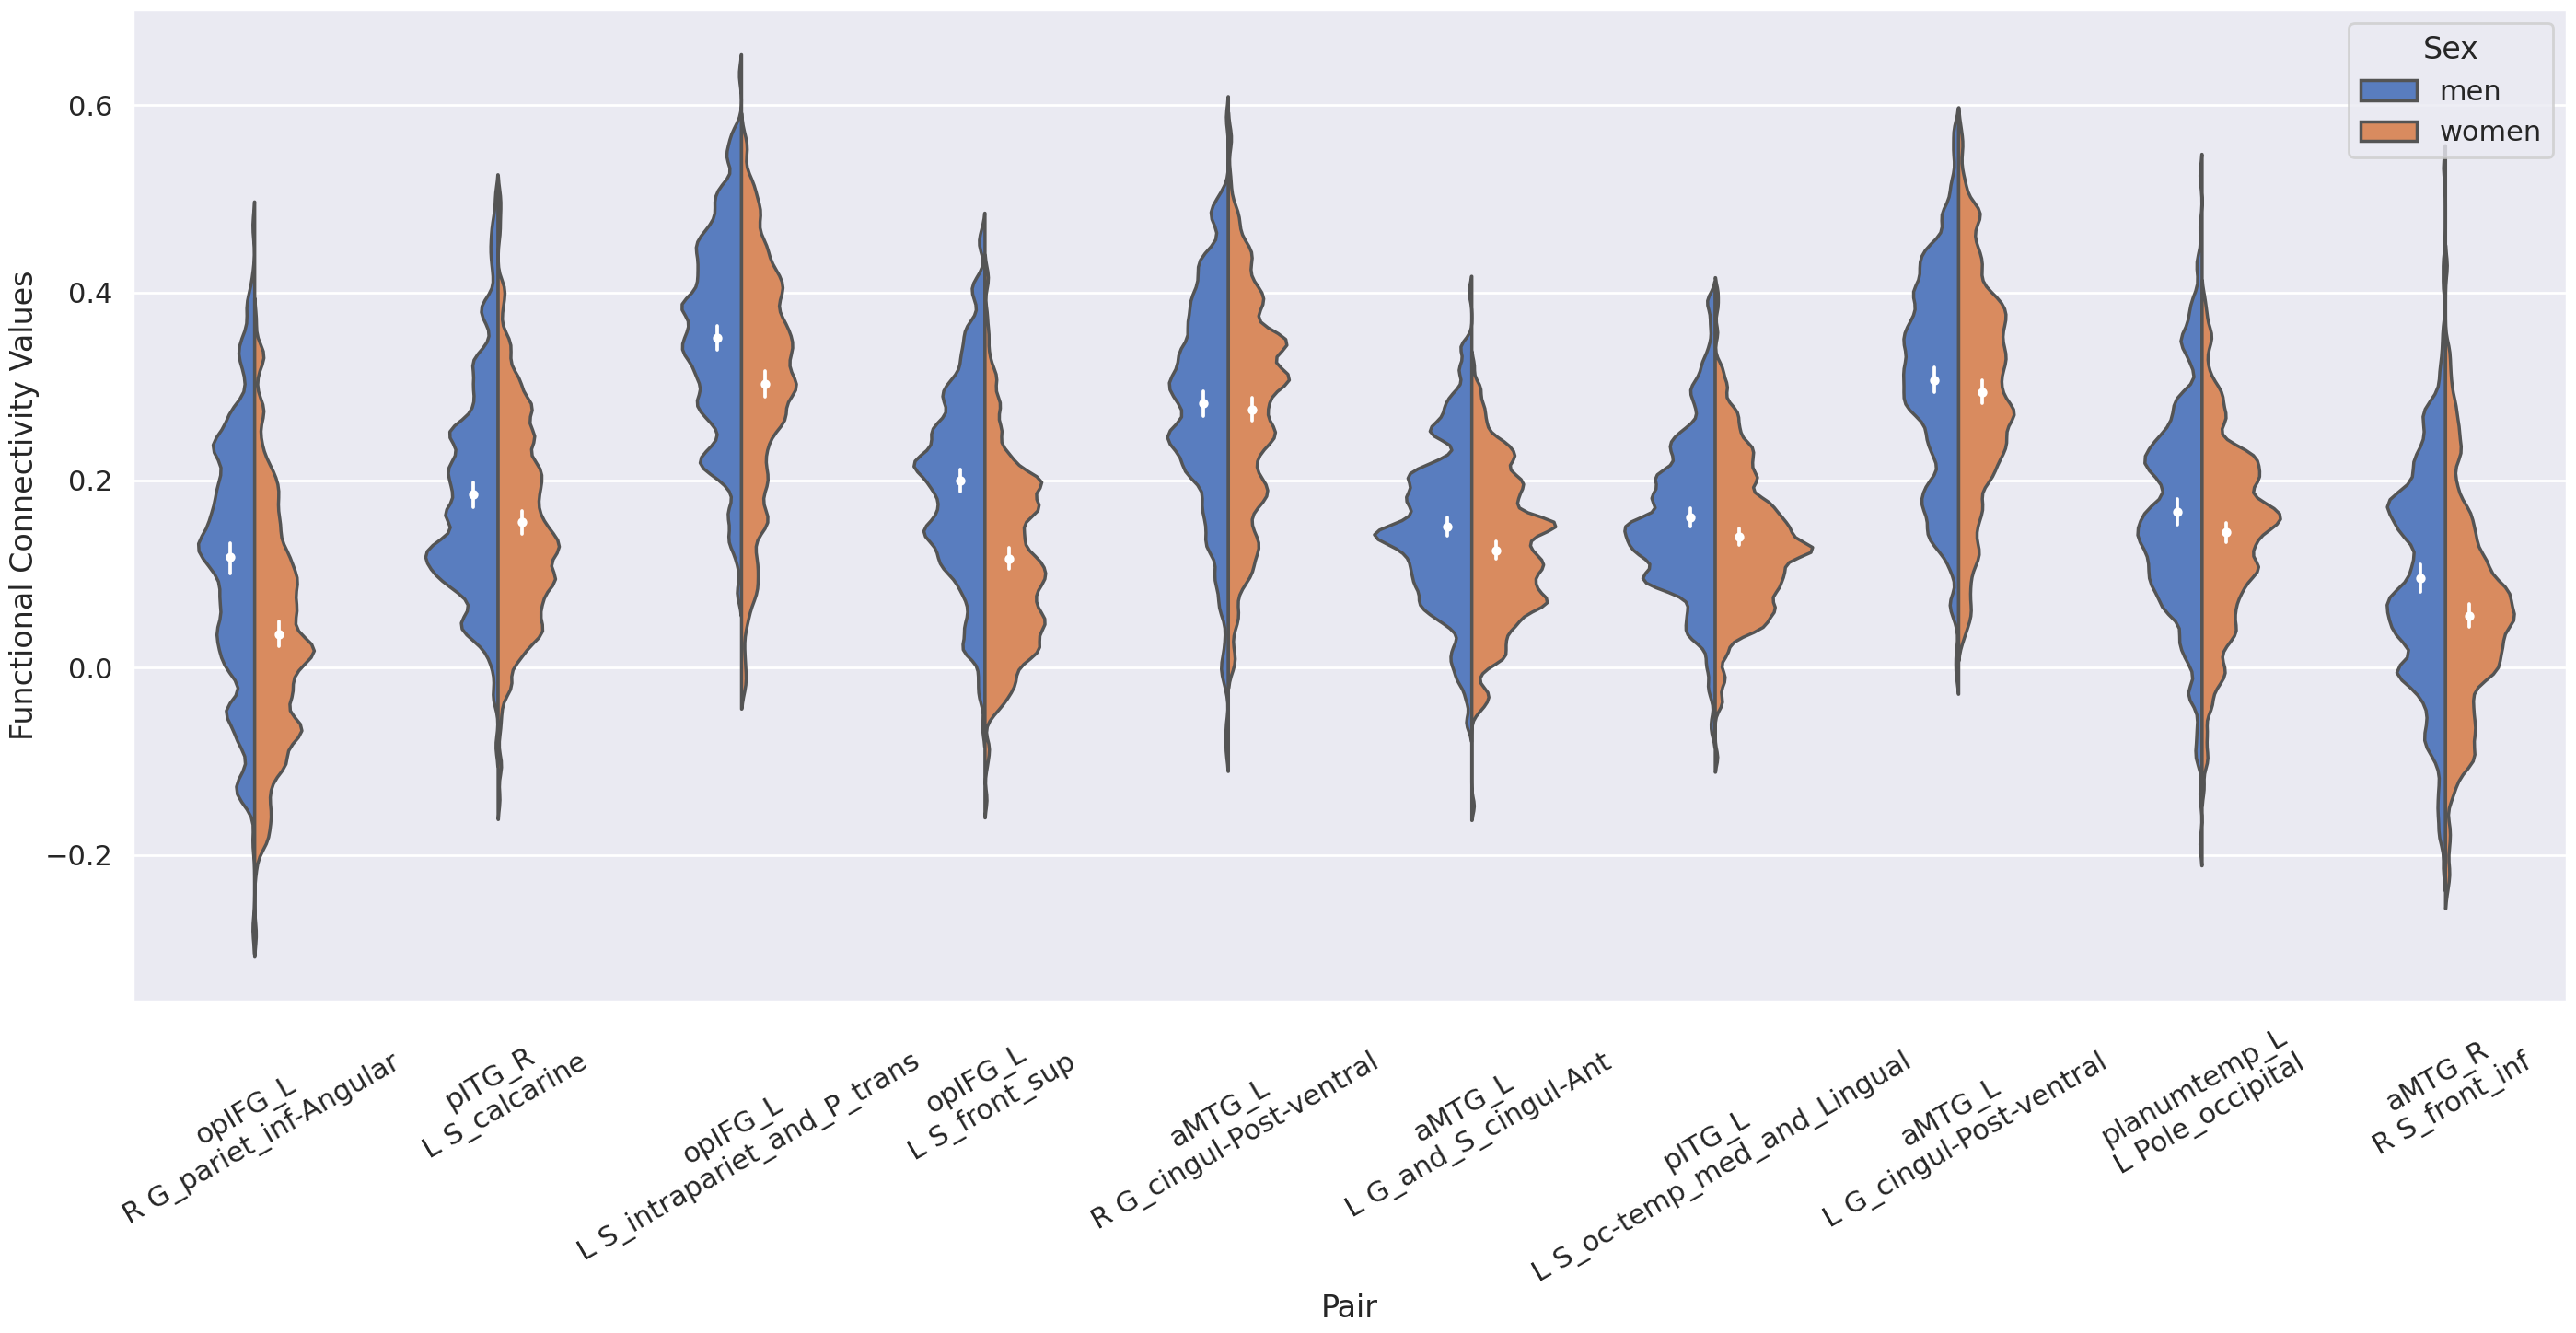

In [23]:
#1. make dataframe for the violin plot 
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/Final_HCP_database.csv")
df = pd.DataFrame.from_dict(data, orient="index", columns=label["name"]).reset_index()
df["participant_id"] = df["index"].apply(lambda x: x[0])
df["seed"] = df["index"].apply(lambda x: x[1])
df["Gender"] = list(Final_df["Gender"]) * 8
df["Gender"] = df["Gender"].replace({0:"men", 1:"women"})

df_connectivity = df.melt(id_vars=["participant_id", "seed", "Gender"], value_vars=label["name"])
df_connectivity["pair"] = df_connectivity["seed"] + " with " + df_connectivity["name"]

df_temp_men = df_connectivity.loc[
    (df_connectivity["Gender"] == "men") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]  
df_temp_women = df_connectivity.loc[
    (df_connectivity["Gender"] == "women") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]
stats.ttest_ind(df_temp_men["value"], df_temp_women["value"])
print(df_temp_men["value"].mean())


# A changer selon les dix meilleures seeds
# list to make sure top 10 regions are in order 

top10 = ["opIFG_L with R G_pariet_inf-Angular",
         "pITG_R with L S_calcarine",
         "opIFG_L with L S_intrapariet_and_P_trans",
         "opIFG_L with L S_front_sup",
         "aMTG_L with R G_cingul-Post-ventral", 
         "aMTG_L with L G_and_S_cingul-Ant",
         "pITG_L with L S_oc-temp_med_and_Lingual",
         "aMTG_L with L G_cingul-Post-ventral",
         "planumtemp_L with L Pole_occipital", 
         "aMTG_R with R S_front_inf"]
         

df_temp = df_connectivity.loc[
    # (df_connectivity["seed"] == "opIFG_L") &
    (df_connectivity["pair"].isin(top10))
]  
df_temp["Sex"] = df_temp["Gender"]
df_temp["Functional Connectivity Values"] = df_temp["value"]
df_temp["Pair"] = df_temp["pair"]

# plt.figure(figsize=(20, 11.25))

sns.set_theme(context="poster")

v_plot = sns.violinplot(x="Pair", y="Functional Connectivity Values", hue="Sex", data=df_temp, split= True, bw=0.10,inner = None, palette="muted", order=top10)
# v_plot.set_xticks([0,1])
# v_plot.set_xticklabels(["aMTG_L\nL S_front_sup", "2"])
# v_plot

v_plot = sns.pointplot(x="Pair", y="Functional Connectivity Values", hue="Sex",
                    data=df_temp, dodge=0.2, join=False, palette=['white'], ax=v_plot, scale=0.5, order=top10, legend=False)

# changer les xticklabels selon les labels obtenues
v_plot.set_xticks([0,1,2,3,4,5,6,7,8,9])
v_plot.set_xticklabels(["opIFG_L\nR G_pariet_inf-Angular", 
                    "pITG_R\nL S_calcarine",
                    "opIFG_L\nL S_intrapariet_and_P_trans",
                    "opIFG_L\nL S_front_sup",
                    "aMTG_L\nR G_cingul-Post-ventral", 
                    "aMTG_L\nL G_and_S_cingul-Ant",
                    "pITG_L\nL S_oc-temp_med_and_Lingual",
                    "aMTG_L\nL G_cingul-Post-ventral",
                    "planumtemp_L\nL Pole_occipital",
                    "aMTG_R\nR S_front_inf"], rotation=30)


fig = v_plot.get_figure()
fig.set_size_inches(28.5, 15)
plt.tight_layout()
fig.savefig("violin_plot.png", dpi=300)

# Classification based on best feature

In [85]:
def machine_learning(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score.append(cross_val_score(model, X_train, y_train, cv=20, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

## Testing the machine learning classification feature by feature

In [167]:
# the best feature (seed and their region)
seeds = ["opIFG_L", "pITG_R", "opIFG_L", "opIFG_L", "aMTG_L", "aMTG_L", "pITG_L", "aMTG_L", "planumtemp_L", "aMTG_L"]
regions = ["R_G_pariet_inf-Angular", 
          "L_S_calcarine", 
          "L_S_intrapariet_and_P_trans", 
          "L_S_front_sup", 
          "R_G_cingul-Post-ventral", 
          "L_G_and_S_cingul-Ant",
           "L_S_oc-temp_med_and_Lingual",
         "L_G_cingul-Post-ventral",
         "L_Pole_occipital",
         "R_S_front_inf"]

file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__voxelcorrelations.csv"
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/Final_HCP_database.csv")

x = []
y = []
for i in range(0, len(seeds)):
    file = file_path.format(seed_name=seeds[i])
    loaded = pd.read_csv(file_path.format(seed_name=seeds[i]))
    signal = loaded[seeds[i]+"__"+regions[i]]
    for subject in Final_df["subject_label"]:
        sub_sex = Final_df.loc[Final_df["subject_label"] == subject]["Gender"].values[0]
        value = loaded.loc[loaded["Unnamed: 0"] == "sub-"+str(subject)][seeds[i]+"__"+regions[i]].values[0]
        x.append(value)
        y.append(sub_sex)
    x = np.asarray(x)
    x = x.reshape(-1,1)
    print("Testing : "+seeds[i]+" "+regions[i])
    machine_learning(x,y)
    print("\n")
    x = []
    y = []
        

Testing : opIFG_L R_G_pariet_inf-Angular
train: 451 test: 113
[array([0.86956522, 0.60869565, 0.73913043, 0.60869565, 0.65217391,
       0.43478261, 0.60869565, 0.7826087 , 0.7826087 , 0.65217391,
       0.56521739, 0.86363636, 0.68181818, 0.54545455, 0.68181818,
       0.63636364, 0.77272727, 0.59090909, 0.5       , 0.63636364])]
predicted class  Femme  Homme
actual class                 
Femme               42     18
Homme               21     32
accuracy test (r2) = 0.6548672566371682
accuracy train (r2) = 0.6585365853658537


Testing : pITG_R L_S_calcarine
train: 451 test: 113
[array([0.65217391, 0.56521739, 0.65217391, 0.56521739, 0.65217391,
       0.56521739, 0.56521739, 0.47826087, 0.34782609, 0.56521739,
       0.47826087, 0.59090909, 0.63636364, 0.45454545, 0.63636364,
       0.5       , 0.5       , 0.59090909, 0.18181818, 0.59090909])]
predicted class  Femme  Homme
actual class                 
Femme               51      9
Homme               40     13
accuracy test (r2) = 

# Independent validation testing (60/20/20)

In [69]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-aMTG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-opIFG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-pITG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-pITG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-planumtemp_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_left = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-left_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_right = study_dir / "results_test_validation_2024-06-05" / "LinearSVC" / "seed-right_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

# FYI do not interpret the regions just look at the mean accuraccy which is the mean accuracy of the model on the validation sample

In [34]:
# mean confusion matrix
pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion.mean()

predicted class    Femme    Homme
actual class                     
Femme            42.7342  13.2658
Homme            11.3947  44.6053

## Best regions all seed validation accuraccy

Validation accuracy
The mean accuracy : 0.7798169642857143
The standard deviation of the accuracy : 0.027596421508415778
The lower boundry of the confidance interval of the accuracy : 0.7257279781292194
The upper boundry of the confidance interval of the accuracy : 0.8339059504422093

Testing accuracy
      coefficient          seed                       labels
189      0.064981  planumtemp_L             L Pole_occipital
98       0.061380       opIFG_L       R G_pariet_inf-Angular
55       0.052966       opIFG_L  L S_intrapariet_and_P_trans
64       0.052473       opIFG_L        L S_parieto_occipital
504      0.049564        pITG_L  L S_oc-temp_med_and_Lingual
351      0.049410        aMTG_L  L S_intrapariet_and_P_trans
1096     0.048961        pITG_R  L S_oc-temp_med_and_Lingual
1112     0.046854        pITG_R        R G_and_S_paracentral
53       0.046118       opIFG_L                L S_front_sup
656      0.044833       opIFG_R        L S_parieto_occipital
The mean accuracy : 0.9055

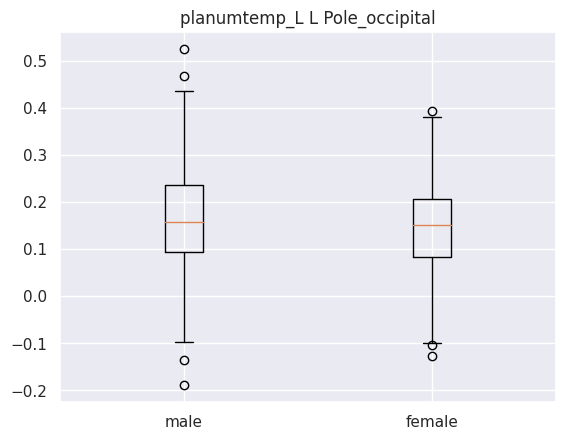

Ttest_indResult(statistic=2.486200541931443, pvalue=0.013200894125973316)
male mean : 0.16626784924790874
male std : 0.11264322709736568
female mean : 0.14439602449857145
female std : 0.09589248593995307


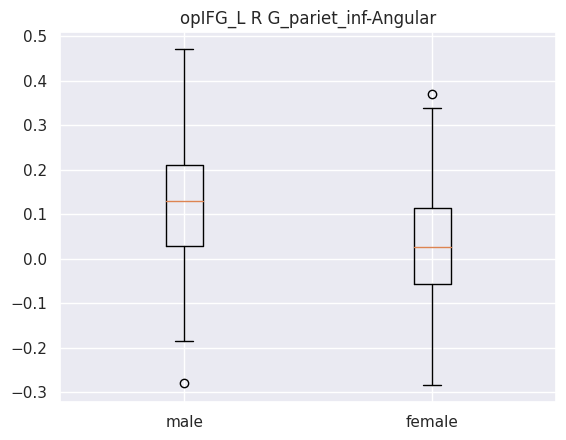

Ttest_indResult(statistic=7.716695110055561, pvalue=5.480751648776057e-14)
male mean : 0.11766997985152092
male std : 0.13076288558639354
female mean : 0.03601953544850498
female std : 0.12000095132461792


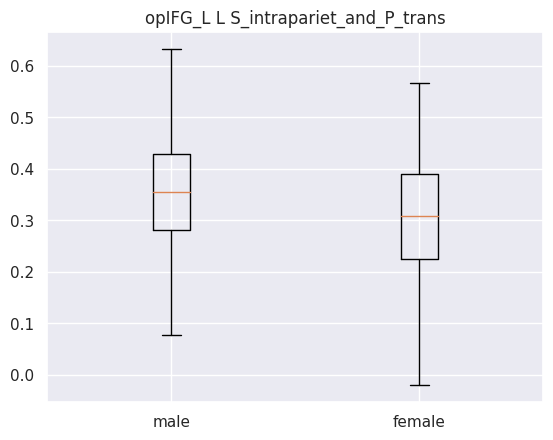

Ttest_indResult(statistic=5.055350828931209, pvalue=5.821781911163281e-07)
male mean : 0.35213074777946773
male std : 0.10658887449917556
female mean : 0.3031099729109635
female std : 0.12130464463020163


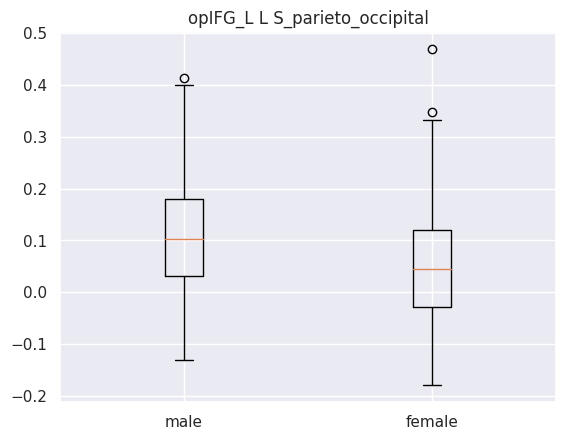

Ttest_indResult(statistic=6.503523668812626, pvalue=1.7355351061785972e-10)
male mean : 0.10978782784771862
male std : 0.10910224511601631
female mean : 0.05152286066817276
female std : 0.10312061557532284


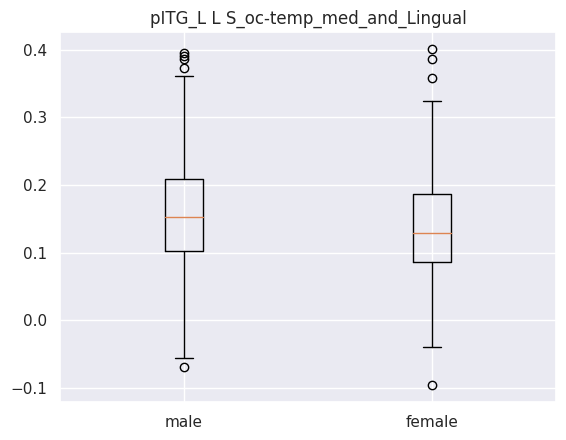

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
male std : 0.08334523805349907
female mean : 0.13959590949933556
female std : 0.07802101521527612


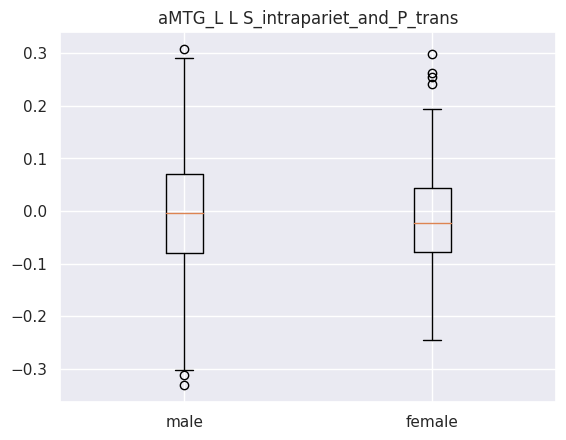

Ttest_indResult(statistic=0.9647641183387371, pvalue=0.3350779189775276)
male mean : -0.004121455086692014
male std : 0.11166920373773248
female mean : -0.012516677279534883
female std : 0.09459673974350062


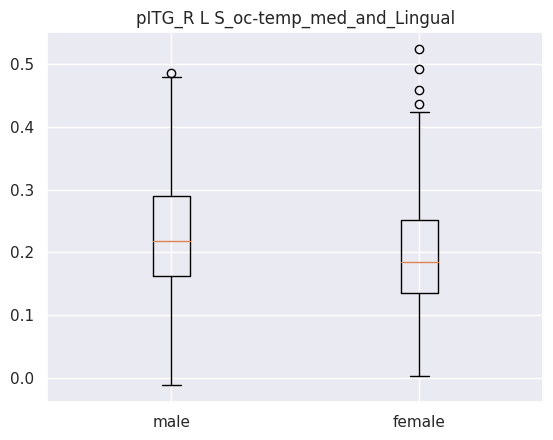

Ttest_indResult(statistic=3.658497216134596, pvalue=0.00027757468582203013)
male mean : 0.2244769810418251
male std : 0.09519528685578532
female mean : 0.19555248922657806
female std : 0.09199381053279175


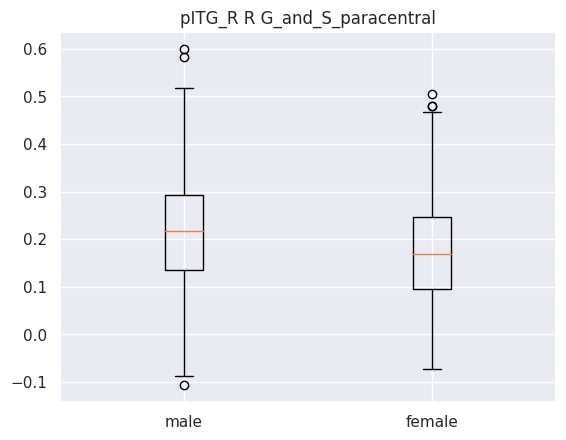

Ttest_indResult(statistic=4.569125068043735, pvalue=6.02478242147785e-06)
male mean : 0.2237594718095057
male std : 0.11892193001714262
female mean : 0.17962112252890367
female std : 0.10999380702841893


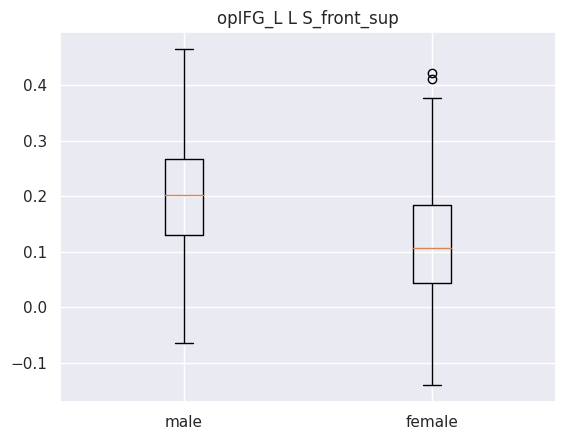

Ttest_indResult(statistic=10.006029115486237, pvalue=8.422510097736992e-22)
male mean : 0.1996858131581749
male std : 0.10098467263884126
female mean : 0.11606861896099667
female std : 0.09690605329034335


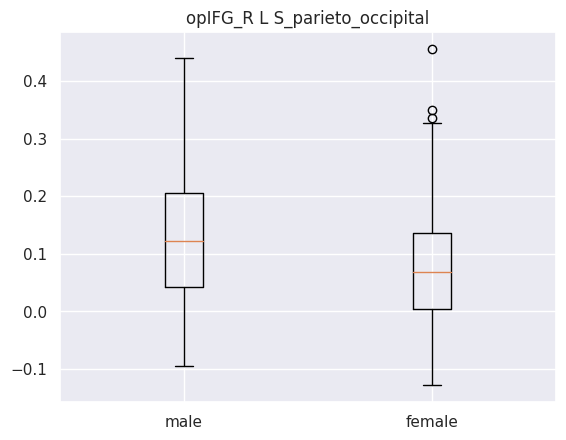

Ttest_indResult(statistic=6.286996654261317, pvalue=6.50249277681862e-10)
male mean : 0.13124042186996196
male std : 0.11092566474938649
female mean : 0.07599817451156146
female std : 0.09737712149945338
                                  Region       Men     Women       P value
0        planumtemp_L - L Pole_occipital  0.166268  0.144396  1.320089e-02
1       opIFG_L - R G_pariet_inf-Angular  0.117670  0.036020  5.480752e-14
2  opIFG_L - L S_intrapariet_and_P_trans  0.352131  0.303110  5.821782e-07
3        opIFG_L - L S_parieto_occipital  0.109788  0.051523  1.735535e-10
4   pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  2.643129e-03
5   aMTG_L - L S_intrapariet_and_P_trans -0.004121 -0.012517  3.350779e-01
6   pITG_R - L S_oc-temp_med_and_Lingual  0.224477  0.195552  2.775747e-04
7         pITG_R - R G_and_S_paracentral  0.223759  0.179621  6.024782e-06
8                opIFG_L - L S_front_sup  0.199686  0.116069  8.422510e-22
9        opIFG_R - L S_parieto_occipital  0.13

In [71]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## aMTG_L validation accuracy

Validation accuracy
The mean accuracy : 0.7153883928571428
The standard deviation of the accuracy : 0.02834487149863683
The lower boundry of the confidance interval of the accuracy : 0.6598324447198146
The upper boundry of the confidance interval of the accuracy : 0.7709443409944711

Testing accuracy
     coefficient    seed                       labels
64      0.233729  aMTG_L        L S_parieto_occipital
98      0.220598  aMTG_L       R G_pariet_inf-Angular
22      0.193622  aMTG_L      L G_oc-temp_med-Parahip
104     0.177149  aMTG_L                   R G_rectus
55      0.168152  aMTG_L  L S_intrapariet_and_P_trans
131     0.163512  aMTG_L   R S_oc_sup_and_transversal
112     0.140978  aMTG_L       R Lat_Fis-ant-Horizont
53      0.137163  aMTG_L                L S_front_sup
90      0.135113  aMTG_L    R G_Ins_lg_and_S_cent_ins
29      0.130048  aMTG_L                L G_precuneus
The mean accuracy : 0.815524175824176
The standard deviation of the accuracy : 0.042214480892858265
The 

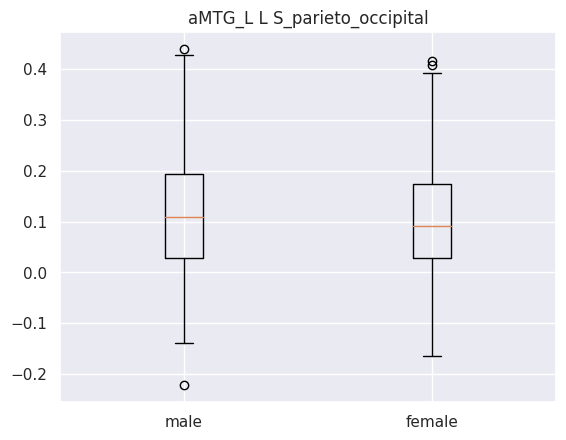

Ttest_indResult(statistic=0.8844937044320892, pvalue=0.3768080010830589)
male mean : 0.11133875940456274
male std : 0.11414917252822208
female mean : 0.10330131695813953
female std : 0.1012672300745512


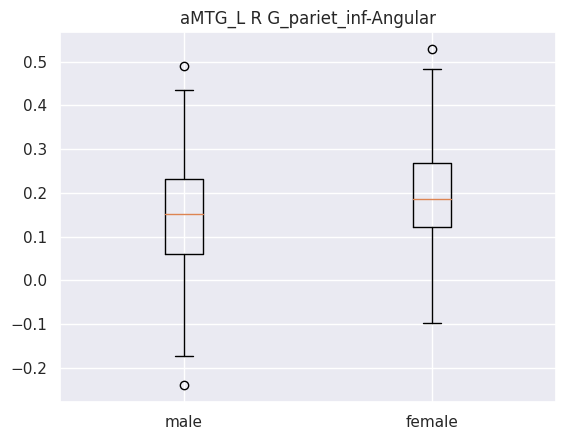

Ttest_indResult(statistic=-4.609075888150725, pvalue=5.010077069107832e-06)
male mean : 0.1466265599053232
male std : 0.12723212732120814
female mean : 0.1927383331056479
female std : 0.109937688897089


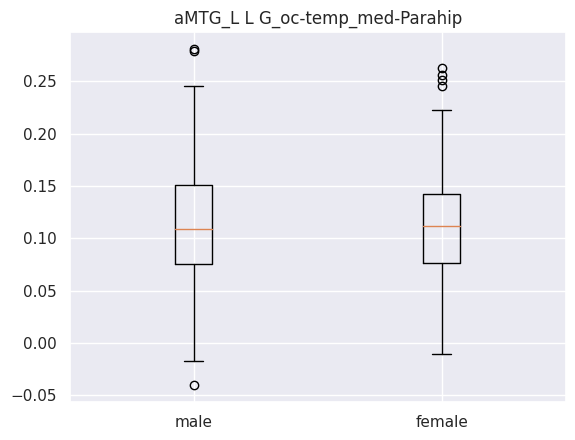

Ttest_indResult(statistic=1.1334696103846564, pvalue=0.25750038435672185)
male mean : 0.11530491022243346
male std : 0.05322901814260232
female mean : 0.11041756162126246
female std : 0.048956437497619715


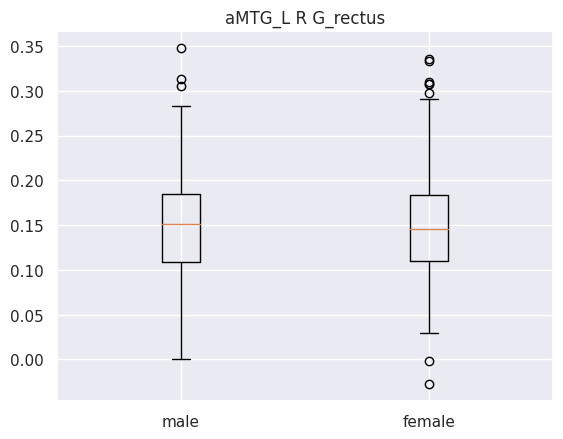

Ttest_indResult(statistic=-0.050680278730783346, pvalue=0.9595982987735558)
male mean : 0.14921290738174903
male std : 0.05910948627590685
female mean : 0.14947103351827243
female std : 0.061200009471971246


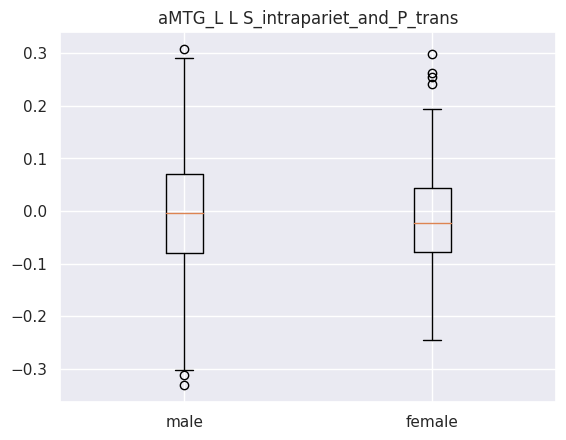

Ttest_indResult(statistic=0.9647641183387371, pvalue=0.3350779189775276)
male mean : -0.004121455086692014
male std : 0.11166920373773248
female mean : -0.012516677279534883
female std : 0.09459673974350062


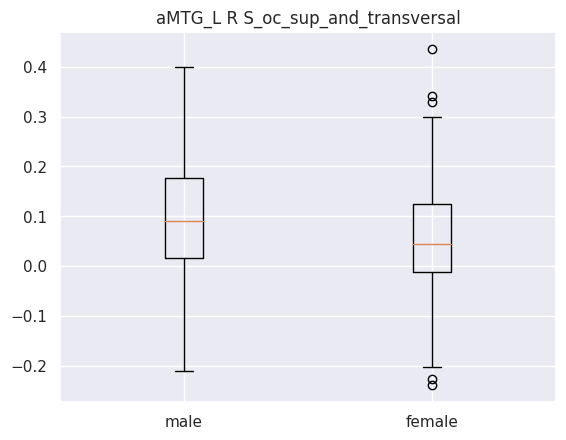

Ttest_indResult(statistic=4.340453076267227, pvalue=1.686421726368641e-05)
male mean : 0.09461966041634981
male std : 0.1152752884396305
female mean : 0.054491475181651164
female std : 0.10386960568631878


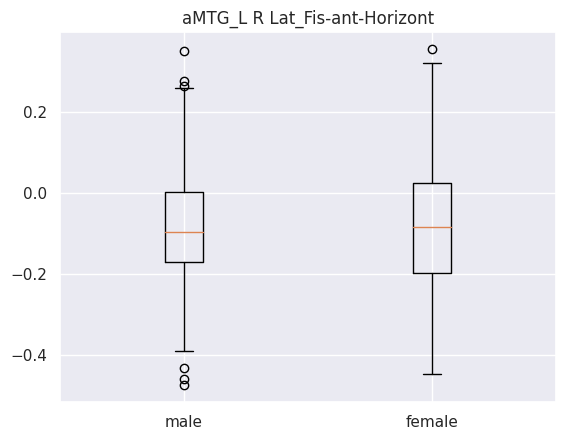

Ttest_indResult(statistic=-0.45605548932418016, pvalue=0.6485262516617757)
male mean : -0.08113484296726237
male std : 0.14676591352252533
female mean : -0.07525894114513622
female std : 0.15710785096797464


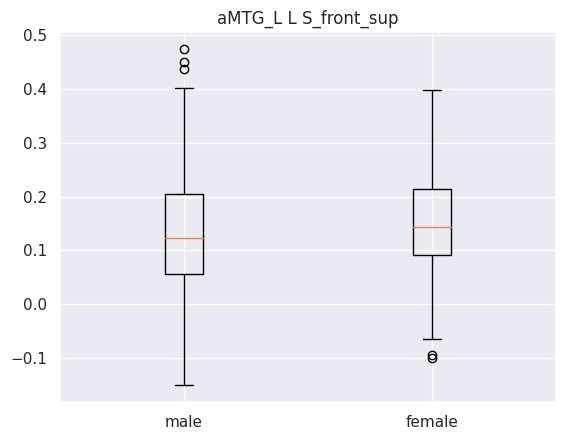

Ttest_indResult(statistic=-1.4354160996967782, pvalue=0.15172486392697015)
male mean : 0.13497622929505704
male std : 0.11129746737694128
female mean : 0.14753736321687708
female std : 0.0961519746523398


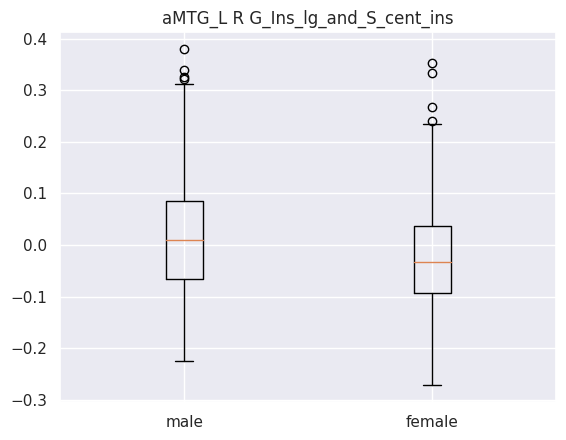

Ttest_indResult(statistic=3.776689697345467, pvalue=0.00017586030683131387)
male mean : 0.012922727051558938
male std : 0.11306640552563055
female mean : -0.02182893120227242
female std : 0.10497192397026917


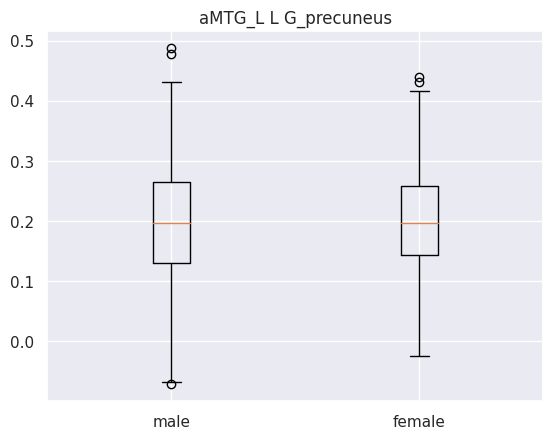

Ttest_indResult(statistic=0.34352085134667926, pvalue=0.7313351295320519)
male mean : 0.2003016257026616
male std : 0.10076302077787475
female mean : 0.1975837047968771
female std : 0.08679728049955084
                                 Region       Men     Women   P value
0        aMTG_L - L S_parieto_occipital  0.111339  0.103301  0.376808
1       aMTG_L - R G_pariet_inf-Angular  0.146627  0.192738  0.000005
2      aMTG_L - L G_oc-temp_med-Parahip  0.115305  0.110418  0.257500
3                   aMTG_L - R G_rectus  0.149213  0.149471  0.959598
4  aMTG_L - L S_intrapariet_and_P_trans -0.004121 -0.012517  0.335078
5   aMTG_L - R S_oc_sup_and_transversal  0.094620  0.054491  0.000017
6       aMTG_L - R Lat_Fis-ant-Horizont -0.081135 -0.075259  0.648526
7                aMTG_L - L S_front_sup  0.134976  0.147537  0.151725
8    aMTG_L - R G_Ins_lg_and_S_cent_ins  0.012923 -0.021829  0.000176
9                aMTG_L - L G_precuneus  0.200302  0.197584  0.731335


In [72]:
rois = ["aMTG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_L)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## aMRG_R validation accuracy

Validation accuracy
The mean accuracy : 0.6802491071428571
The standard deviation of the accuracy : 0.02849010970922405
The lower boundry of the confidance interval of the accuracy : 0.624408492112778
The upper boundry of the confidance interval of the accuracy : 0.7360897221729362

Testing accuracy
     coefficient    seed                       labels
98      0.231039  aMTG_R       R G_pariet_inf-Angular
90      0.201290  aMTG_R    R G_Ins_lg_and_S_cent_ins
22      0.199909  aMTG_R      L G_oc-temp_med-Parahip
55      0.181233  aMTG_R  L S_intrapariet_and_P_trans
64      0.152101  aMTG_R        L S_parieto_occipital
104     0.151472  aMTG_R                   R G_rectus
96      0.150167  aMTG_R      R G_oc-temp_med-Parahip
75      0.143625  aMTG_R      R G_and_S_occipital_inf
112     0.136790  aMTG_R       R Lat_Fis-ant-Horizont
85      0.134029  aMTG_R      R G_front_inf-Opercular
The mean accuracy : 0.8197714285714288
The standard deviation of the accuracy : 0.042583458845829834
The 

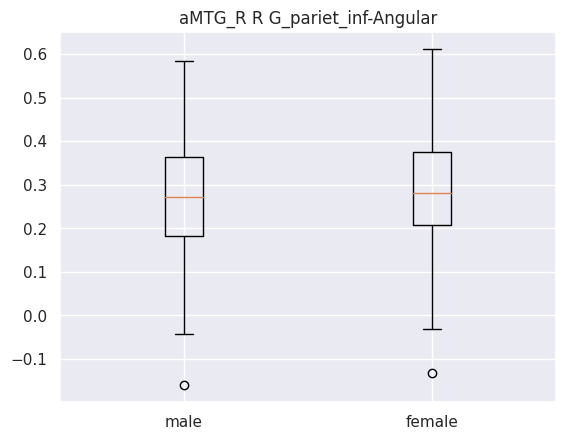

Ttest_indResult(statistic=-1.3474458962609632, pvalue=0.17837963763879625)
male mean : 0.2745868511307985
male std : 0.12784455793647628
female mean : 0.2885656095314618
female std : 0.1180010594320334


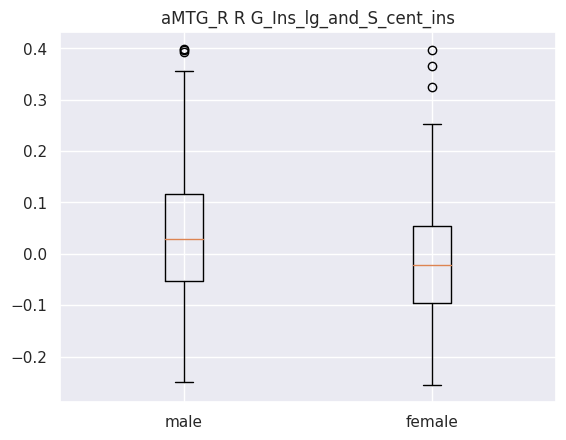

Ttest_indResult(statistic=4.892230628154193, pvalue=1.3038463843832238e-06)
male mean : 0.03623579969863118
male std : 0.1252291741990028
female mean : -0.012065202055481731
female std : 0.1088246644922351


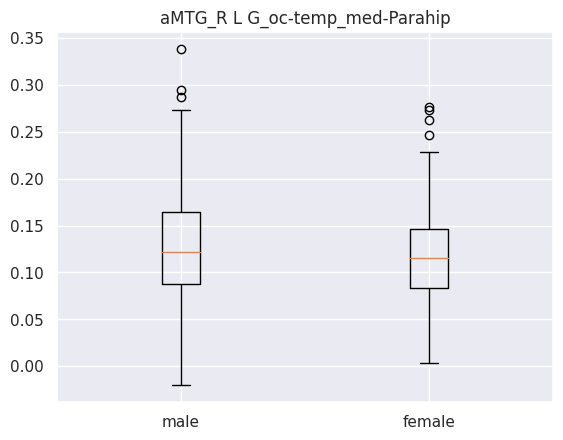

Ttest_indResult(statistic=2.0619605458315986, pvalue=0.039670656140978776)
male mean : 0.1272253816121673
male std : 0.05639247240973288
female mean : 0.11806232951096346
female std : 0.04895538358491254


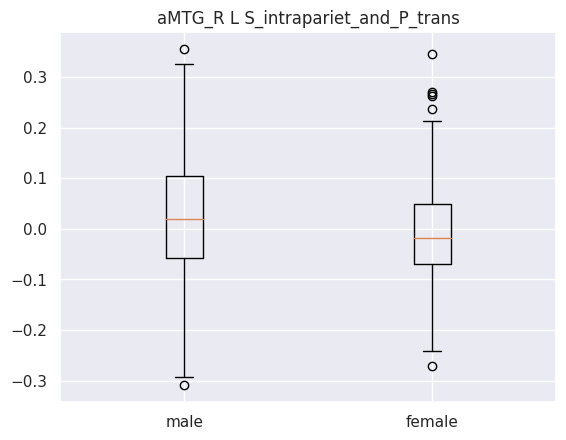

Ttest_indResult(statistic=3.0510209113028184, pvalue=0.0023882691927384963)
male mean : 0.018445383925361214
male std : 0.11377089527880688
female mean : -0.008577846181096346
female std : 0.09617201070855781


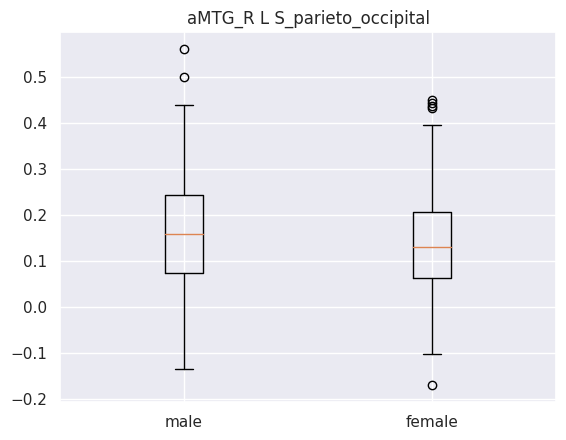

Ttest_indResult(statistic=2.227185214461007, pvalue=0.026330207166639395)
male mean : 0.15845452172281368
male std : 0.11733507024146936
female mean : 0.13716209121049833
female std : 0.109192805980464


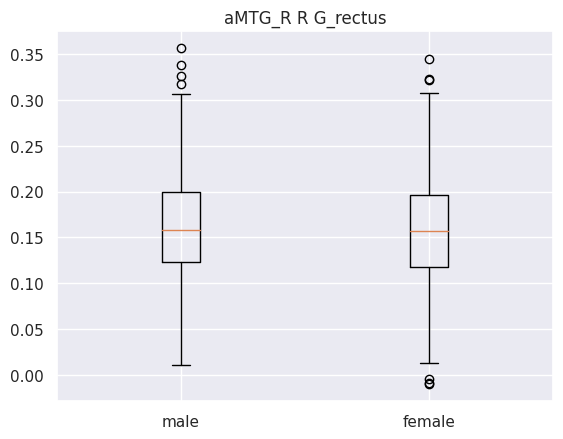

Ttest_indResult(statistic=0.25672681729231484, pvalue=0.7974836233347031)
male mean : 0.1602442236539924
male std : 0.062175408547676864
female mean : 0.1588885866717608
female std : 0.06268623105683578


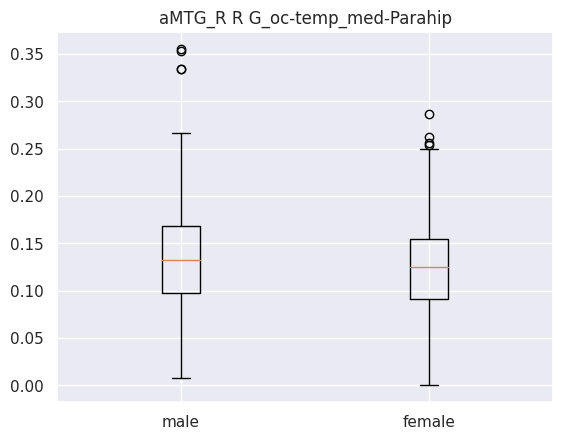

Ttest_indResult(statistic=2.7035360113254954, pvalue=0.00706828235821115)
male mean : 0.13853981123193918
male std : 0.057904596395341776
female mean : 0.12625079083475085
female std : 0.0498514005437266


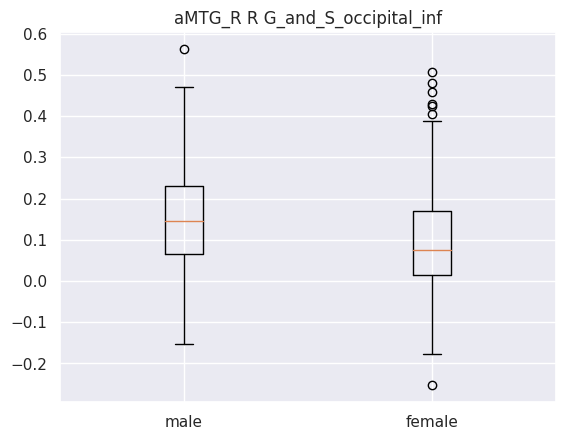

Ttest_indResult(statistic=5.746838754084861, pvalue=1.4919371944492937e-08)
male mean : 0.1548778395163498
male std : 0.12383961806520402
female mean : 0.09606502119933555
female std : 0.11852064008245364


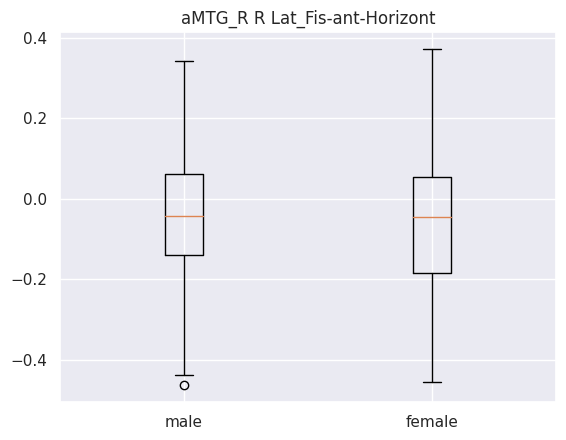

Ttest_indResult(statistic=1.4449978779532366, pvalue=0.14901580803702616)
male mean : -0.0368282638551711
male std : 0.1549612567948559
female mean : -0.056400834690697677
female std : 0.1646196753549061


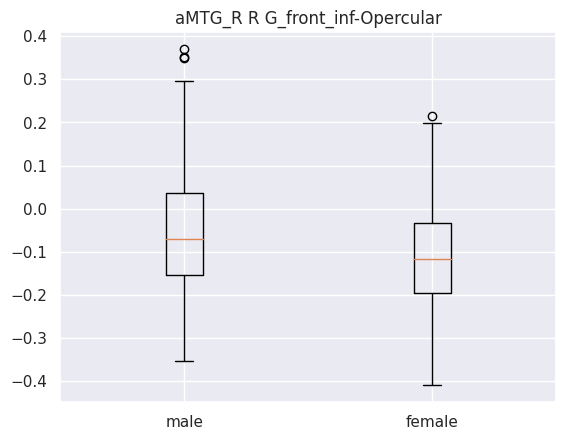

Ttest_indResult(statistic=4.787448025936902, pvalue=2.1627924490973566e-06)
male mean : -0.057489325285171096
male std : 0.13961711883192487
female mean : -0.10877381936445182
female std : 0.1141970996046965
                                 Region       Men     Women       P value
0       aMTG_R - R G_pariet_inf-Angular  0.274587  0.288566  1.783796e-01
1    aMTG_R - R G_Ins_lg_and_S_cent_ins  0.036236 -0.012065  1.303846e-06
2      aMTG_R - L G_oc-temp_med-Parahip  0.127225  0.118062  3.967066e-02
3  aMTG_R - L S_intrapariet_and_P_trans  0.018445 -0.008578  2.388269e-03
4        aMTG_R - L S_parieto_occipital  0.158455  0.137162  2.633021e-02
5                   aMTG_R - R G_rectus  0.160244  0.158889  7.974836e-01
6      aMTG_R - R G_oc-temp_med-Parahip  0.138540  0.126251  7.068282e-03
7      aMTG_R - R G_and_S_occipital_inf  0.154878  0.096065  1.491937e-08
8       aMTG_R - R Lat_Fis-ant-Horizont -0.036828 -0.056401  1.490158e-01
9      aMTG_R - R G_front_inf-Opercular -0.057489 -0

In [73]:
rois = ["aMTG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_R)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## opIFG_L validation accuracy

Validation accuracy
The mean accuracy : 0.7335714285714287
The standard deviation of the accuracy : 0.03068883912660718
The lower boundry of the confidance interval of the accuracy : 0.6734213038832786
The upper boundry of the confidance interval of the accuracy : 0.7937215532595787

Testing accuracy
     coefficient     seed                       labels
72      0.186947  opIFG_L             L S_temporal_sup
20      0.177514  opIFG_L      L G_oc-temp_lat-fusifor
91      0.155548  opIFG_L            R G_insular_short
60      0.155040  opIFG_L  L S_oc-temp_med_and_Lingual
40      0.154557  opIFG_L               L Lat_Fis-post
47      0.134661  opIFG_L      L S_circular_insula_inf
41      0.130872  opIFG_L             L Pole_occipital
144     0.128143  opIFG_L              R S_subparietal
1       0.126013  opIFG_L      L G_and_S_occipital_inf
71      0.124174  opIFG_L             L S_temporal_inf
The mean accuracy : 0.7335714285714287
The standard deviation of the accuracy : 0.03068883912

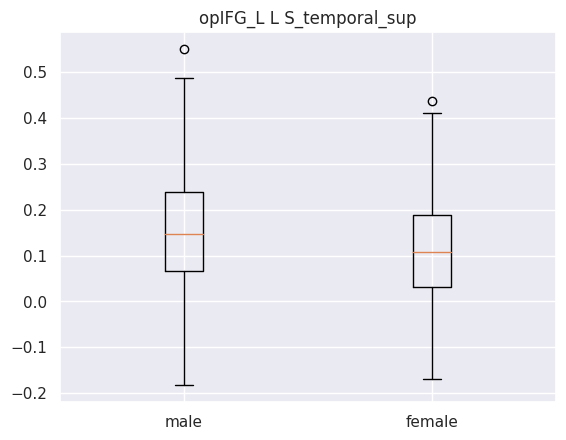

Ttest_indResult(statistic=4.104919666823164, pvalue=4.644482275203613e-05)
male mean : 0.15756035950874525
male std : 0.12779665808907587
female mean : 0.11516167434405318
female std : 0.116995762417676


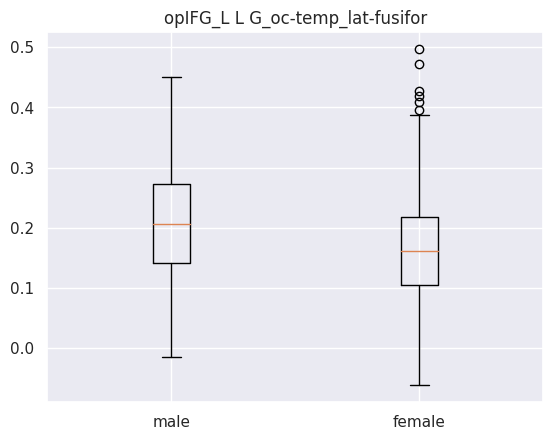

Ttest_indResult(statistic=5.698927511987025, pvalue=1.9476660856975242e-08)
male mean : 0.21165041260456274
male std : 0.09558055806544623
female mean : 0.1668287685760797
female std : 0.09071059585266414


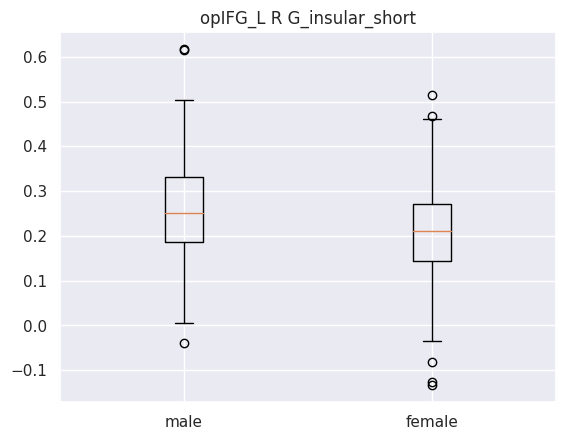

Ttest_indResult(statistic=5.4808703280162065, pvalue=6.398857490240382e-08)
male mean : 0.25729847525475286
male std : 0.10255773714008104
female mean : 0.20946871466478406
female std : 0.10376640995486473


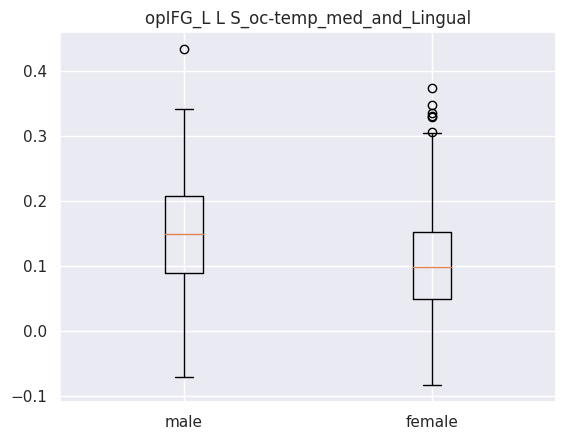

Ttest_indResult(statistic=5.979839353972038, pvalue=3.974325533230207e-09)
male mean : 0.1488611000961977
male std : 0.08275130578679875
female mean : 0.10701805680602991
female std : 0.0827545429881859


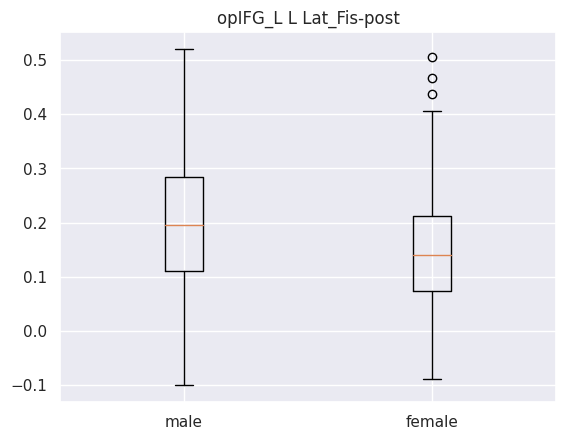

Ttest_indResult(statistic=5.935387024296681, pvalue=5.1325420089517246e-09)
male mean : 0.2050836814703422
male std : 0.11767179108479932
female mean : 0.15007587232843853
female std : 0.10203339475287607


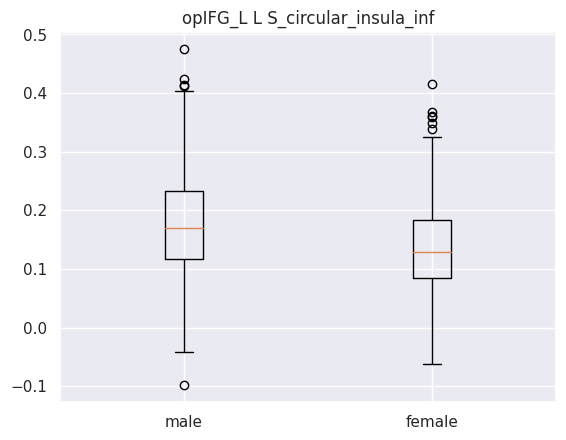

Ttest_indResult(statistic=5.793990901906812, pvalue=1.1455922176287184e-08)
male mean : 0.17968730860456272
male std : 0.08982294121388894
female mean : 0.13831419359568106
female std : 0.07945500381706048


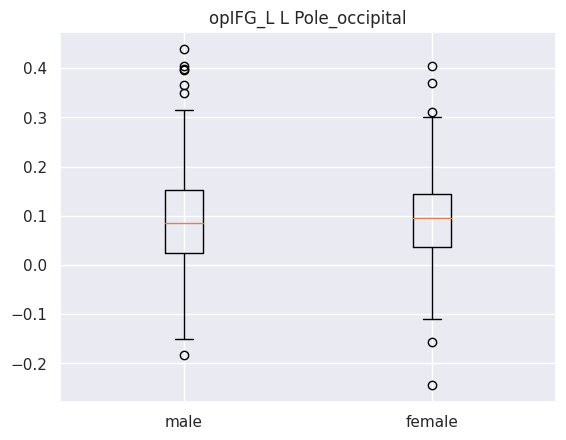

Ttest_indResult(statistic=0.5548409872567964, pvalue=0.5792241764342783)
male mean : 0.09943078458722433
male std : 0.10251638089430502
female mean : 0.09496818549693023
female std : 0.08814978179794535


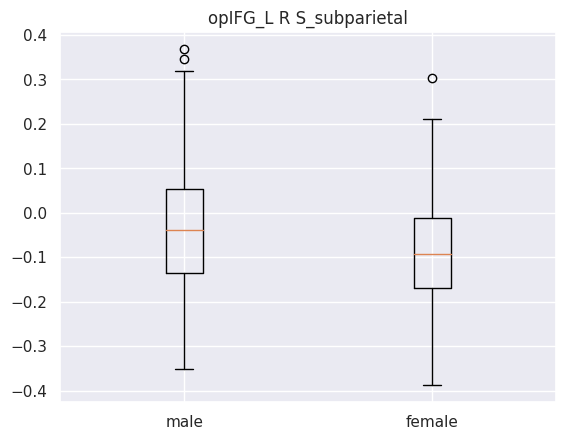

Ttest_indResult(statistic=4.627538320714266, pvalue=4.59863706792552e-06)
male mean : -0.0332647789439924
male std : 0.13808114412316164
female mean : -0.08209271020398672
female std : 0.11188499200043661


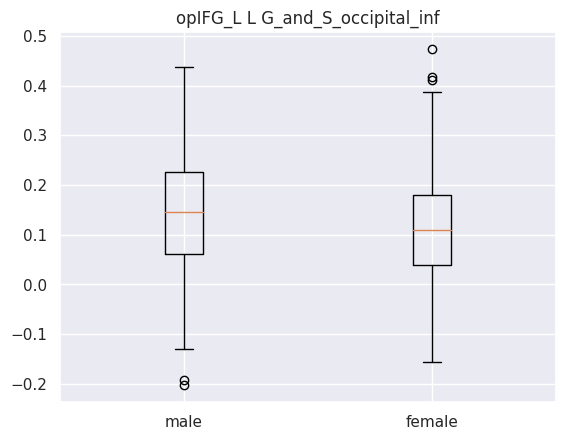

Ttest_indResult(statistic=3.3566638640413826, pvalue=0.000842207438429869)
male mean : 0.14831989778022814
male std : 0.12463081174073931
female mean : 0.11545700281893687
female std : 0.10745927496138906


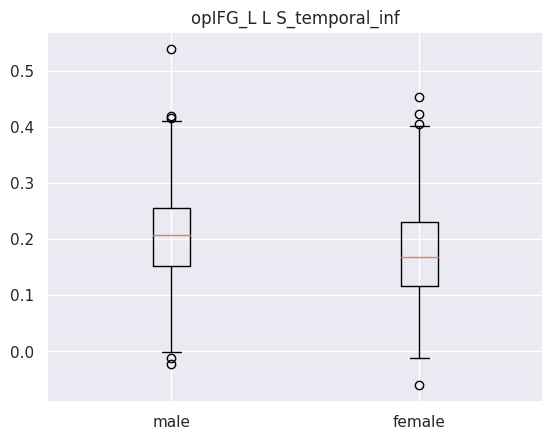

Ttest_indResult(statistic=4.969224929521562, pvalue=8.936260638966738e-07)
male mean : 0.20876997986996199
male std : 0.08663159707917586
female mean : 0.17289818290913622
female std : 0.08425570908329043
                                  Region       Men     Women       P value
0             opIFG_L - L S_temporal_sup  0.157560  0.115162  4.644482e-05
1      opIFG_L - L G_oc-temp_lat-fusifor  0.211650  0.166829  1.947666e-08
2            opIFG_L - R G_insular_short  0.257298  0.209469  6.398857e-08
3  opIFG_L - L S_oc-temp_med_and_Lingual  0.148861  0.107018  3.974326e-09
4               opIFG_L - L Lat_Fis-post  0.205084  0.150076  5.132542e-09
5      opIFG_L - L S_circular_insula_inf  0.179687  0.138314  1.145592e-08
6             opIFG_L - L Pole_occipital  0.099431  0.094968  5.792242e-01
7              opIFG_L - R S_subparietal -0.033265 -0.082093  4.598637e-06
8      opIFG_L - L G_and_S_occipital_inf  0.148320  0.115457  8.422074e-04
9             opIFG_L - L S_temporal_inf  0.2

In [74]:
rois = ["opIFG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_L)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_validation"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## opIFG_R validation accuracy

Validation accuracy
The mean accuracy : 0.7361089285714286
The standard deviation of the accuracy : 0.027649590761170482
The lower boundry of the confidance interval of the accuracy : 0.6819157306795345
The upper boundry of the confidance interval of the accuracy : 0.7903021264633228

Testing accuracy
     coefficient     seed                       labels
71      0.189041  opIFG_R             L S_temporal_inf
91      0.182531  opIFG_R            R G_insular_short
47      0.177105  opIFG_R      L S_circular_insula_inf
80      0.164462  opIFG_R     R G_and_S_cingul-Mid-Ant
60      0.163928  opIFG_R  L S_oc-temp_med_and_Lingual
51      0.150892  opIFG_R                L S_front_inf
63      0.149513  opIFG_R         L S_orbital-H_Shaped
15      0.147411  opIFG_R                L G_front_sup
20      0.146205  opIFG_R      L G_oc-temp_lat-fusifor
108     0.144561  opIFG_R      R G_temp_sup-Plan_polar
The mean accuracy : 0.7361089285714286
The standard deviation of the accuracy : 0.0276495907

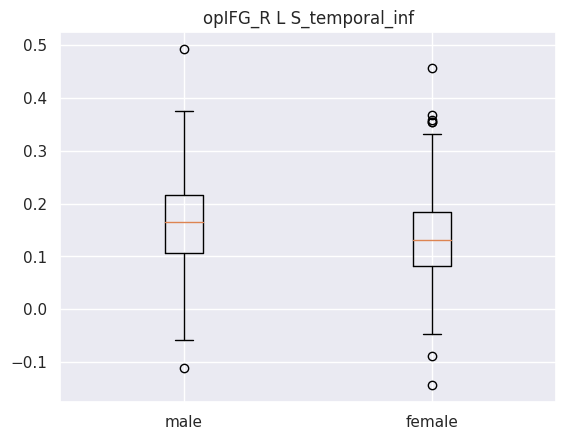

Ttest_indResult(statistic=3.999304532057945, pvalue=7.201816739594884e-05)
male mean : 0.16359765884543725
male std : 0.08562013938577182
female mean : 0.13553582025435218
female std : 0.08060550060216903


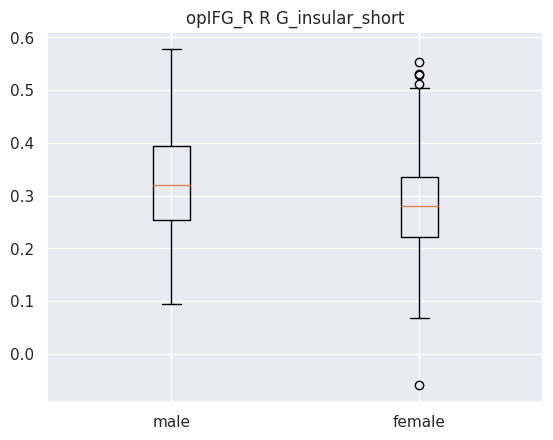

Ttest_indResult(statistic=4.755239251404364, pvalue=2.5221004207170377e-06)
male mean : 0.3230140808745247
male std : 0.09676265794418758
female mean : 0.28459807252159475
female std : 0.09446074604336126


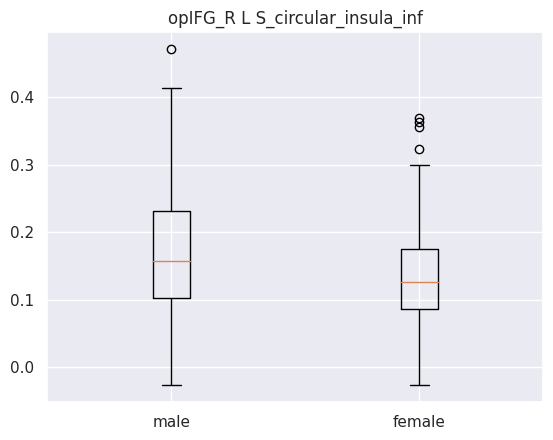

Ttest_indResult(statistic=4.729506412940881, pvalue=2.84980032551188e-06)
male mean : 0.16831194070988592
male std : 0.08857256780970121
female mean : 0.13581089123421927
female std : 0.07430472106915549


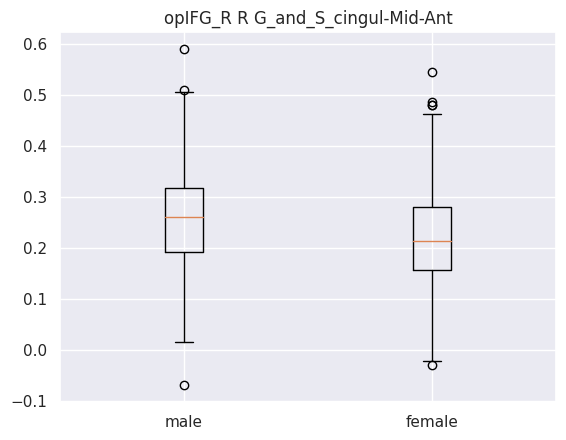

Ttest_indResult(statistic=4.315955845337449, pvalue=1.878004856996765e-05)
male mean : 0.2591957626121673
male std : 0.10347717348701288
female mean : 0.22244813224916943
female std : 0.09819716159475382


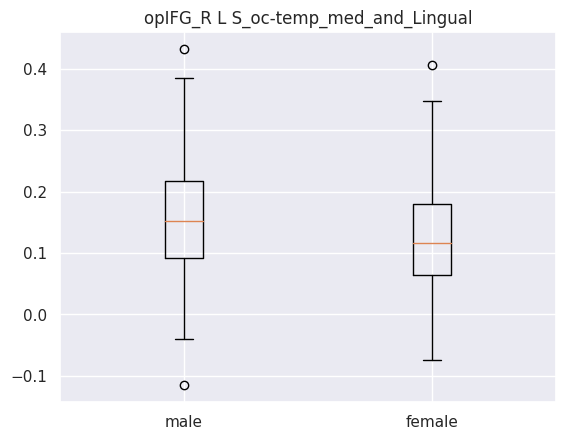

Ttest_indResult(statistic=4.683575774370304, pvalue=3.539150807108733e-06)
male mean : 0.15626952140722436
male std : 0.09076863914735202
female mean : 0.12206103295259137
female std : 0.08235156931391527


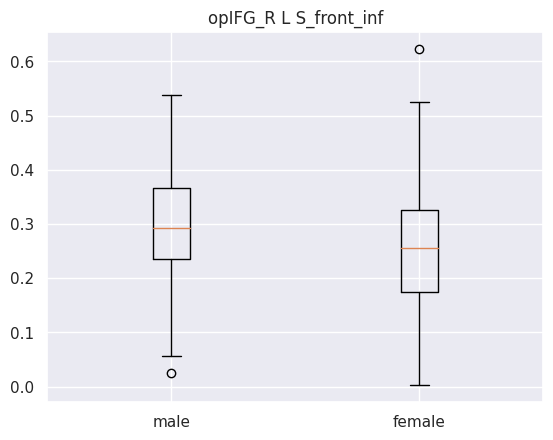

Ttest_indResult(statistic=4.552274802708165, pvalue=6.50948302187859e-06)
male mean : 0.29556017243726235
male std : 0.10059916181337628
female mean : 0.2551695035348837
female std : 0.1085741115925798


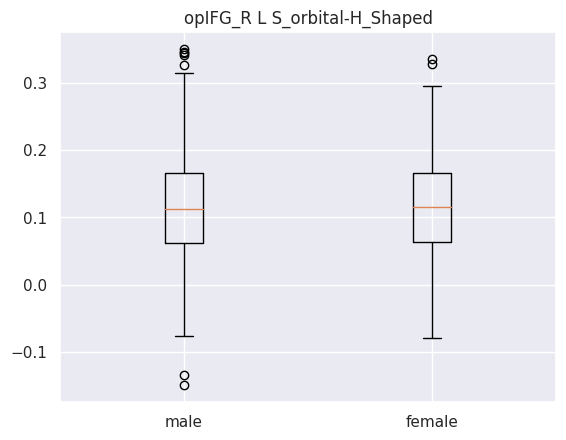

Ttest_indResult(statistic=0.08018520363953263, pvalue=0.9361185029164663)
male mean : 0.11674467021026617
male std : 0.08427527214237461
female mean : 0.11619735501554818
female std : 0.07748459590176046


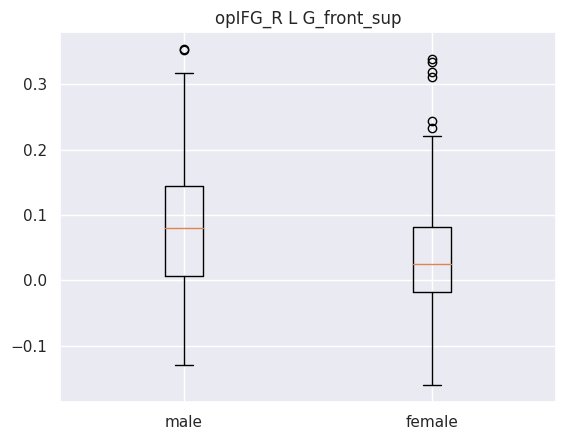

Ttest_indResult(statistic=5.840874265006819, pvalue=8.794027366847957e-09)
male mean : 0.07910377020205323
male std : 0.091464100075273
female mean : 0.03652195184581396
female std : 0.08135719231531187


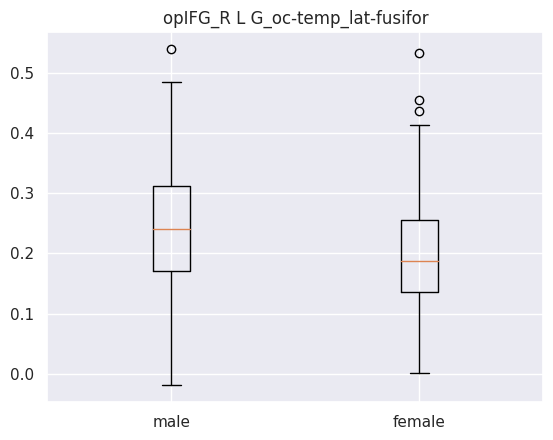

Ttest_indResult(statistic=5.116446900273248, pvalue=4.279565875230344e-07)
male mean : 0.23781104919391638
male std : 0.10129659013704502
female mean : 0.19701569446046513
female std : 0.08772269101356905


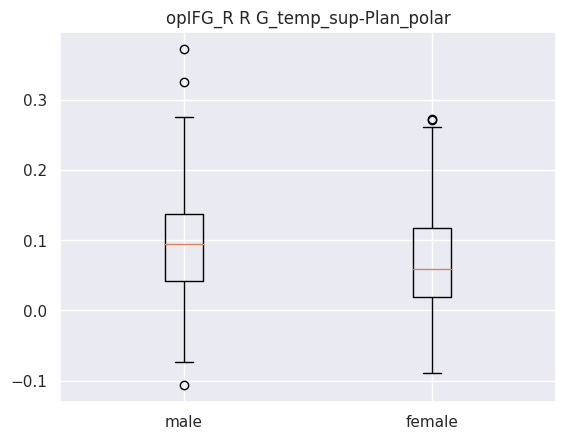

Ttest_indResult(statistic=3.998178487567644, pvalue=7.235199191609884e-05)
male mean : 0.09452694148326996
male std : 0.07617182305141224
female mean : 0.07004874881162791
female std : 0.06894506297581188
                                  Region       Men     Women       P value
0             opIFG_R - L S_temporal_inf  0.163598  0.135536  7.201817e-05
1            opIFG_R - R G_insular_short  0.323014  0.284598  2.522100e-06
2      opIFG_R - L S_circular_insula_inf  0.168312  0.135811  2.849800e-06
3     opIFG_R - R G_and_S_cingul-Mid-Ant  0.259196  0.222448  1.878005e-05
4  opIFG_R - L S_oc-temp_med_and_Lingual  0.156270  0.122061  3.539151e-06
5                opIFG_R - L S_front_inf  0.295560  0.255170  6.509483e-06
6         opIFG_R - L S_orbital-H_Shaped  0.116745  0.116197  9.361185e-01
7                opIFG_R - L G_front_sup  0.079104  0.036522  8.794027e-09
8      opIFG_R - L G_oc-temp_lat-fusifor  0.237811  0.197016  4.279566e-07
9      opIFG_R - R G_temp_sup-Plan_polar  0.0

In [75]:
rois = ["opIFG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_R)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_validation"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## pITG_L validation accuracy

Validation accuracy
The mean accuracy : 0.7242401785714286
The standard deviation of the accuracy : 0.03340634037138652
The lower boundry of the confidance interval of the accuracy : 0.6587637514435111
The upper boundry of the confidance interval of the accuracy : 0.7897166056993462

Testing accuracy
    coefficient    seed                       labels
55     0.213766  pITG_L  L S_intrapariet_and_P_trans
20     0.213608  pITG_L      L G_oc-temp_lat-fusifor
47     0.185665  pITG_L      L S_circular_insula_inf
75     0.178565  pITG_L      R G_and_S_occipital_inf
9      0.174666  pITG_L      L G_cingul-Post-ventral
26     0.174043  pITG_L             L G_parietal_sup
72     0.159266  pITG_L             L S_temporal_sup
83     0.154205  pITG_L      R G_cingul-Post-ventral
89     0.143096  pITG_L                R G_front_sup
86     0.141941  pITG_L        R G_front_inf-Orbital
The mean accuracy : 0.7242401785714286
The standard deviation of the accuracy : 0.03340634037138652
The lower bound

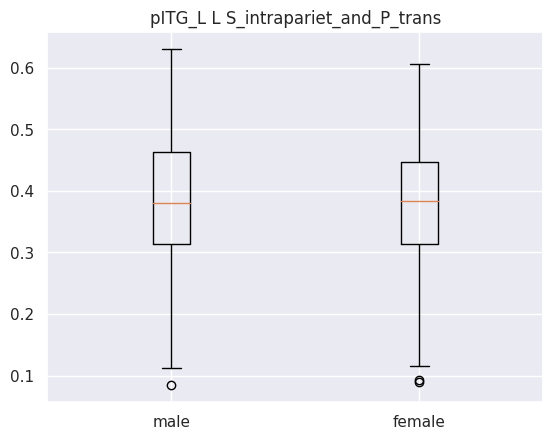

Ttest_indResult(statistic=0.27040597084376106, pvalue=0.7869472193855935)
male mean : 0.38125740577946765
male std : 0.107535777846271
female mean : 0.37889768367441856
female std : 0.0992636491621393


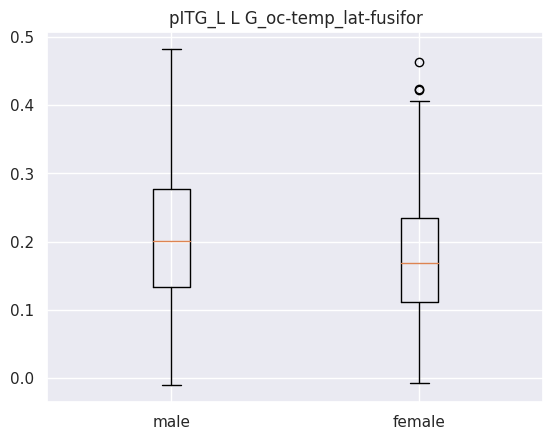

Ttest_indResult(statistic=3.2436073154022718, pvalue=0.001250320411852697)
male mean : 0.2056987803380228
male std : 0.0949520263388171
female mean : 0.18023744266279068
female std : 0.09094138289806177


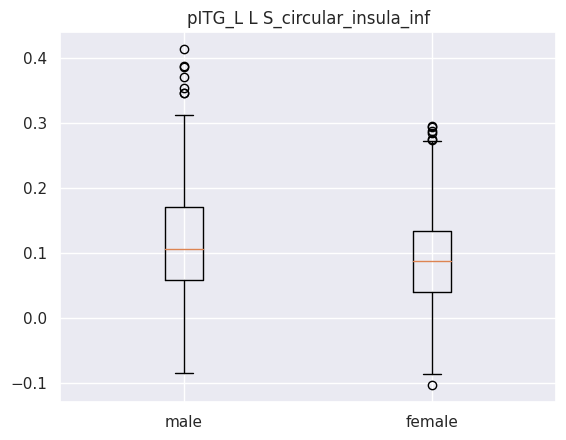

Ttest_indResult(statistic=3.7195183926587134, pvalue=0.00021963865781551026)
male mean : 0.1174053472373384
male std : 0.08606189513888665
female mean : 0.09239644204584717
female std : 0.07332099633027676


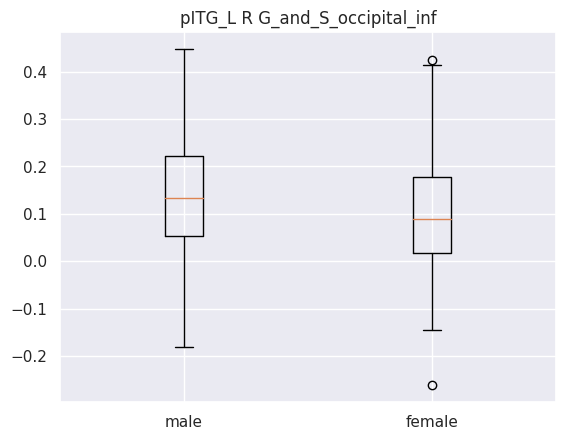

Ttest_indResult(statistic=3.1426765548050595, pvalue=0.0017623399666327859)
male mean : 0.13541462136387833
male std : 0.12025345869257073
female mean : 0.10348527198348836
female std : 0.12006823679231758


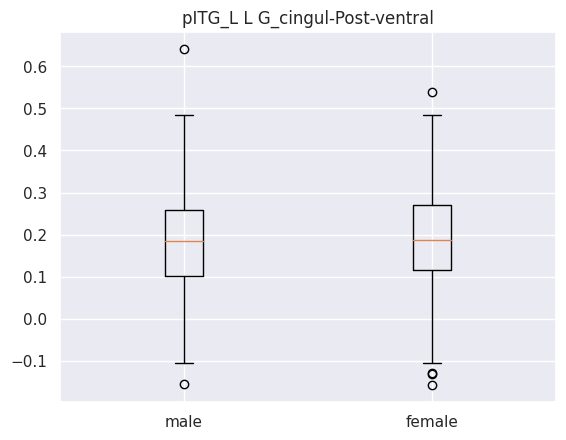

Ttest_indResult(statistic=-0.6639053665916427, pvalue=0.5070231460745944)
male mean : 0.18444210613802278
male std : 0.11264807940923946
female mean : 0.19087066787209303
female std : 0.11611943916831628


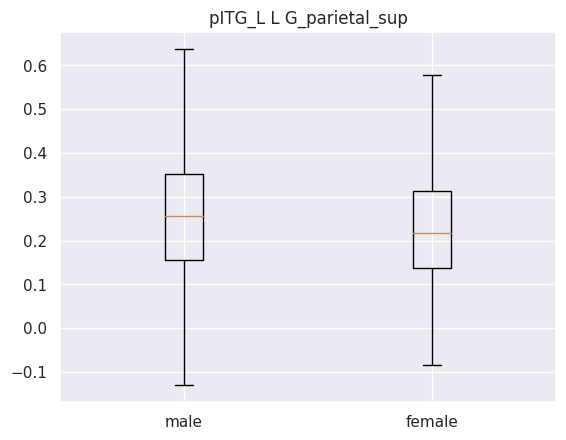

Ttest_indResult(statistic=2.0348237485458296, pvalue=0.04233743219572547)
male mean : 0.25056911626197714
male std : 0.14008685738222976
female mean : 0.22777261343820598
female std : 0.1254813999066985


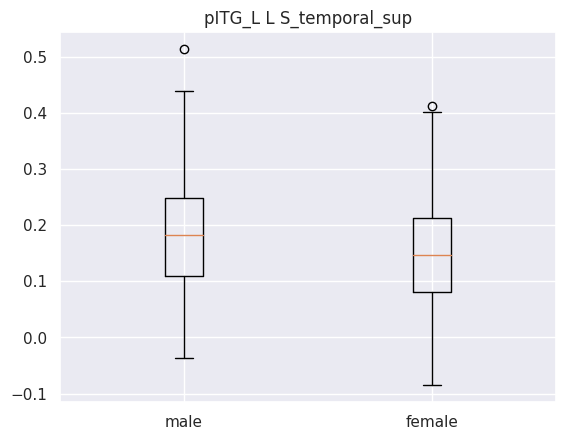

Ttest_indResult(statistic=4.088541314494515, pvalue=4.974571895058776e-05)
male mean : 0.18421520673802283
male std : 0.09953793105497917
female mean : 0.1500996249284053
female std : 0.09792655458301218


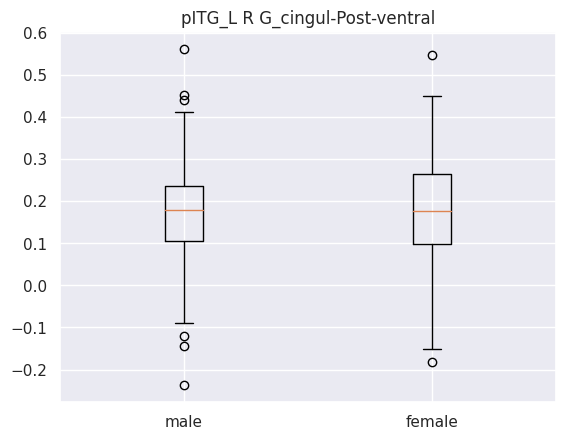

Ttest_indResult(statistic=-0.7087886870276421, pvalue=0.47874952082168243)
male mean : 0.17141985658456652
male std : 0.11182081650600385
female mean : 0.17828767616757477
female std : 0.11695861702316826


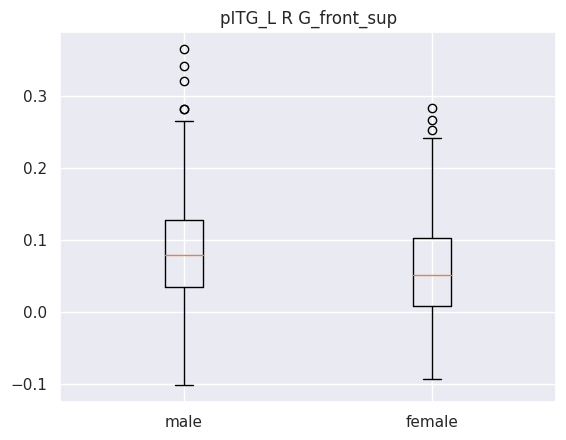

Ttest_indResult(statistic=4.517242898316856, pvalue=7.639659654387745e-06)
male mean : 0.08677324134414449
male std : 0.07544822450822067
female mean : 0.059595708499700986
female std : 0.06717348737175934


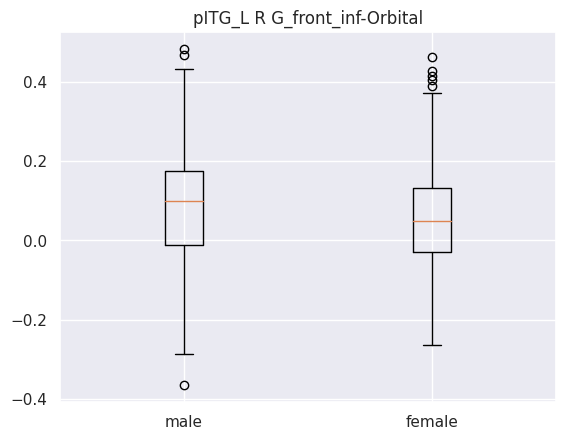

Ttest_indResult(statistic=2.4606260312415023, pvalue=0.014169135796902566)
male mean : 0.08827093163688214
male std : 0.14230262222275855
female mean : 0.05931472846877077
female std : 0.13637430223397143
                                 Region       Men     Women   P value
0  pITG_L - L S_intrapariet_and_P_trans  0.381257  0.378898  0.786947
1      pITG_L - L G_oc-temp_lat-fusifor  0.205699  0.180237  0.001250
2      pITG_L - L S_circular_insula_inf  0.117405  0.092396  0.000220
3      pITG_L - R G_and_S_occipital_inf  0.135415  0.103485  0.001762
4      pITG_L - L G_cingul-Post-ventral  0.184442  0.190871  0.507023
5             pITG_L - L G_parietal_sup  0.250569  0.227773  0.042337
6             pITG_L - L S_temporal_sup  0.184215  0.150100  0.000050
7      pITG_L - R G_cingul-Post-ventral  0.171420  0.178288  0.478750
8                pITG_L - R G_front_sup  0.086773  0.059596  0.000008
9        pITG_L - R G_front_inf-Orbital  0.088271  0.059315  0.014169


In [76]:
rois = ["pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_L)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_validation"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## pITG_R validation accuracy

Validation accuracy
The mean accuracy : 0.7206267857142857
The standard deviation of the accuracy : 0.02984763599285955
The lower boundry of the confidance interval of the accuracy : 0.662125419168281
The upper boundry of the confidance interval of the accuracy : 0.7791281522602904

Testing accuracy
     coefficient    seed                     labels
20      0.241122  pITG_R    L G_oc-temp_lat-fusifor
72      0.240592  pITG_R           L S_temporal_sup
83      0.183790  pITG_R    R G_cingul-Post-ventral
84      0.180579  pITG_R                 R G_cuneus
108     0.159383  pITG_R    R G_temp_sup-Plan_polar
91      0.156470  pITG_R          R G_insular_short
47      0.155728  pITG_R    L S_circular_insula_inf
125     0.150745  pITG_R              R S_front_inf
90      0.140462  pITG_R  R G_Ins_lg_and_S_cent_ins
106     0.124293  pITG_R    R G_temp_sup-G_T_transv
The mean accuracy : 0.7206267857142857
The standard deviation of the accuracy : 0.02984763599285955
The lower boundry of the co

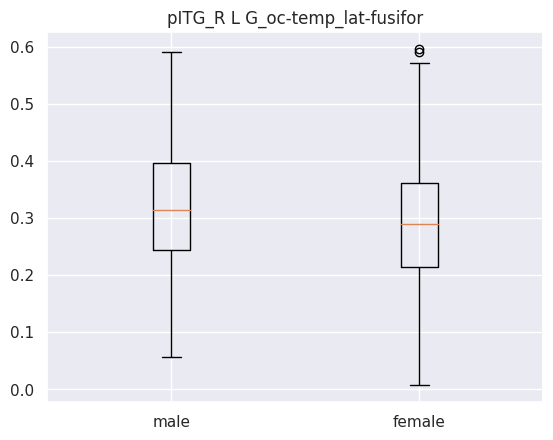

Ttest_indResult(statistic=2.810268986820924, pvalue=0.0051225200608808474)
male mean : 0.31478116888212926
male std : 0.11000102327816882
female mean : 0.2893303569966777
female std : 0.10450615876501394


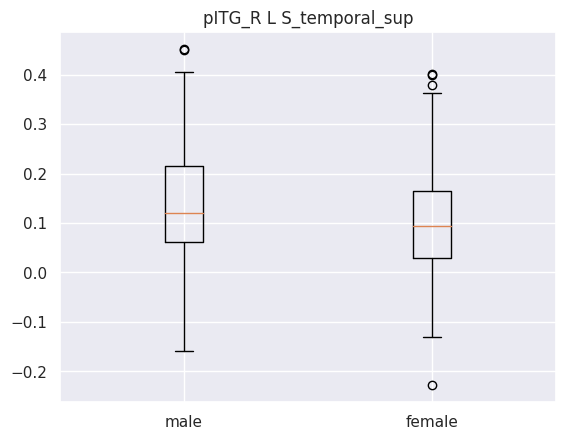

Ttest_indResult(statistic=4.196741356631083, pvalue=3.1469933747888905e-05)
male mean : 0.13739067075551334
male std : 0.11150382462376025
female mean : 0.09954083086165548
female std : 0.10224021375654369


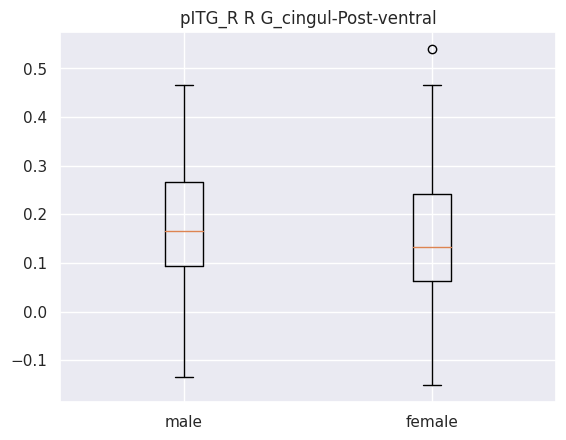

Ttest_indResult(statistic=2.256297345157703, pvalue=0.024435481782569664)
male mean : 0.1744766429752852
male std : 0.12132968449125979
female mean : 0.15124980597607973
female std : 0.12210294696125819


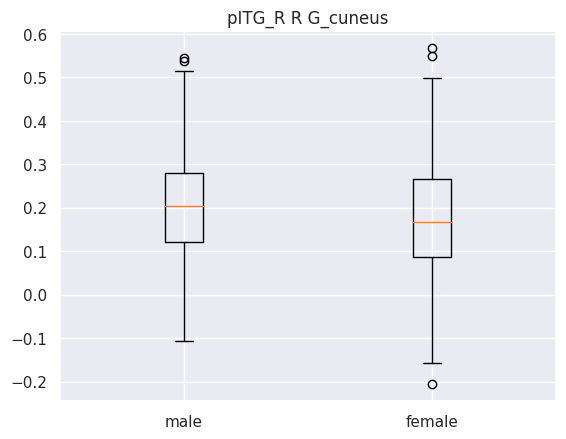

Ttest_indResult(statistic=2.741944633725931, pvalue=0.006302259674511262)
male mean : 0.20491106910646387
male std : 0.1253061895987554
female mean : 0.17536686928538206
female std : 0.12925281281347495


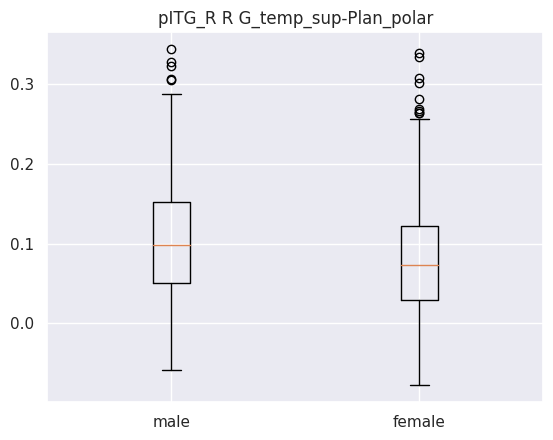

Ttest_indResult(statistic=3.829041740563084, pvalue=0.00014311201699602173)
male mean : 0.10721168719125476
male std : 0.07701199955956235
female mean : 0.08294021107918272
female std : 0.07312878001906238


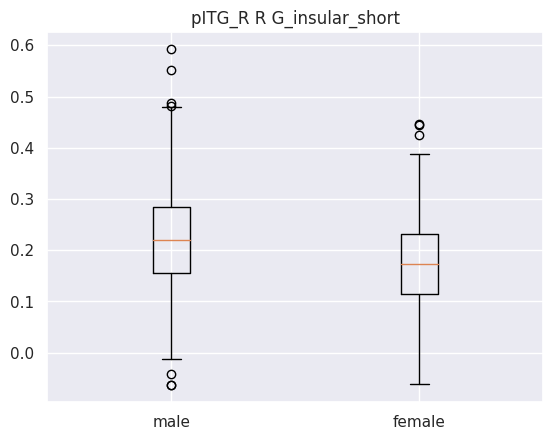

Ttest_indResult(statistic=5.697103263903745, pvalue=1.9674615344309902e-08)
male mean : 0.2223536750768061
male std : 0.10572708474473759
female mean : 0.1753717551358804
female std : 0.08975183305485177


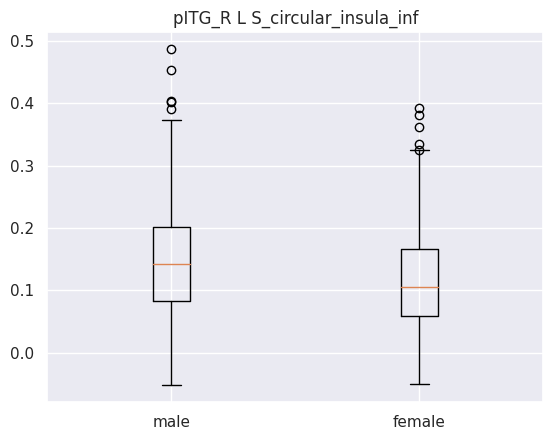

Ttest_indResult(statistic=4.781913144179267, pvalue=2.220814202786064e-06)
male mean : 0.15037180967528518
male std : 0.09196590825401321
female mean : 0.1155669789617608
female std : 0.08058036286207322


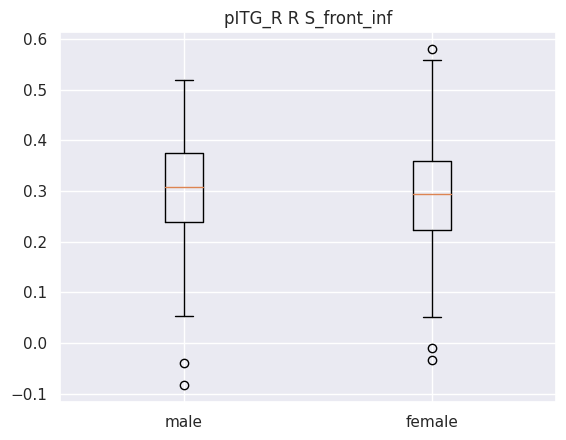

Ttest_indResult(statistic=1.6379189328233394, pvalue=0.10199833222671245)
male mean : 0.3043051077718631
male std : 0.0983610871491745
female mean : 0.29073446122923585
female std : 0.09765466159601431


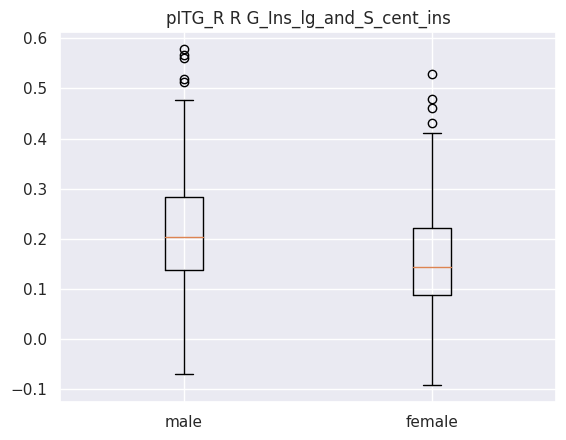

Ttest_indResult(statistic=5.486391849912401, pvalue=6.211989721615117e-08)
male mean : 0.21126798055245247
male std : 0.11577453686272864
female mean : 0.15978842567976745
female std : 0.10659117860011406


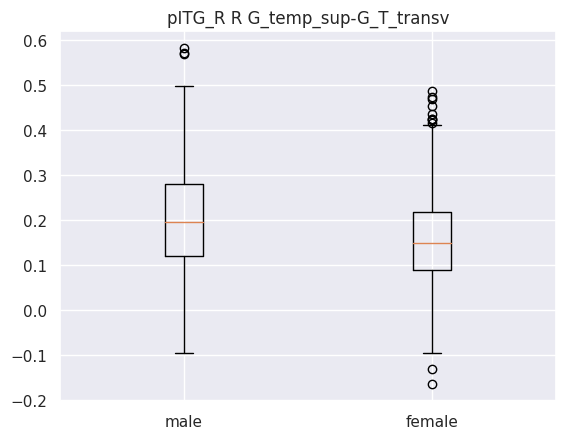

Ttest_indResult(statistic=4.858246945744738, pvalue=1.5379842834630926e-06)
male mean : 0.20724551101216732
male std : 0.12132483078283902
female mean : 0.16001330873255815
female std : 0.10912756866493428
                               Region       Men     Women       P value
0    pITG_R - L G_oc-temp_lat-fusifor  0.314781  0.289330  5.122520e-03
1           pITG_R - L S_temporal_sup  0.137391  0.099541  3.146993e-05
2    pITG_R - R G_cingul-Post-ventral  0.174477  0.151250  2.443548e-02
3                 pITG_R - R G_cuneus  0.204911  0.175367  6.302260e-03
4    pITG_R - R G_temp_sup-Plan_polar  0.107212  0.082940  1.431120e-04
5          pITG_R - R G_insular_short  0.222354  0.175372  1.967462e-08
6    pITG_R - L S_circular_insula_inf  0.150372  0.115567  2.220814e-06
7              pITG_R - R S_front_inf  0.304305  0.290734  1.019983e-01
8  pITG_R - R G_Ins_lg_and_S_cent_ins  0.211268  0.159788  6.211990e-08
9    pITG_R - R G_temp_sup-G_T_transv  0.207246  0.160013  1.537984e-06


In [77]:
rois = ["pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_R)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_validation"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## planumtemp_L validation accuracy

Validation accuracy
The mean accuracy : 0.6802214285714285
The standard deviation of the accuracy : 0.030724210605757453
The lower boundry of the confidance interval of the accuracy : 0.620001975784144
The upper boundry of the confidance interval of the accuracy : 0.7404408813587131

Testing accuracy
     coefficient          seed                       labels
60      0.269730  planumtemp_L  L S_oc-temp_med_and_Lingual
20      0.195096  planumtemp_L      L G_oc-temp_lat-fusifor
89      0.177836  planumtemp_L                R G_front_sup
108     0.171558  planumtemp_L      R G_temp_sup-Plan_polar
88      0.168184  planumtemp_L             R G_front_middle
30      0.167231  planumtemp_L                   L G_rectus
15      0.162346  planumtemp_L                L G_front_sup
43      0.152828  planumtemp_L                L S_calcarine
84      0.150454  planumtemp_L                   R G_cuneus
46      0.148583  planumtemp_L      L S_circular_insula_ant
The mean accuracy : 0.6802214285714285

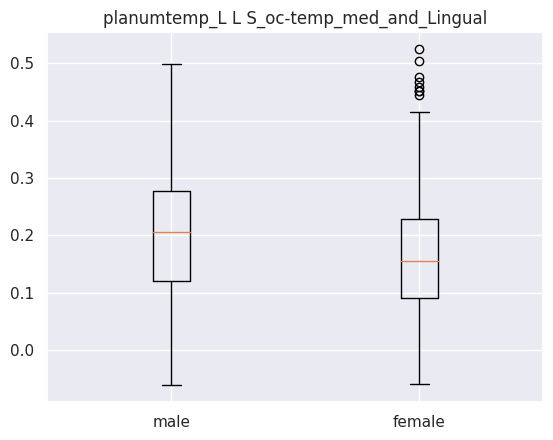

Ttest_indResult(statistic=3.5535200840172108, pvalue=0.0004120710964530877)
male mean : 0.20138468446653993
male std : 0.10697193315909369
female mean : 0.1691071645282392
female std : 0.10781293661679399


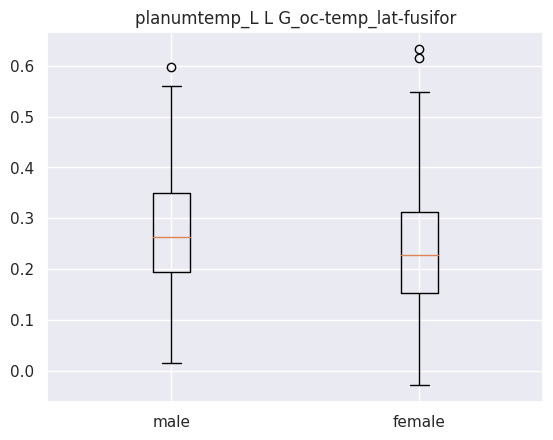

Ttest_indResult(statistic=3.8640363181268467, pvalue=0.00012453051309743143)
male mean : 0.273934721608365
male std : 0.11618899538515358
female mean : 0.23664216192325582
female std : 0.11231573519663951


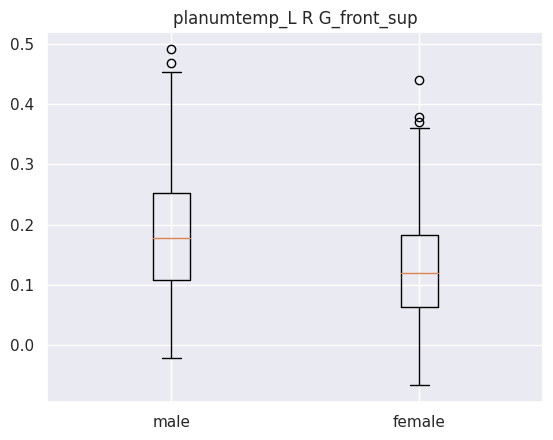

Ttest_indResult(statistic=7.005723286524496, pvalue=7.053092520728604e-12)
male mean : 0.1842207737676046
male std : 0.09752786905164766
female mean : 0.12974268123255814
female std : 0.08681164436850244


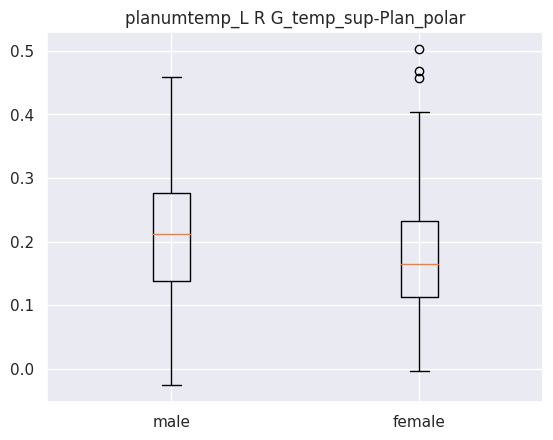

Ttest_indResult(statistic=4.754095906522838, pvalue=2.535856882720888e-06)
male mean : 0.2124789285969582
male std : 0.09186190010679225
female mean : 0.1759663873843854
female std : 0.08991669369361606


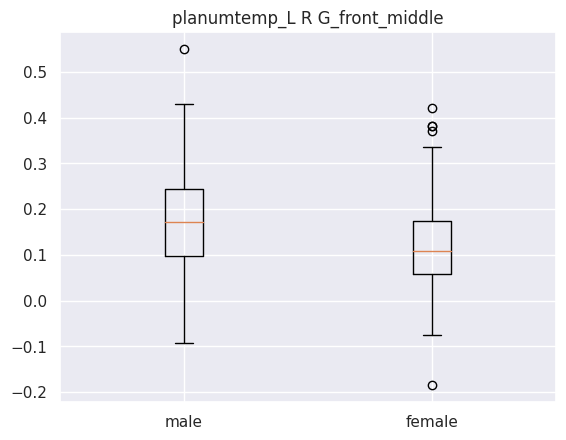

Ttest_indResult(statistic=7.083051952003173, pvalue=4.234418336006045e-12)
male mean : 0.17561467015703422
male std : 0.10099648809567767
female mean : 0.11818345196269103
female std : 0.09119635254658147


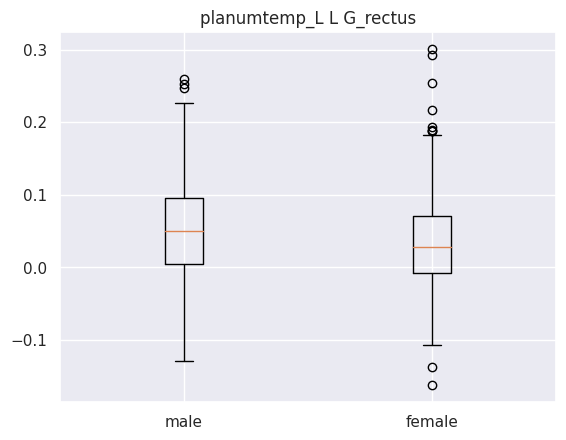

Ttest_indResult(statistic=2.7512545363189393, pvalue=0.006128244861950536)
male mean : 0.05109769466604562
male std : 0.07154061416307267
female mean : 0.035068776211362125
female std : 0.06650833816517755


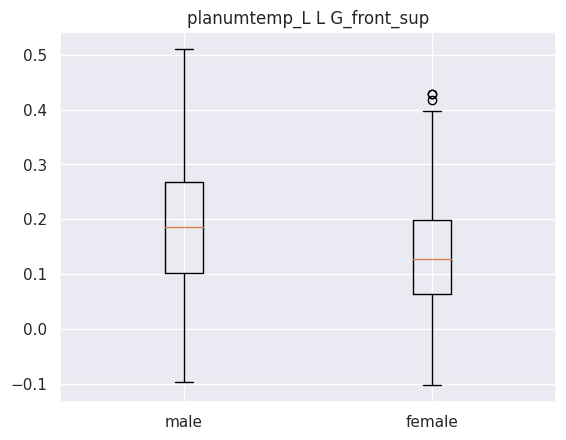

Ttest_indResult(statistic=5.407175582759948, pvalue=9.480994088922564e-08)
male mean : 0.1847222246946768
male std : 0.10853704509636099
female mean : 0.1378197862071096
female std : 0.0970820399251973


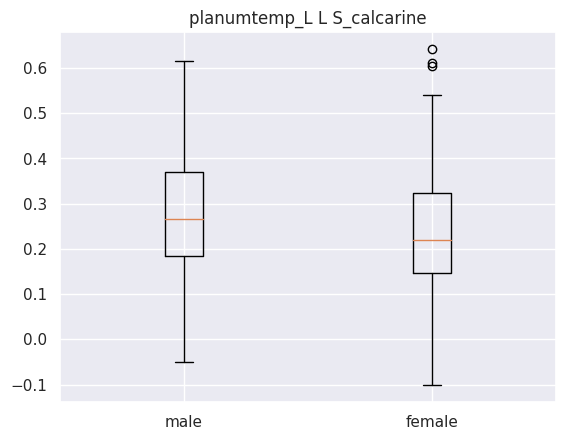

Ttest_indResult(statistic=3.141316233107298, pvalue=0.001770403211946406)
male mean : 0.274296150904943
male std : 0.1280515167012644
female mean : 0.2400809567398671
female std : 0.12947348397677685


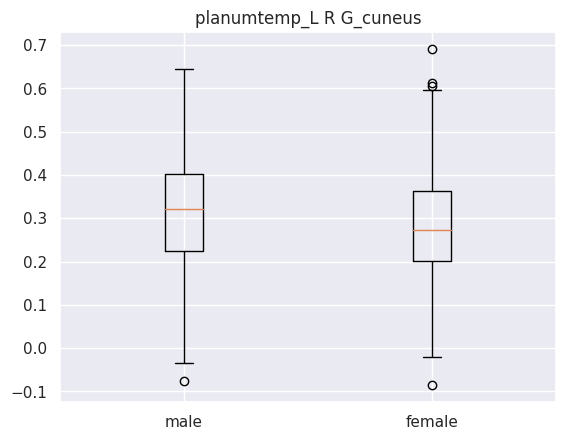

Ttest_indResult(statistic=2.6332203846527364, pvalue=0.008690739418219037)
male mean : 0.3126405191102661
male std : 0.13014578879944402
female mean : 0.28439145074983385
female std : 0.12394148026000948


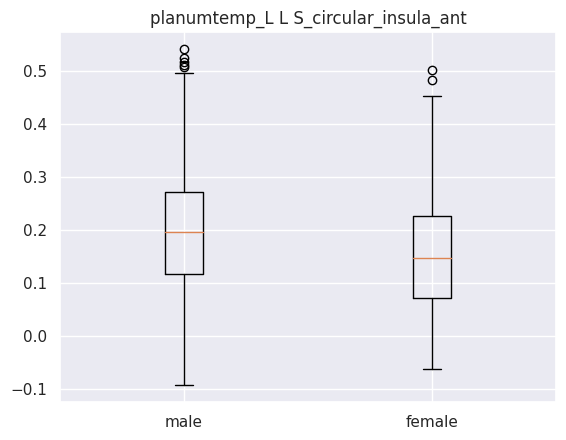

Ttest_indResult(statistic=5.295878089071948, pvalue=1.7022944020464566e-07)
male mean : 0.19804154381558936
male std : 0.11582912808678585
female mean : 0.1486483528654485
female std : 0.10523323363768806
                                       Region       Men     Women  \
0  planumtemp_L - L S_oc-temp_med_and_Lingual  0.201385  0.169107   
1      planumtemp_L - L G_oc-temp_lat-fusifor  0.273935  0.236642   
2                planumtemp_L - R G_front_sup  0.184221  0.129743   
3      planumtemp_L - R G_temp_sup-Plan_polar  0.212479  0.175966   
4             planumtemp_L - R G_front_middle  0.175615  0.118183   
5                   planumtemp_L - L G_rectus  0.051098  0.035069   
6                planumtemp_L - L G_front_sup  0.184722  0.137820   
7                planumtemp_L - L S_calcarine  0.274296  0.240081   
8                   planumtemp_L - R G_cuneus  0.312641  0.284391   
9      planumtemp_L - L S_circular_insula_ant  0.198042  0.148648   

        P value  
0  4.120711e-04  

In [79]:
rois = ["planumtemp_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_L)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_validation"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## planumtemp_R validation accuracy

Validation accuracy
The mean accuracy : 0.7092196428571429
The standard deviation of the accuracy : 0.029711164360010377
The lower boundry of the confidance interval of the accuracy : 0.6509857607115226
The upper boundry of the confidance interval of the accuracy : 0.7674535250027632

Testing accuracy
     coefficient          seed                       labels
47      0.239990  planumtemp_R      L S_circular_insula_inf
60      0.214674  planumtemp_R  L S_oc-temp_med_and_Lingual
72      0.197578  planumtemp_R             L S_temporal_sup
15      0.187386  planumtemp_R                L G_front_sup
108     0.178412  planumtemp_R      R G_temp_sup-Plan_polar
71      0.159834  planumtemp_R             L S_temporal_inf
139     0.159489  planumtemp_R             R S_pericallosal
43      0.156101  planumtemp_R                L S_calcarine
20      0.140083  planumtemp_R      L G_oc-temp_lat-fusifor
121     0.138312  planumtemp_R      R S_circular_insula_inf
The mean accuracy : 0.709219642857142

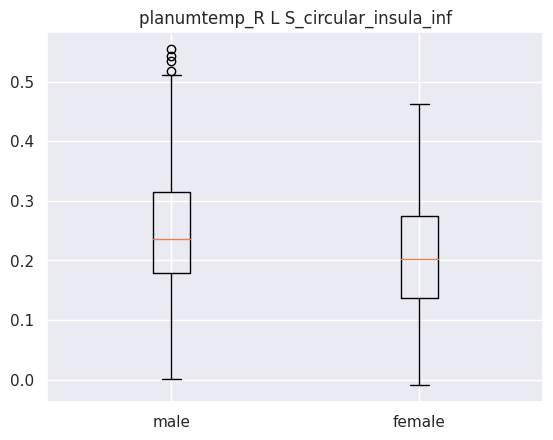

Ttest_indResult(statistic=4.754592848867569, pvalue=2.5298689374709147e-06)
male mean : 0.24664524678136882
male std : 0.09996404948497183
female mean : 0.20796517266445183
female std : 0.09280734872241128


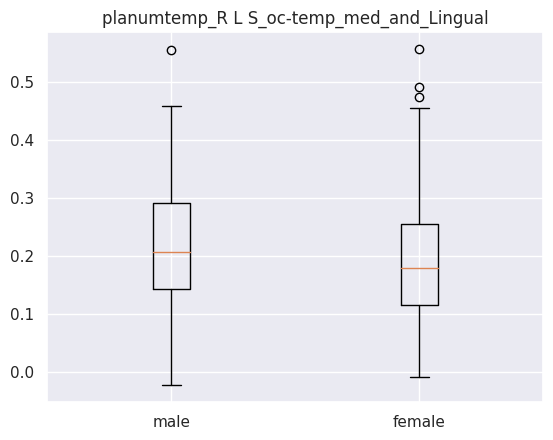

Ttest_indResult(statistic=2.8830998134021852, pvalue=0.004088548964724054)
male mean : 0.21623359568707226
male std : 0.10598136025556922
female mean : 0.1909124683142857
female std : 0.10198184189373703


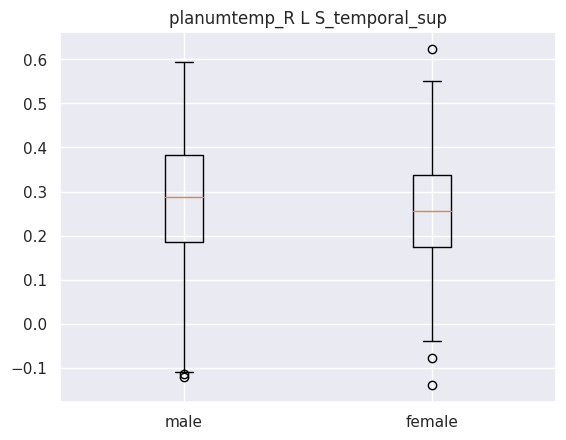

Ttest_indResult(statistic=1.9939713075469714, pvalue=0.04663794806816013)
male mean : 0.27949129047262355
male std : 0.13856078867444266
female mean : 0.2574814225966777
female std : 0.1231077975974857


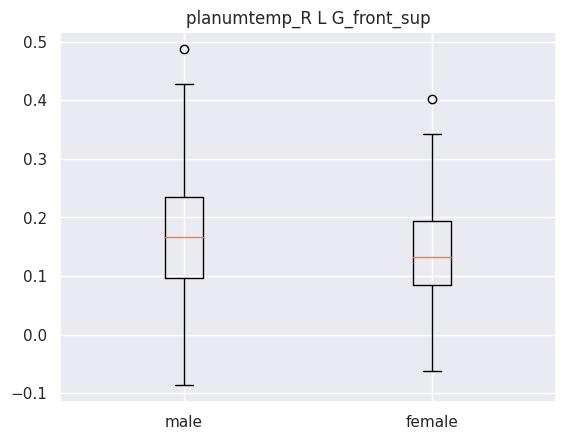

Ttest_indResult(statistic=3.245882136071958, pvalue=0.0012405568276112682)
male mean : 0.16498520389163499
male std : 0.09957579450944844
female mean : 0.1399915779053156
female std : 0.08291453993537845


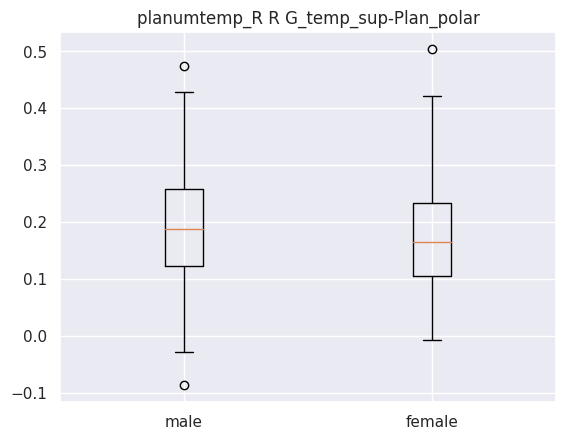

Ttest_indResult(statistic=2.321906417293724, pvalue=0.02059447944633167)
male mean : 0.19231692340304182
male std : 0.09008408764482337
female mean : 0.17497604091495014
female std : 0.08675608750582152


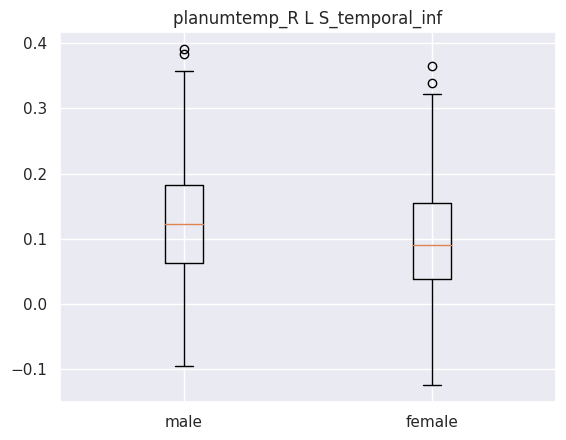

Ttest_indResult(statistic=4.049222830336931, pvalue=5.8603819974747696e-05)
male mean : 0.1273490176038023
male std : 0.08907206784454609
female mean : 0.09867424826245848
female std : 0.07880369672469549


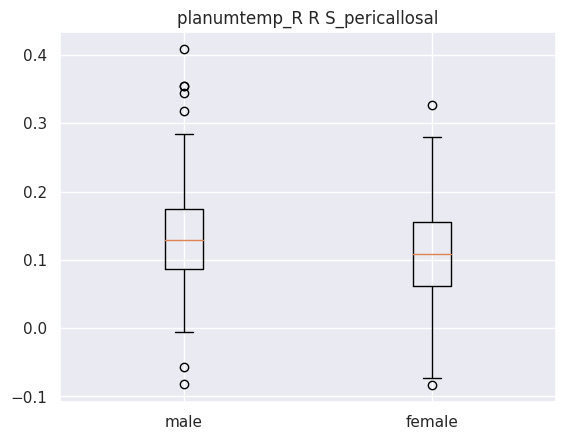

Ttest_indResult(statistic=4.21027853272709, pvalue=2.969654392292594e-05)
male mean : 0.13301439208163496
male std : 0.07336478835843015
female mean : 0.1079359846166113
female std : 0.06778752300317713


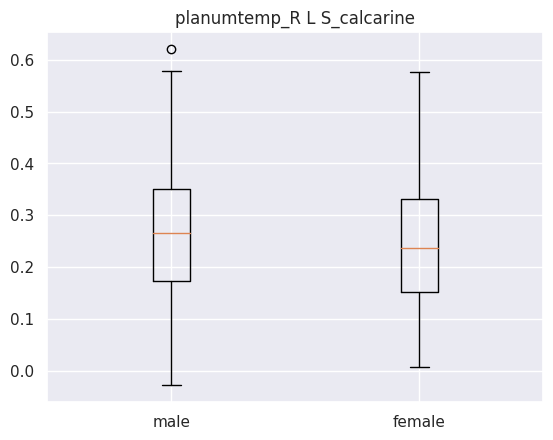

Ttest_indResult(statistic=2.002991768199032, pvalue=0.045657919237324006)
male mean : 0.26823541858505706
male std : 0.12784499132396293
female mean : 0.24731367291561462
female std : 0.11963048968200794


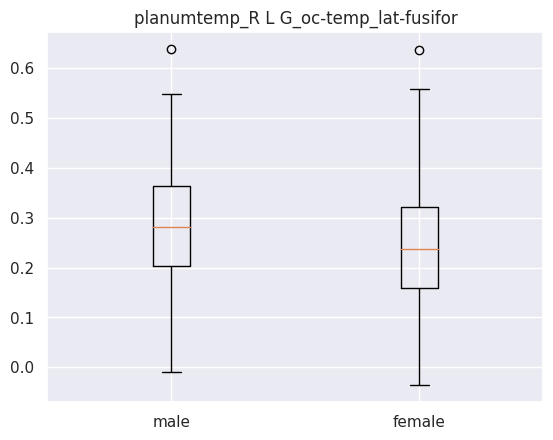

Ttest_indResult(statistic=4.153958282783595, pvalue=3.77618536555217e-05)
male mean : 0.28594790805589354
male std : 0.11929345196444417
female mean : 0.24477274405647842
female std : 0.11538894637809151


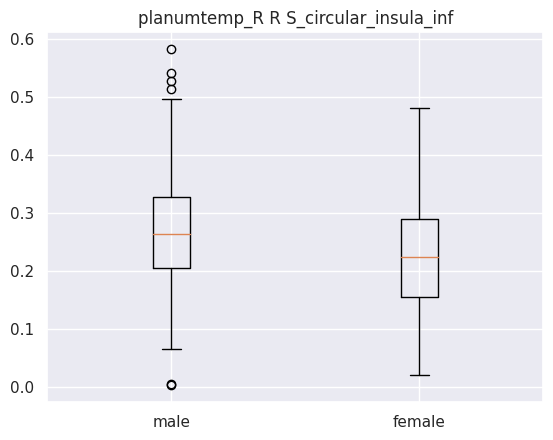

Ttest_indResult(statistic=4.926397277096471, pvalue=1.103284155465702e-06)
male mean : 0.2661869187410647
male std : 0.09527302507599171
female mean : 0.22700655812956813
female std : 0.09298067524697533
                                       Region       Men     Women   P value
0      planumtemp_R - L S_circular_insula_inf  0.246645  0.207965  0.000003
1  planumtemp_R - L S_oc-temp_med_and_Lingual  0.216234  0.190912  0.004089
2             planumtemp_R - L S_temporal_sup  0.279491  0.257481  0.046638
3                planumtemp_R - L G_front_sup  0.164985  0.139992  0.001241
4      planumtemp_R - R G_temp_sup-Plan_polar  0.192317  0.174976  0.020594
5             planumtemp_R - L S_temporal_inf  0.127349  0.098674  0.000059
6             planumtemp_R - R S_pericallosal  0.133014  0.107936  0.000030
7                planumtemp_R - L S_calcarine  0.268235  0.247314  0.045658
8      planumtemp_R - L G_oc-temp_lat-fusifor  0.285948  0.244773  0.000038
9      planumtemp_R - R S_circular_i

In [80]:
rois = ["planumtemp_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_R)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_validation"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## all left validation accuracy

Validation accuracy
The mean accuracy : 0.7675008928571428
The standard deviation of the accuracy : 0.03015307987989987
The lower boundry of the confidance interval of the accuracy : 0.7084008562925391
The upper boundry of the confidance interval of the accuracy : 0.8266009294217466

Testing accuracy
     coefficient          seed                       labels
55      0.099410       opIFG_L  L S_intrapariet_and_P_trans
98      0.098993       opIFG_L       R G_pariet_inf-Angular
351     0.094204        aMTG_L  L S_intrapariet_and_P_trans
53      0.090846       opIFG_L                L S_front_sup
112     0.087946       opIFG_L       R Lat_Fis-ant-Horizont
322     0.086944        aMTG_L             L G_parietal_sup
504     0.084873        pITG_L  L S_oc-temp_med_and_Lingual
189     0.081277  planumtemp_L             L Pole_occipital
64      0.080909       opIFG_L        L S_parieto_occipital
66      0.071706       opIFG_L              L S_postcentral
The mean accuracy : 0.7675008928571428

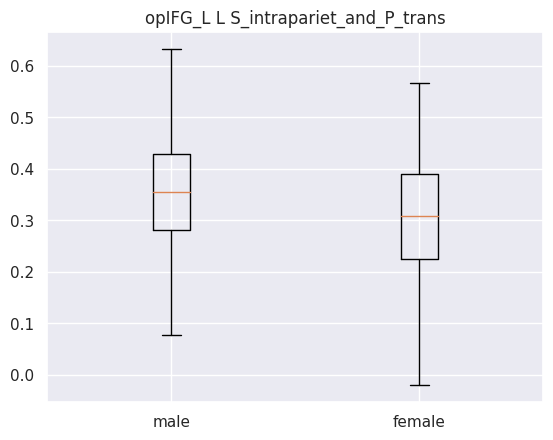

Ttest_indResult(statistic=5.055350828931209, pvalue=5.821781911163281e-07)
male mean : 0.35213074777946773
male std : 0.10658887449917556
female mean : 0.3031099729109635
female std : 0.12130464463020163


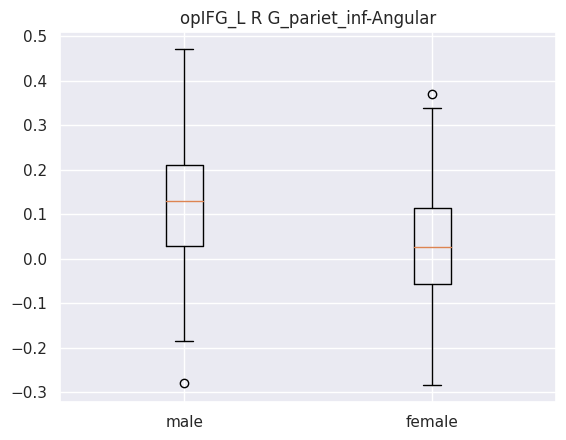

Ttest_indResult(statistic=7.716695110055561, pvalue=5.480751648776057e-14)
male mean : 0.11766997985152092
male std : 0.13076288558639354
female mean : 0.03601953544850498
female std : 0.12000095132461792


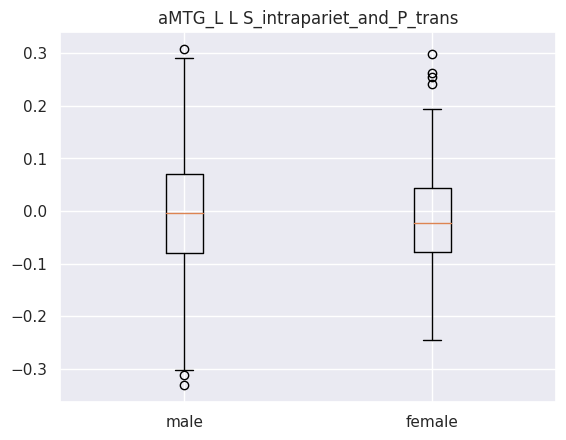

Ttest_indResult(statistic=0.9647641183387371, pvalue=0.3350779189775276)
male mean : -0.004121455086692014
male std : 0.11166920373773248
female mean : -0.012516677279534883
female std : 0.09459673974350062


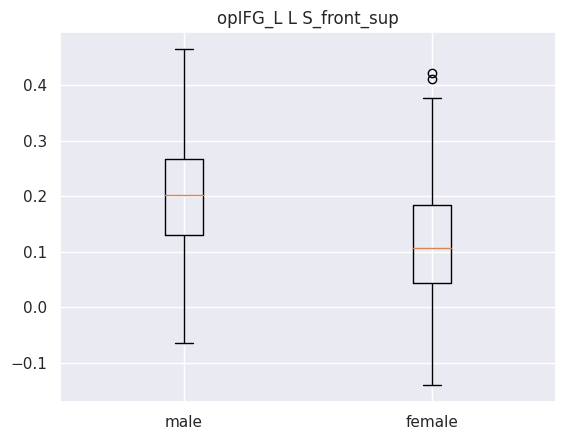

Ttest_indResult(statistic=10.006029115486237, pvalue=8.422510097736992e-22)
male mean : 0.1996858131581749
male std : 0.10098467263884126
female mean : 0.11606861896099667
female std : 0.09690605329034335


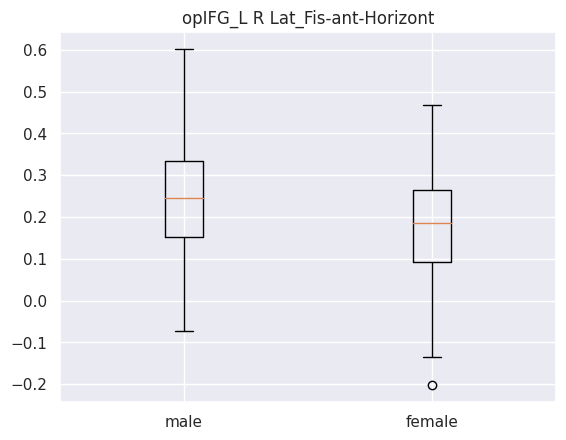

Ttest_indResult(statistic=5.523000631402005, pvalue=5.100505325642233e-08)
male mean : 0.24211566314486693
male std : 0.1271295065963186
female mean : 0.1834664979807309
female std : 0.1242192947210725


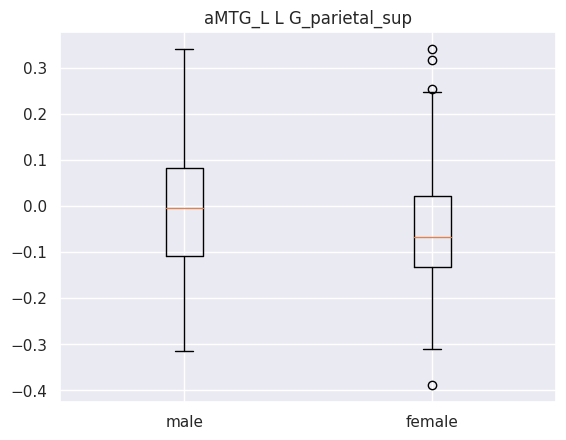

Ttest_indResult(statistic=4.059890719730225, pvalue=5.606265792321045e-05)
male mean : -0.006850357185019011
male std : 0.13629850229203536
female mean : -0.05038483464086378
female std : 0.11790512188118459


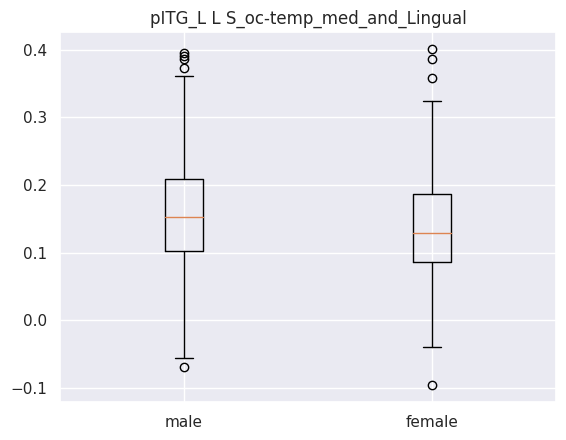

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
male std : 0.08334523805349907
female mean : 0.13959590949933556
female std : 0.07802101521527612


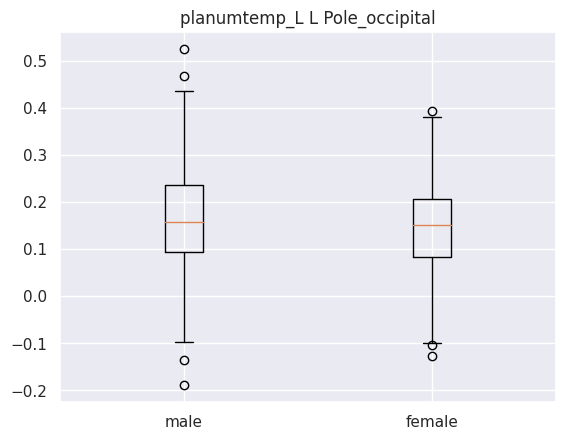

Ttest_indResult(statistic=2.486200541931443, pvalue=0.013200894125973316)
male mean : 0.16626784924790874
male std : 0.11264322709736568
female mean : 0.14439602449857145
female std : 0.09589248593995307


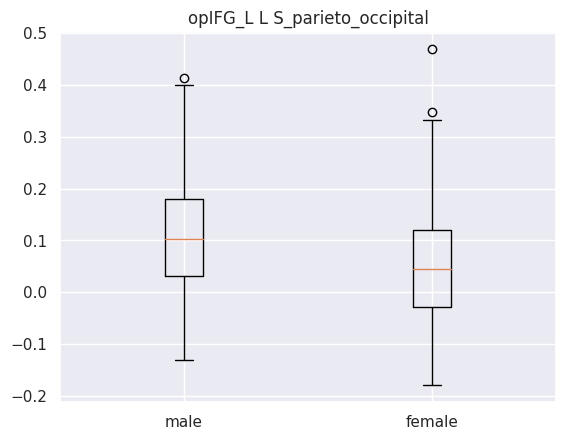

Ttest_indResult(statistic=6.503523668812626, pvalue=1.7355351061785972e-10)
male mean : 0.10978782784771862
male std : 0.10910224511601631
female mean : 0.05152286066817276
female std : 0.10312061557532284


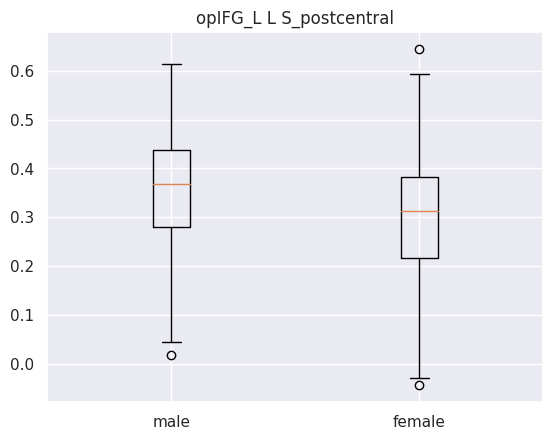

Ttest_indResult(statistic=6.164168782870945, pvalue=1.3532257302585482e-09)
male mean : 0.36117898896577944
male std : 0.11859452480530196
female mean : 0.29792533494119594
female std : 0.1237184139608429
                                  Region       Men     Women       P value
0  opIFG_L - L S_intrapariet_and_P_trans  0.352131  0.303110  5.821782e-07
1       opIFG_L - R G_pariet_inf-Angular  0.117670  0.036020  5.480752e-14
2   aMTG_L - L S_intrapariet_and_P_trans -0.004121 -0.012517  3.350779e-01
3                opIFG_L - L S_front_sup  0.199686  0.116069  8.422510e-22
4       opIFG_L - R Lat_Fis-ant-Horizont  0.242116  0.183466  5.100505e-08
5              aMTG_L - L G_parietal_sup -0.006850 -0.050385  5.606266e-05
6   pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  2.643129e-03
7        planumtemp_L - L Pole_occipital  0.166268  0.144396  1.320089e-02
8        opIFG_L - L S_parieto_occipital  0.109788  0.051523  1.735535e-10
9              opIFG_L - L S_postcentral  0.3

In [83]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_left)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_validation"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## all right validation accuracy

Validation accuracy
The mean accuracy : 0.7770482142857144
The standard deviation of the accuracy : 0.0259435090162555
The lower boundry of the confidance interval of the accuracy : 0.7261989366138536
The upper boundry of the confidance interval of the accuracy : 0.8278974919575751

Testing accuracy
     coefficient          seed                       labels
504     0.102792        pITG_R  L S_oc-temp_med_and_Lingual
55      0.096027       opIFG_R  L S_intrapariet_and_P_trans
66      0.095345       opIFG_R              L S_postcentral
64      0.095266       opIFG_R        L S_parieto_occipital
421     0.088880        aMTG_R                R S_front_inf
22      0.088466       opIFG_R      L G_oc-temp_med-Parahip
90      0.085020       opIFG_R    R G_Ins_lg_and_S_cent_ins
219     0.083776  planumtemp_R             L S_temporal_inf
487     0.083431        pITG_R                L S_calcarine
53      0.080852       opIFG_R                L S_front_sup
The mean accuracy : 0.7770482142857144


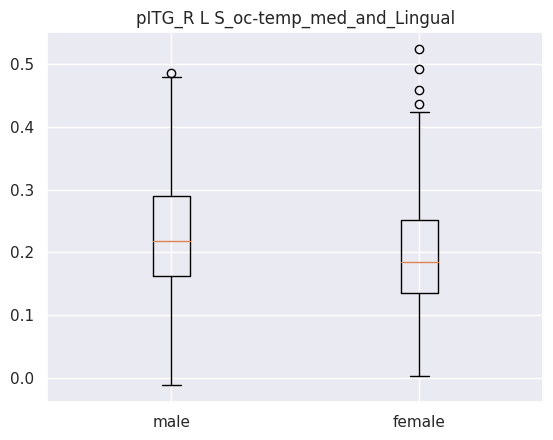

Ttest_indResult(statistic=3.658497216134596, pvalue=0.00027757468582203013)
male mean : 0.2244769810418251
male std : 0.09519528685578532
female mean : 0.19555248922657806
female std : 0.09199381053279175


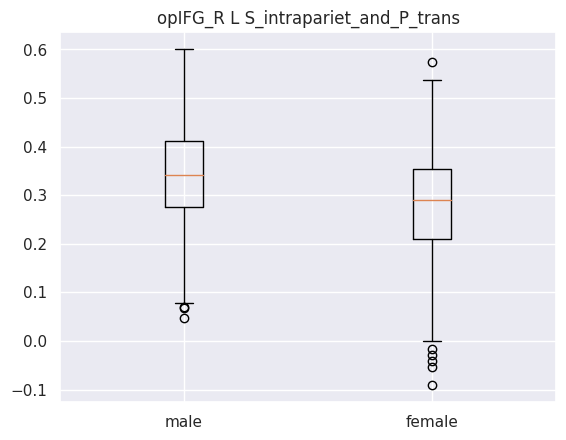

Ttest_indResult(statistic=6.549265565385064, pvalue=1.3068216656533926e-10)
male mean : 0.33881895684790875
male std : 0.1057801295230776
female mean : 0.2786800312584718
female std : 0.11099764729269487


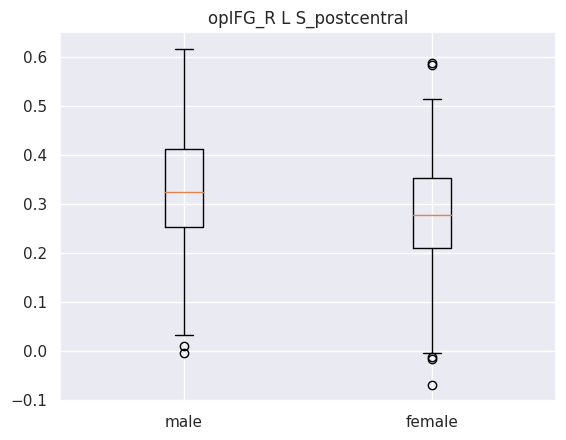

Ttest_indResult(statistic=5.271054566169988, pvalue=1.9369475536514105e-07)
male mean : 0.32780815557186316
male std : 0.11020463879720373
female mean : 0.27874649102691035
female std : 0.10996457294736237


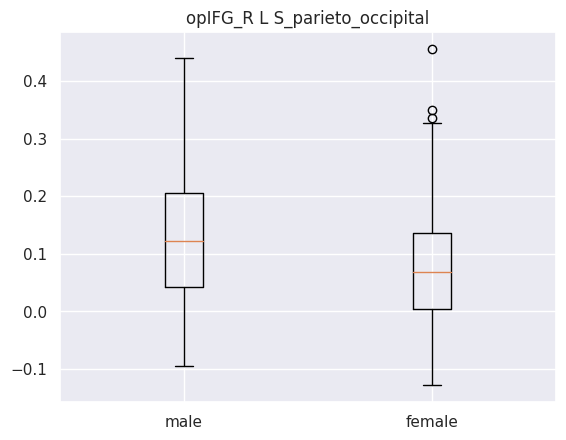

Ttest_indResult(statistic=6.286996654261317, pvalue=6.50249277681862e-10)
male mean : 0.13124042186996196
male std : 0.11092566474938649
female mean : 0.07599817451156146
female std : 0.09737712149945338


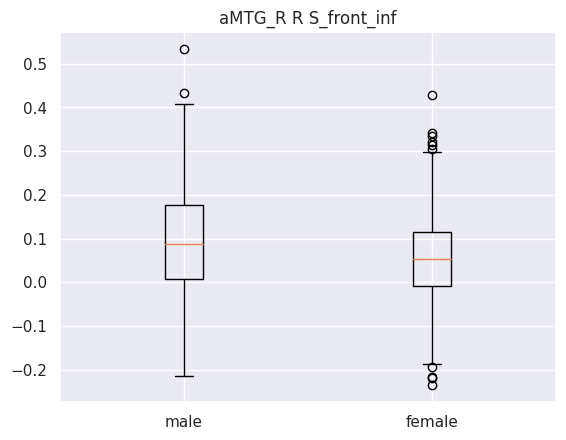

Ttest_indResult(statistic=4.148252422200393, pvalue=3.868639529214971e-05)
male mean : 0.09520096379193917
male std : 0.11824387845447384
female mean : 0.055367278695980064
female std : 0.10930840275035555


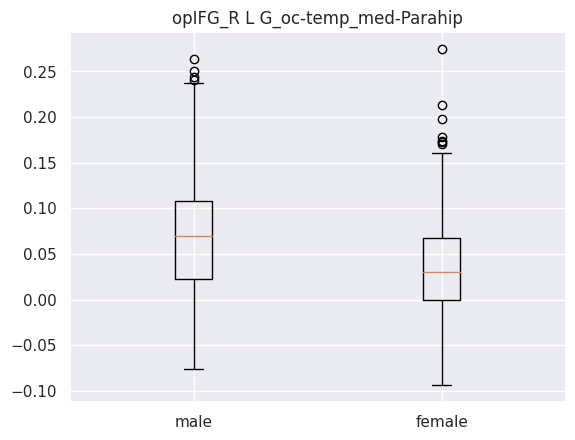

Ttest_indResult(statistic=6.251330329526955, pvalue=8.05447977290333e-10)
male mean : 0.06960421543711026
male std : 0.06330536688799167
female mean : 0.0386048876523588
female std : 0.054245949420823225


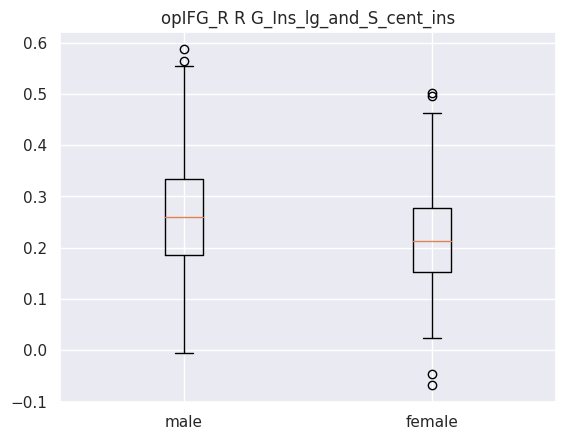

Ttest_indResult(statistic=5.071136490485997, pvalue=5.378396910376465e-07)
male mean : 0.26213691595703426
male std : 0.10720353737692727
female mean : 0.21789970354485053
female std : 0.0995023351316182


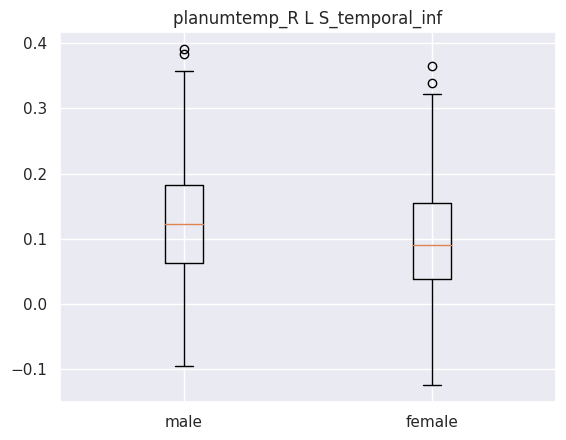

Ttest_indResult(statistic=4.049222830336931, pvalue=5.8603819974747696e-05)
male mean : 0.1273490176038023
male std : 0.08907206784454609
female mean : 0.09867424826245848
female std : 0.07880369672469549


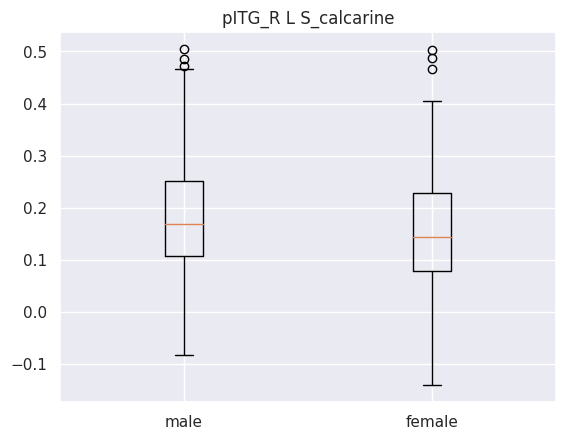

Ttest_indResult(statistic=3.2351347094550422, pvalue=0.0012873143650390924)
male mean : 0.18480961091102663
male std : 0.10817911899491708
female mean : 0.1554359898385382
female std : 0.10667308658653767


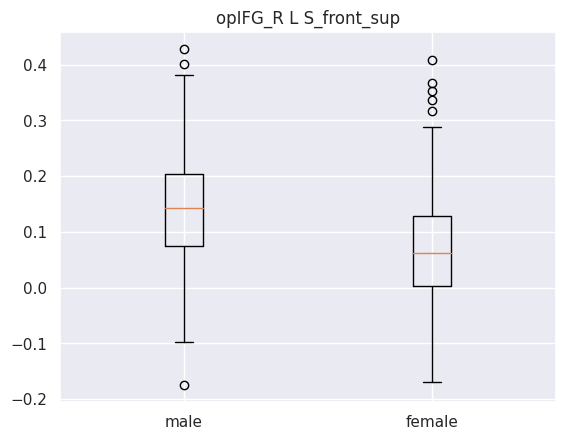

Ttest_indResult(statistic=8.712491197032197, pvalue=3.331022559866575e-17)
male mean : 0.14132478689695815
male std : 0.10025857372653
female mean : 0.06850368978538206
female std : 0.097597589175656
                                  Region       Men     Women       P value
0   pITG_R - L S_oc-temp_med_and_Lingual  0.224477  0.195552  2.775747e-04
1  opIFG_R - L S_intrapariet_and_P_trans  0.338819  0.278680  1.306822e-10
2              opIFG_R - L S_postcentral  0.327808  0.278746  1.936948e-07
3        opIFG_R - L S_parieto_occipital  0.131240  0.075998  6.502493e-10
4                 aMTG_R - R S_front_inf  0.095201  0.055367  3.868640e-05
5      opIFG_R - L G_oc-temp_med-Parahip  0.069604  0.038605  8.054480e-10
6    opIFG_R - R G_Ins_lg_and_S_cent_ins  0.262137  0.217900  5.378397e-07
7        planumtemp_R - L S_temporal_inf  0.127349  0.098674  5.860382e-05
8                 pITG_R - L S_calcarine  0.184810  0.155436  1.287314e-03
9                opIFG_R - L S_front_sup  0.141325

In [84]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_right)

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_validation"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Test classification feature by feature on an independent set

In [87]:
# the best feature (seed and their region)
seeds = ["planumtemp_L", "opIFG_L", "opIFG_L", "opIFG_L", "pITG_L", "aMTG_L" , "pITG_R", "pITG_R", "opIFG_L", "opIFG_R"]
regions = ["L_Pole_occipital", 
          "R_G_pariet_inf-Angular", 
          "L_S_intrapariet_and_P_trans", 
          "L_S_parieto_occipital", 
          "L_S_oc-temp_med_and_Lingual", 
          "L_S_intrapariet_and_P_trans",
           "L_S_oc-temp_med_and_Lingual",
         "R_G_and_S_paracentral",
         "L_S_front_sup",
         "L_S_parieto_occipital"]

file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__voxelcorrelations.csv"
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/validation_set.csv")

x = []
y = []
for i in range(0, len(seeds)):
    file = file_path.format(seed_name=seeds[i])
    loaded = pd.read_csv(file_path.format(seed_name=seeds[i]))
    signal = loaded[seeds[i]+"__"+regions[i]]
    for subject in Final_df["subject_label"]:
        sub_sex = Final_df.loc[Final_df["subject_label"] == subject]["Gender"].values[0]
        value = loaded.loc[loaded["Unnamed: 0"] == "sub-"+str(subject)][seeds[i]+"__"+regions[i]].values[0]
        x.append(value)
        y.append(sub_sex)
    x = np.asarray(x)
    x = x.reshape(-1,1)
    print("Testing : "+seeds[i]+" "+regions[i])
    machine_learning(x,y)
    print("\n")
    x = []
    y = []
        

Testing : planumtemp_L L_Pole_occipital
train: 89 test: 23
[array([0.4 , 0.2 , 0.8 , 0.4 , 0.8 , 0.4 , 0.8 , 0.4 , 0.4 , 0.5 , 0.25,
       0.5 , 0.5 , 0.25, 1.  , 0.5 , 0.5 , 0.5 , 0.75, 0.75])]
predicted class  Femme  Homme
actual class                 
Femme                6      5
Homme                7      5
accuracy test (r2) = 0.4782608695652174
accuracy train (r2) = 0.5280898876404494


Testing : opIFG_L R_G_pariet_inf-Angular
train: 89 test: 23
[array([0.4 , 0.6 , 1.  , 0.4 , 0.6 , 0.4 , 0.6 , 0.8 , 0.8 , 0.5 , 0.5 ,
       0.5 , 1.  , 0.5 , 0.75, 0.25, 0.5 , 0.5 , 0.5 , 0.75])]
predicted class  Femme  Homme
actual class                 
Femme                8      3
Homme                1     11
accuracy test (r2) = 0.8260869565217391
accuracy train (r2) = 0.6067415730337079


Testing : opIFG_L L_S_intrapariet_and_P_trans
train: 89 test: 23
[array([0.4 , 0.6 , 0.6 , 0.6 , 0.6 , 0.4 , 0.4 , 0.4 , 0.6 , 0.25, 0.75,
       0.5 , 0.75, 0.25, 0.5 , 0.75, 0.25, 0.  , 0.5 , 0.5 ])]